In [155]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import *
from tqdm import tqdm
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [2]:
from RobustGibbsObject import *

## Bayes Factor

In [3]:

from scipy.optimize import fixed_point
from scipy.special import logsumexp
def func_logBF_logsumexp(logBF,lratio_num,lratio_den):
    num_j = np.array([logsumexp([0,logBF+lratio_num[j]]) for j in range(len(lratio_num))])
    den_i = np.array([logsumexp([lratio_den[i],logBF]) for i in range(len(lratio_den))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den

def logBF_logsumexp_fixedpoint(lratio_num,lratio_den):
    return fixed_point(func_logBF_logsumexp,0,args=(lratio_num,lratio_den),maxiter=1000)

In [4]:
def func_r_paper(r,l1,l2,lstar):
    lstar = np.median(l1)
    return np.sum(np.exp(l2-lstar)/(np.exp(l2-lstar)+r))/np.sum(1/(np.exp(l1-lstar)+r))


def BF_paper(l1,l2):
    lstar = np.median(l1)
    print(lstar)
    r = fixed_point(func_r_paper,np.exp(-lstar),args=(l1,l2,lstar),maxiter=1000)
    BF = r*np.exp(lstar)
    return BF

def func_r_paper2(logBF,l1,l2):
    num_j = np.array([logsumexp([0,logBF-l2[j]]) for j in range(len(l2))])
    den_i = np.array([logsumexp([l1[i],logBF]) for i in range(len(l1))])
    num = logsumexp(-num_j)
    den = logsumexp(-den_i)
    return num-den


def logBF_paper(l1,l2):
    logBF = fixed_point(func_r_paper2,0,args=(l1,l2),maxiter=1000)
    return logBF



In [132]:
def change_p2(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)*(std**2+(mean-loc)**2)/(std**2-(mean-loc)**2),2*std**2/(std**2-(mean-loc)**2)
    return np.array([scale,shape]).T

def change_gp(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)*(1+((mean-loc)/std)**2)/2,(1-((mean-loc)/std)**2)/2
    return np.array([scale,shape]).T


def change_tln(loc = 6389.64, mean = 1, std = 1):
    scale,shape = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    return np.array([scale,shape]).T


In [130]:
def lratio_tln_gp(y,loc = 6389.64,mean=1,std=1):
    scale_tln,shape_tln = change_tln(loc=loc,mean=mean,std=std)
    scale_gp,shape_gp = change_gp(loc=loc,mean=mean,std=std)
    return np.sum(lognorm(s=shape_tln, scale=np.exp(scale_tln), loc=loc).logpdf(y)-genpareto(c=shape_gp,scale=scale_gp,loc=loc).logpdf(y))


def lratio_tln_p2(y,loc = 6389.64,mean=1,std=1):
    scale_tln,shape_tln = change_tln(loc=loc,mean=mean,std=std)
    scale_p2,shape_p2 = change_p2(loc=loc,mean=mean,std=std)
    return np.sum(lognorm(s=shape_tln, scale=np.exp(scale_tln), loc=loc).logpdf(y)-pareto2(loc=loc,scale=scale_p2,shape=shape_p2).logpdf(y))

## display

In [127]:
def display(dico,burnin=0,true_par=[]):
    par_names = list(dico["chains"].keys())
    
    f,ax= plt.subplots(2,len(par_names),figsize=(20,10))
    for i,par_name in enumerate(par_names):
        ax[0,i].plot(dico["chains"][par_name][burnin:])
        ax[0,i].set_title(par_name)
        sns.kdeplot(dico["chains"][par_name][burnin:],ax=ax[1,i])
        if true_par!=[]:
            ax[0,i].axhline(true_par[i],color="red")
            ax[1,i].axvline(true_par[i],color="red")
    plt.show()

# Import data 

## Contes

In [156]:
filo=pd.read_csv('FILO2020_DISP_COM.csv',sep=';')
col=list(filo.columns)
for i in range(len(col)):
    col[i]=col[i].replace("20","")
print(col)
filo.rename(columns=dict(zip(filo.columns,col)),inplace=True)
filo.columns

/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


['CODGEO', 'NBMEN', 'NBPERS', 'NBUC', 'Q1', 'Q2', 'Q3', 'Q3_Q1', 'D1', 'D2', 'D3', 'D4', 'D6', 'D7', 'D8', 'D9', 'RD', 'S80S', 'GI', 'PACT', 'PTSA', 'PCHO', 'PBEN', 'PPEN', 'PPAT', 'PPSOC', 'PPFAM', 'PPMINI', 'PPLOGT', 'PIMPOT', 'AGE1Q1', 'AGE1Q2', 'AGE1Q3', 'AGE1Q3_Q1', 'AGE1D1', 'AGE1D2', 'AGE1D3', 'AGE1D4', 'AGE1D6', 'AGE1D7', 'AGE1D8', 'AGE1D9', 'AGE1RD', 'AGE1S80S', 'AGE1GI', 'AGE1PACT', 'AGE1PTSA', 'AGE1PCHO', 'AGE1PBEN', 'AGE1PPEN', 'AGE1PPAT', 'AGE1PPSOC', 'AGE1PPFAM', 'AGE1PPMINI', 'AGE1PPLOGT', 'AGE1PIMPOT', 'AGE2Q1', 'AGE2Q2', 'AGE2Q3', 'AGE2Q3_Q1', 'AGE2D1', 'AGE2D2', 'AGE2D3', 'AGE2D4', 'AGE2D6', 'AGE2D7', 'AGE2D8', 'AGE2D9', 'AGE2RD', 'AGE2S80S', 'AGE2GI', 'AGE2PACT', 'AGE2PTSA', 'AGE2PCHO', 'AGE2PBEN', 'AGE2PPEN', 'AGE2PPAT', 'AGE2PPSOC', 'AGE2PPFAM', 'AGE2PPMINI', 'AGE2PPLOGT', 'AGE2PIMPOT', 'AGE3Q1', 'AGE3Q2', 'AGE3Q3', 'AGE3Q3_Q1', 'AGE3D1', 'AGE3D2', 'AGE3D3', 'AGE3D4', 'AGE3D6', 'AGE3D7', 'AGE3D8', 'AGE3D9', 'AGE3RD', 'AGE3S80S', 'AGE3GI', 'AGE3PACT', 'AGE3PTSA', 'A

Index(['CODGEO', 'NBMEN', 'NBPERS', 'NBUC', 'Q1', 'Q2', 'Q3', 'Q3_Q1', 'D1',
       'D2',
       ...
       'OPR6PTSA', 'OPR6PCHO', 'OPR6PBEN', 'OPR6PPEN', 'OPR6PPAT', 'OPR6PPSOC',
       'OPR6PPFAM', 'OPR6PPMINI', 'OPR6PPLOGT', 'OPR6PIMPOT'],
      dtype='object', length=732)

In [171]:
len(np.where(filo["NBMEN"]=="s")[0]),len(np.where(filo["NBPERS"]=="s")[0])

(3594, 3594)

In [201]:
filo2 = filo.drop(np.where(np.logical_or(filo["NBMEN"]=="s",filo["NBMEN"]=="nd"))[0])
filo.shape,filo2.shape

((34939, 732), (31336, 732))

In [198]:
np.max(np.array(filo2["NBMEN"])[np.where(filo2["Q1"]=="s")[0]].astype(int)),np.max(np.array(filo2["NBPERS"])[np.where(filo2["Q1"]=="s")[0]].astype(int)),

(997, 1999)

In [199]:
np.min(np.array(filo2["NBMEN"])[np.where(filo2["Q1"]!="s")[0]].astype(int)),np.min(np.array(filo2["NBPERS"])[np.where(filo2["Q1"]!="s")[0]].astype(int)),

(726, 1857)

In [200]:
N_contes,N_pointe

(2899, 1321)

In [189]:
filo2 = filo2.drop(np.where(filo2["NBMEN"]=="nd")[0])

KeyError: '[2631] not found in axis'

In [188]:
np.where(filo2["NBMEN"]=="nd")

(array([ 2631,  9075,  9076, 17664, 17673, 17724, 17752, 17775, 17818]),)

In [187]:
np.array(filo2["NBMEN"])[np.where(filo2["Q1"]!="s")[0]].astype(int)

ValueError: invalid literal for int() with base 10: 'nd'

In [175]:
np.where(filo2["Q1"]=="s")[0]

array([    0,     1,     3, ..., 31305, 31319, 31320])

In [173]:
np.max(filo2["NBMEN"][np.where(filo2["Q1"]=="s")[0]]),np.max(filo2["NBPERS"][np.where(filo2["Q1"]=="s")[0]])

KeyError: '[16, 19, 46, 141, 162, 265, 377, 391, 404, 407, 413, 416, 427, 429, 434, 435, 445, 459, 477, 478, 481, 493, 496, 505, 510, 517, 534, 536, 537, 539, 555, 557, 567, 579, 589, 591, 599, 607, 610, 614, 619, 626, 634, 635, 636, 649, 650, 656, 662, 668, 723, 726, 731, 734, 756, 760, 771, 777, 787, 796, 803, 809, 814, 821, 835, 839, 852, 855, 856, 869, 871, 877, 885, 886, 892, 893, 896, 900, 904, 906, 908, 912, 917, 926, 943, 947, 948, 952, 953, 958, 972, 974, 977, 989, 990, 998, 999, 1000, 1012, 1016, 1017, 1019, 1025, 1038, 1042, 1047, 1052, 1053, 1054, 1058, 1077, 1085, 1086, 1091, 1096, 1105, 1108, 1125, 1133, 1138, 1156, 1169, 1176, 1182, 1186, 1187, 1288, 1334, 1411, 1417, 1458, 1484, 1491, 1512, 1514, 1516, 1517, 1519, 1532, 1541, 1544, 1549, 1550, 1562, 1564, 1566, 1575, 1580, 1581, 1582, 1584, 1592, 1602, 1610, 1617, 1622, 1631, 1636, 1641, 1644, 1645, 1646, 1650, 1652, 1654, 1655, 1656, 1660, 1679, 1694, 1700, 1701, 1735, 1745, 1747, 1762, 1764, 1772, 1776, 1781, 1783, 1788, 1793, 1796, 1805, 1822, 1826, 1841, 1845, 1853, 1855, 1867, 1870, 1871, 1877, 1878, 1909, 1914, 1916, 1920, 1925, 1930, 1932, 1941, 1945, 1949, 1950, 1965, 1971, 1976, 1980, 1984, 1988, 1993, 1994, 2000, 2002, 2008, 2029, 2036, 2049, 2068, 2075, 2077, 2108, 2119, 2125, 2131, 2147, 2151, 2161, 2162, 2169, 2185, 2188, 2197, 2199, 2223, 2226, 2229, 2232, 2249, 2286, 2294, 2302, 2344, 2378, 2381, 2382, 2383, 2386, 2392, 2393, 2394, 2396, 2398, 2415, 2418, 2420, 2424, 2425, 2430, 2431, 2434, 2438, 2442, 2448, 2452, 2454, 2456, 2458, 2460, 2470, 2473, 2477, 2478, 2479, 2482, 2491, 2494, 2495, 2501, 2502, 2507, 2511, 2513, 2515, 2517, 2522, 2526, 2528, 2530, 2536, 2540, 2541, 2545, 2548, 2549, 2558, 2560, 2572, 2577, 2582, 2583, 2584, 2589, 2595, 2600, 2602, 2603, 2609, 2610, 2611, 2616, 2627, 2628, 2634, 2635, 2636, 2642, 2659, 2662, 2676, 2695, 2705, 2706, 2713, 2716, 2717, 2720, 2721, 2730, 2734, 2743, 2746, 2747, 2751, 2752, 2753, 2754, 2764, 2770, 2771, 2772, 2780, 2781, 2782, 2783, 2787, 2788, 2792, 2799, 2813, 2814, 2815, 2817, 2822, 2823, 2826, 2827, 2833, 2835, 2840, 2842, 2845, 2847, 2848, 2850, 2859, 2861, 2866, 2877, 2881, 2882, 2885, 2891, 2896, 2897, 2900, 2901, 2902, 2903, 2905, 2909, 2910, 2911, 2913, 2923, 2929, 2938, 2945, 2946, 2947, 2950, 2952, 2956, 2961, 2962, 2964, 2965, 2966, 2969, 2972, 2973, 2981, 2982, 2985, 2988, 2989, 2993, 2994, 2996, 3002, 3004, 3005, 3006, 3009, 3010, 3014, 3025, 3027, 3031, 3035, 3039, 3041, 3042, 3046, 3051, 3052, 3058, 3060, 3063, 3064, 3068, 3071, 3074, 3079, 3086, 3093, 3097, 3099, 3102, 3103, 3114, 3115, 3123, 3126, 3128, 3133, 3137, 3151, 3152, 3167, 3168, 3181, 3184, 3187, 3197, 3212, 3218, 3225, 3227, 3244, 3247, 3266, 3267, 3273, 3274, 3285, 3297, 3298, 3299, 3301, 3305, 3306, 3318, 3321, 3327, 3332, 3338, 3339, 3343, 3355, 3357, 3367, 3374, 3379, 3389, 3394, 3410, 3421, 3429, 3437, 3438, 3444, 3449, 3470, 3479, 3488, 3497, 3499, 3511, 3513, 3520, 3530, 3535, 3537, 3542, 3559, 3560, 3561, 3572, 3574, 3580, 3590, 3591, 3593, 3655, 3693, 3734, 3735, 3738, 3741, 3745, 3747, 3748, 3751, 3755, 3757, 3758, 3775, 3779, 3784, 3789, 3790, 3794, 3795, 3797, 3798, 3801, 3802, 3803, 3809, 3814, 3817, 3818, 3819, 3820, 3838, 3841, 3852, 3853, 3857, 3861, 3874, 3875, 3878, 3883, 3888, 3895, 3899, 3901, 3903, 3906, 3911, 3916, 3917, 3919, 3925, 3932, 3940, 3942, 3943, 3944, 3948, 3954, 3955, 3956, 3958, 3962, 3967, 3972, 3980, 3983, 4006, 4024, 4058, 4078, 4138, 4161, 4173, 4174, 4265, 4283, 4443, 4527, 4583, 4584, 4596, 4631, 4642, 4673, 4678, 4702, 4717, 4727, 4740, 4741, 4742, 4743, 4758, 4775, 4781, 4785, 4786, 4787, 4799, 4806, 4811, 4851, 4938, 4943, 4975, 4978, 4985, 5009, 5012, 5013, 5015, 5019, 5021, 5023, 5032, 5037, 5039, 5044, 5056, 5069, 5075, 5081, 5095, 5111, 5118, 5128, 5134, 5152, 5162, 5174, 5181, 5185, 5192, 5302, 5366, 5414, 5416, 5437, 5479, 5485, 5506, 5514, 5515, 5535, 5539, 5543, 5612, 5657, 5707, 5734, 5770, 5828, 5853, 5876, 5920, 5962, 5967, 5968, 5982, 6021, 6036, 6053, 6089, 6090, 6097, 6100, 6107, 6150, 6159, 6224, 6230, 6231, 6270, 6276, 6277, 6286, 6290, 6303, 6309, 6333, 6337, 6367, 6379, 6380, 6389, 6402, 6403, 6405, 6407, 6418, 6423, 6426, 6427, 6451, 6473, 6480, 6501, 6509, 6511, 6521, 6529, 6537, 6541, 6553, 6589, 6591, 6607, 6610, 6611, 6614, 6624, 6625, 6631, 6634, 6635, 6639, 6641, 6642, 6644, 6646, 6647, 6656, 6658, 6659, 6661, 6669, 6672, 6676, 6678, 6684, 6685, 6689, 6690, 6691, 6694, 6698, 6711, 6712, 6713, 6715, 6717, 6723, 6730, 6734, 6735, 6737, 6738, 6739, 6741, 6745, 6746, 6749, 6750, 6751, 6754, 6755, 6759, 6762, 6775, 6777, 6789, 6796, 6798, 6806, 6811, 6814, 6819, 6824, 6825, 6827, 6833, 6834, 6838, 6840, 6842, 6847, 6852, 6854, 6869, 6876, 6893, 6901, 6902, 6903, 6910, 6913, 6915, 6917, 6918, 6932, 6937, 6939, 6943, 6948, 6953, 6954, 6961, 6965, 6966, 6969, 6970, 6973, 6981, 6984, 6985, 6989, 6991, 6992, 6999, 7007, 7019, 7027, 7028, 7032, 7035, 7036, 7039, 7044, 7052, 7053, 7055, 7057, 7058, 7064, 7066, 7071, 7075, 7077, 7080, 7084, 7090, 7099, 7107, 7109, 7112, 7122, 7127, 7134, 7165, 7170, 7171, 7175, 7179, 7184, 7194, 7206, 7207, 7208, 7209, 7212, 7230, 7234, 7239, 7241, 7243, 7247, 7249, 7250, 7253, 7255, 7268, 7271, 7272, 7273, 7274, 7280, 7281, 7282, 7407, 7416, 7626, 7651, 7661, 7676, 7679, 7685, 7686, 7688, 7697, 7700, 7701, 7722, 7738, 7750, 7759, 7761, 7767, 7784, 7789, 7793, 7817, 7818, 7870, 7896, 7897, 7919, 7947, 7950, 7970, 7991, 7992, 7993, 7994, 7995, 8001, 8002, 8009, 8022, 8028, 8049, 8061, 8095, 8133, 8134, 8165, 8204, 8220, 8226, 8232, 8240, 8243, 8276, 8318, 8319, 8321, 8327, 8340, 8355, 8362, 8363, 8367, 8389, 8408, 8409, 8419, 8441, 8442, 8443, 8449, 8450, 8461, 8462, 8466, 8470, 8479, 8483, 8484, 8493, 8495, 8508, 8518, 8522, 8526, 8543, 8547, 8549, 8553, 8557, 8560, 8563, 8572, 8587, 8591, 8597, 8620, 8625, 8635, 8638, 8643, 8650, 8656, 8662, 8663, 8669, 8679, 8681, 8697, 8705, 8709, 8711, 8720, 8736, 8742, 8747, 8762, 8763, 8768, 8779, 8787, 8790, 8793, 8798, 8807, 8829, 8839, 8842, 8847, 8851, 8853, 8855, 8856, 8859, 8861, 8862, 8867, 8882, 8885, 8897, 8907, 8920, 8923, 8933, 8934, 8935, 8940, 8949, 8954, 8966, 8971, 8979, 8983, 8988, 8989, 8993, 8994, 9002, 9022, 9035, 9048, 9062, 9063, 9077, 9078, 9083, 9089, 9097, 9099, 9101, 9104, 9117, 9121, 9129, 9132, 9156, 9166, 9167, 9180, 9188, 9195, 9217, 9218, 9219, 9228, 9236, 9241, 9247, 9252, 9257, 9260, 9278, 9288, 9310, 9311, 9318, 9322, 9329, 9330, 9333, 9334, 9336, 9371, 9377, 9425, 9464, 9475, 9560, 9625, 9648, 9673, 9677, 9716, 9730, 9809, 9827, 9983, 10030, 10146, 10148, 10154, 10186, 10196, 10221, 10572, 10573, 10576, 10577, 10578, 10581, 10586, 10590, 10591, 10592, 10594, 10596, 10600, 10604, 10607, 10615, 10616, 10617, 10618, 10621, 10627, 10629, 10632, 10636, 10637, 10638, 10641, 10649, 10652, 10654, 10655, 10656, 10657, 10665, 10675, 10680, 10686, 10693, 10698, 10699, 10700, 10704, 10709, 10714, 10721, 10723, 10727, 10729, 10730, 10734, 10739, 10740, 10749, 10750, 10751, 10753, 10757, 10759, 10763, 10767, 10773, 10778, 10782, 10785, 10786, 10788, 10794, 10795, 10798, 10799, 10800, 10801, 10802, 10803, 10806, 10811, 10813, 10814, 10817, 10822, 10823, 10824, 10825, 10826, 10828, 10830, 10831, 10835, 10836, 10838, 10839, 10846, 10848, 10850, 10852, 10857, 10861, 10862, 10864, 10874, 10876, 10880, 10883, 10884, 10886, 10896, 10900, 10903, 10906, 10909, 10915, 10925, 10927, 10971, 11000, 11117, 11121, 11130, 11135, 11141, 11160, 11211, 11254, 11275, 11287, 11293, 11296, 11316, 11323, 11336, 11341, 11344, 11349, 11358, 11380, 11392, 11398, 11400, 11402, 11407, 11408, 11409, 11410, 11423, 11429, 11448, 11471, 11477, 11483, 11497, 11501, 11510, 11511, 11517, 11518, 11546, 11553, 11566, 11569, 11580, 11584, 11594, 11598, 11620, 11622, 11625, 11626, 11639, 11641, 11650, 11664, 11669, 11676, 11680, 11687, 11700, 11704, 11706, 11709, 11723, 11727, 11736, 11741, 11748, 11779, 11785, 11802, 11810, 11819, 11820, 11861, 11862, 11867, 11871, 11872, 11873, 11877, 11885, 11888, 11895, 11896, 11909, 11910, 11911, 11918, 11920, 11929, 11930, 11931, 11934, 11938, 11945, 11947, 11960, 11972, 11974, 12000, 12004, 12005, 12008, 12011, 12021, 12037, 12046, 12047, 12075, 12081, 12084, 12086, 12087, 12088, 12090, 12094, 12096, 12098, 12108, 12109, 12115, 12117, 12127, 12132, 12133, 12137, 12141, 12144, 12150, 12151, 12156, 12160, 12165, 12166, 12174, 12181, 12184, 12194, 12206, 12207, 12208, 12220, 12221, 12223, 12228, 12232, 12244, 12249, 12256, 12259, 12260, 12266, 12270, 12272, 12277, 12279, 12280, 12284, 12287, 12288, 12298, 12304, 12311, 12318, 12325, 12388, 12392, 12459, 12543, 12592, 12611, 12683, 12688, 12720, 12729, 12894, 12900, 12906, 12913, 12932, 12951, 12959, 12960, 12993, 13016, 13028, 13055, 13088, 13091, 13096, 13098, 13113, 13137, 13182, 13185, 13189, 13196, 13550, 13574, 13601, 13608, 13612, 13613, 13631, 13663, 13665, 13702, 13733, 13745, 13746, 14055, 14072, 14077, 14081, 14097, 14131, 14150, 14165, 14239, 14276, 14302, 14339, 14371, 14434, 14516, 14542, 14543, 14562, 14563, 14564, 14569, 14600, 14606, 14609, 14614, 14616, 14626, 14629, 14633, 14637, 14653, 14655, 14656, 14660, 14661, 14662, 14673, 14676, 14679, 14686, 14692, 14700, 14703, 14709, 14710, 14725, 14739, 14750, 14751, 14757, 14762, 14763, 14765, 14781, 14788, 14796, 14800, 14801, 14835, 14837, 14849, 14853, 14866, 14870, 14877, 14880, 14884, 14885, 14887, 14894, 14895, 14914, 14915, 14921, 14923, 14924, 14936, 14945, 14946, 14948, 14951, 14963, 14981, 14982, 14990, 14991, 14994, 14995, 14999, 15002, 15008, 15011, 15016, 15023, 15036, 15038, 15045, 15053, 15054, 15062, 15067, 15082, 15161, 15197, 15210, 15215, 15223, 15225, 15238, 15242, 15288, 15290, 15409, 15489, 15541, 15574, 15594, 15619, 15686, 15786, 15804, 15953, 15980, 15985, 15986, 15990, 15998, 16006, 16028, 16031, 16035, 16037, 16046, 16052, 16055, 16064, 16071, 16077, 16086, 16095, 16109, 16115, 16137, 16139, 16141, 16148, 16168, 16174, 16179, 16184, 16190, 16191, 16193, 16206, 16210, 16212, 16214, 16221, 16224, 16501, 16534, 16568, 16603, 16604, 16762, 16794, 16812, 16831, 16832, 16834, 16846, 16850, 16856, 16867, 16873, 16886, 16928, 16943, 16957, 16959, 16977, 16981, 16991, 16992, 16993, 17014, 17024, 17060, 17081, 17112, 17145, 17198, 17211, 17261, 17313, 17324, 17351, 17369, 17384, 17398, 17409, 17427, 17429, 17430, 17434, 17442, 17443, 17445, 17452, 17458, 17464, 17476, 17479, 17488, 17493, 17499, 17508, 17510, 17512, 17515, 17516, 17518, 17522, 17530, 17534, 17535, 17537, 17731, 17736, 17763, 17767, 17825, 17870, 17875, 17880, 17889, 17895, 17907, 17918, 17941, 17957, 17959, 17969, 17974, 17975, 18063, 18087, 18129, 18155, 18161, 18178, 18186, 18197, 18202, 18210, 18220, 18244, 18245, 18250, 18256, 18270, 18283, 18284, 18285, 18286, 18292, 18295, 18300, 18307, 18322, 18325, 18330, 18334, 18341, 18344, 18351, 18373, 18374, 18377, 18379, 18384, 18390, 18392, 18421, 18428, 18442, 18444, 18447, 18449, 18464, 18466, 18468, 18470, 18484, 18493, 18497, 18506, 18509, 18512, 18514, 18515, 18545, 18553, 18559, 18562, 18569, 18570, 18583, 18584, 18590, 18605, 18618, 18622, 18623, 18625, 18626, 18630, 18642, 18648, 18667, 18669, 18687, 18689, 18694, 18701, 18716, 18724, 18729, 18759, 18771, 18777, 18782, 18784, 18785, 18790, 18794, 18797, 18801, 18802, 18803, 18811, 18812, 18814, 18815, 18818, 18821, 18822, 18832, 18833, 18834, 18844, 18848, 18849, 18855, 18857, 18865, 18870, 18877, 18880, 18884, 18888, 18890, 18891, 18894, 18897, 18898, 18902, 18904, 18905, 18906, 18912, 18913, 18917, 18918, 18922, 18923, 18925, 18926, 18927, 18933, 18936, 18937, 18938, 18939, 18941, 18944, 18949, 18950, 18951, 18952, 18953, 18957, 18959, 18963, 18965, 18972, 18980, 18981, 18985, 18987, 18994, 18996, 18997, 19000, 19002, 19003, 19007, 19010, 19012, 19016, 19017, 19024, 19027, 19029, 19030, 19034, 19036, 19037, 19042, 19044, 19045, 19050, 19051, 19053, 19055, 19057, 19064, 19065, 19066, 19070, 19072, 19073, 19075, 19079, 19082, 19085, 19087, 19094, 19102, 19108, 19111, 19115, 19116, 19117, 19119, 19122, 19124, 19135, 19137, 19138, 19140, 19145, 19147, 19148, 19152, 19154, 19155, 19157, 19161, 19167, 19172, 19174, 19176, 19179, 19182, 19193, 19196, 19198, 19201, 19205, 19463, 19465, 19476, 19496, 19503, 19504, 19524, 19531, 19541, 19553, 19570, 19578, 19616, 19626, 19629, 19631, 19639, 19650, 19653, 19664, 19665, 19666, 19674, 19676, 19679, 19686, 19687, 19692, 19730, 19738, 19755, 19768, 19769, 19795, 19796, 19797, 19819, 19821, 19825, 19827, 19829, 19858, 19859, 19863, 19866, 19877, 19881, 19882, 19884, 19885, 19886, 19890, 19895, 19898, 19901, 19907, 19908, 19917, 19918, 19925, 19934, 19938, 19951, 19959, 19966, 19986, 19987, 19989, 19990, 19991, 19995, 19996, 20001, 20036, 20039, 20040, 20041, 20052, 20053, 20063, 20064, 20067, 20069, 20075, 20079, 20084, 20085, 20086, 20091, 20096, 20108, 20109, 20110, 20112, 20114, 20116, 20123, 20127, 20130, 20137, 20140, 20148, 20149, 20150, 20154, 20157, 20158, 20165, 20171, 20175, 20176, 20180, 20184, 20186, 20188, 20194, 20196, 20198, 20201, 20203, 20208, 20210, 20214, 20215, 20216, 20217, 20221, 20223, 20224, 20225, 20227, 20237, 20243, 20252, 20254, 20260, 20263, 20264, 20272, 20273, 20274, 20275, 20279, 20280, 20284, 20297, 20299, 20305, 20306, 20308, 20313, 20314, 20316, 20321, 20324, 20325, 20331, 20334, 20343, 20351, 20353, 20354, 20355, 20356, 20357, 20359, 20360, 20371, 20377, 20379, 20382, 20385, 20387, 20390, 20393, 20394, 20395, 20397, 20402, 20403, 20404, 20406, 20408, 20411, 20416, 20418, 20420, 20421, 20422, 20433, 20436, 20437, 20439, 20449, 20450, 20451, 20468, 20476, 20485, 20488, 20493, 20494, 20495, 20496, 20497, 20504, 20506, 20509, 20510, 20512, 20514, 20516, 20517, 20524, 20527, 20528, 20530, 20531, 20788, 20790, 20818, 20832, 20843, 20862, 20888, 20893, 20896, 20897, 20911, 20950, 20951, 20959, 21005, 21010, 21038, 21051, 21063, 21088, 21098, 21158, 21166, 21171, 21183, 21188, 21230, 21238, 21261, 21279, 21282, 21296, 21315, 21350, 21351, 21406, 21410, 21417, 21426, 21429, 21443, 21444, 21469, 21484, 21499, 21504, 21524, 21525, 21529, 21530, 21539, 21553, 21559, 21560, 21562, 21564, 21576, 21580, 21586, 21588, 21594, 21606, 21616, 21622, 21627, 21633, 21636, 21641, 21643, 21644, 21649, 21661, 21676, 21690, 21713, 21731, 21737, 21741, 21744, 21747, 21760, 21764, 21781, 21790, 21791, 21795, 21797, 21815, 21817, 21963, 21986, 22001, 22224, 22515, 22522, 22527, 22564, 22625, 22668, 22700, 22732, 22744, 22755, 22813, 22855, 22892, 22981, 23052, 23141, 23160, 23193, 23209, 23213, 23216, 23217, 23236, 23243, 23263, 23267, 23280, 23281, 23288, 23316, 23325, 23338, 23343, 23345, 23349, 23350, 23351, 23364, 23366, 23398, 23413, 23416, 23425, 23429, 23443, 23445, 23446, 23460, 23463, 23486, 23508, 23519, 23522, 23532, 23594, 23598, 23611, 23623, 23659, 23672, 23686, 23736, 23764, 23768, 23779, 23792, 23825, 23868, 23880, 23898, 23912, 23918, 23954, 23989, 24065, 24083, 24094, 24107, 24110, 24122, 24124, 24223, 24235, 24237, 24293, 24306, 24336, 24342, 24347, 24352, 24481, 24485, 24506, 24507, 24516, 24541, 24551, 24570, 24573, 24586, 24600, 24614, 24636, 24692, 24718, 24719, 24742, 24751, 24765, 24811, 24812, 24846, 24849, 24855, 24860, 24865, 24910, 24928, 24929, 24934, 24957, 24961, 24980, 24989, 24993, 24995, 25000, 25037, 25041, 25044, 25053, 25061, 25064, 25071, 25072, 25074, 25094, 25101, 25102, 25115, 25121, 25136, 25142, 25143, 25145, 25216, 25232, 25267, 25269, 25303, 25306, 25308, 25325, 25330, 25338, 25360, 25376, 25404, 25405, 25415, 25417, 25443, 25444, 25445, 25446, 25454, 25455, 25457, 25463, 25467, 25468, 25475, 25479, 25481, 25482, 25490, 25493, 25495, 25497, 25500, 25505, 25511, 25514, 25517, 25518, 25519, 25520, 25525, 25531, 25539, 25540, 25547, 25552, 25560, 25562, 25563, 25564, 25565, 25567, 25568, 25569, 25572, 25581, 25582, 25584, 25589, 25590, 25593, 25594, 25596, 25597, 25598, 25599, 25603, 25605, 25606, 25607, 25613, 25616, 25622, 25625, 25629, 25630, 25631, 25633, 25635, 25636, 25640, 25643, 25645, 25654, 25657, 25659, 25673, 25684, 25685, 25687, 25690, 25696, 25699, 25701, 25702, 25707, 25712, 25713, 25717, 25721, 25722, 25724, 25732, 25734, 25738, 25739, 25745, 25747, 25748, 25750, 25758, 25759, 25767, 25769, 25770, 25780, 25789, 25799, 25807, 25812, 25823, 25832, 25835, 25837, 25844, 25849, 25851, 25858, 25863, 25868, 25870, 25873, 25874, 25877, 25878, 25881, 25888, 25889, 25892, 25895, 25896, 25898, 25902, 25911, 25914, 25919, 25923, 25932, 25935, 25936, 25940, 25976, 25977, 25983, 25986, 25991, 26020, 26021, 26026, 26035, 26039, 26042, 26078, 26079, 26086, 26092, 26095, 26097, 26100, 26103, 26110, 26113, 26114, 26115, 26125, 26171, 26664, 26822, 26920, 27238, 27286, 27292, 27293, 27296, 27310, 27315, 27323, 27332, 27342, 27346, 27349, 27350, 27357, 27368, 27369, 27378, 27400, 27414, 27418, 27425, 27437, 27455, 27458, 27471, 27481, 27486, 27491, 27517, 27530, 27534, 27537, 27538, 27556, 27560, 27567, 27582, 27591, 27594, 27596, 27609, 27611, 27617, 27618, 27626, 27641, 27643, 27645, 27647, 27648, 27662, 27671, 27680, 27686, 27689, 27692, 27698, 27702, 27703, 27710, 27715, 27722, 27741, 27745, 27746, 27758, 27781, 27783, 27791, 27805, 27808, 27809, 27810, 27813, 27821, 27839, 27842, 27853, 27858, 27859, 27865, 27887, 27899, 27931, 27932, 27942, 27944, 27945, 27956, 27967, 27979, 27988, 27995, 28003, 28017, 28037, 28039, 28091, 28116, 28130, 28139, 28143, 28152, 28157, 28160, 28166, 28169, 28171, 28188, 28233, 28255, 28262, 28265, 28274, 28280, 28306, 28307, 28322, 28333, 28339, 28362, 28367, 28404, 28440, 28497, 28521, 28535, 28563, 28582, 28595, 28601, 28606, 28713, 28728, 28800, 28827, 28839, 28875, 28880, 28897, 28920, 28998, 29197, 29400, 29465, 29565, 29622, 29639, 29668, 29678, 29738, 29787, 29794, 29950, 30313, 30361, 30453, 30527, 30625, 30700, 30761, 30806, 30932, 30939, 31121, 31147, 31181, 31195, 31207, 31216, 31225, 31233, 31239, 31252, 31278] not in index'

In [163]:
np.where(filo["NBMEN"]=="100"),np.where(filo["NBPERS"]=="100")

((array([   41,   165,   474,  1196,  1386,  2063,  2213,  2295,  2804,
          3229,  3558,  4552,  4579,  4604,  4797,  4887,  5165,  5569,
          6221,  6638,  7015,  7270,  7355,  7804,  7835,  8331,  8817,
          9306,  9710,  9818,  9830,  9989, 10067, 11532, 12116, 13678,
         13751, 14714, 14827, 15012, 16041, 16074, 16101, 16542, 16576,
         16829, 16954, 17017, 17021, 17917, 18291, 18613, 18995, 19439,
         20027, 20042, 20098, 20374, 20427, 22296, 22927, 22974, 23054,
         23065, 23178, 23358, 23512, 23547, 23633, 23712, 23713, 23820,
         24014, 24022, 24348, 24400, 25107, 25129, 25256, 25385, 25451,
         25670, 26214, 27601, 27690, 27768, 27879, 27906, 28010, 28810,
         28896, 29501, 29644, 30087, 30419, 30863, 31287, 31362, 31754,
         31765, 32049, 32078, 33066, 33512, 33611, 33893]),),
 (array([  975,  1531,  3120,  3149,  3205,  4110,  8071,  8366,  9112,
          9226, 10582, 11018, 11534, 11890, 11999, 12167, 14621, 16914,
  

In [460]:
filo.shape

(34939, 732)

In [9]:
filo2 = filo[~filo['NBMEN'].str.contains('s')]
filo2 = filo2[~filo2['NBMEN'].str.contains('nd')]
filo2 = filo2[~filo2['D1'].str.contains('s')]
filo3 = filo2[~filo2['CODGEO'].astype(str).str.startswith(('2A', '2B'))]
filo3.shape

(5324, 732)

In [10]:
CODGEO = np.array(filo3['CODGEO']).astype(int)

In [11]:
DROM = filo3.iloc[np.where(CODGEO > 97000)[0]]

In [12]:
DROM.head()

CODGEO NBMEN NBPERS    NBUC     Q1     Q2     Q3  Q3_Q1     D1     D2  \
34882  97202  1416   3004  2143,2  11430  16890  24540  13100   7900  10730   
34883  97203  1321   2868  2032,7  11630  16190  22330  10690   8550  10820   
34884  97204  1497   3257  2286,3  14470  20410  29790  15320  10300  13020   
34885  97205  1685   3928  2692,3  16460  24450  34310  17850  11370  14900   
34886  97206  2327   5034  3542,0  13860  20910  30910  17050   9460  12290   

       ... OPR6PTSA OPR6PCHO OPR6PBEN OPR6PPEN OPR6PPAT OPR6PPSOC OPR6PPFAM  \
34882  ...        s        s        s        s        s         s         s   
34883  ...        s        s        s        s        s         s         s   
34884  ...        s        s        s        s        s         s         s   
34885  ...        s        s        s        s        s         s         s   
34886  ...        s        s        s        s        s         s         s   

      OPR6PPMINI OPR6PPLOGT OPR6PIMPOT  
34882          s          s          s  
34883          s          s          s  
34884          s          s          s  
34885          s          s          s  
34886          s          s          s  

[5 rows x 732 columns]

In [13]:
NBMEN_DROM = np.array(DROM['NBMEN']).astype(int)
CODGEO_DROM = np.array(DROM['CODGEO']).astype(int)

In [14]:
np.min(NBMEN_DROM),CODGEO_DROM[np.argmin(NBMEN_DROM)]

(1321, 97203)

In [15]:
contes = filo.iloc[1917]

N_contes = int(contes["NBMEN"])
Q_contes = np.array(contes[["D1","D2","Q1","D3","D4","Q2","D6","D7","Q3","D8","D9"]]).astype(float)
P=np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])
N_contes,Q_contes


(2899,
 array([13510., 17170., 18640., 19870., 22320., 24290., 26500., 28840.,
        30220., 31960., 37720.]))

## La Réunion

In [207]:
N_reunion_list[np.argmin(N_reunion_list)]

1950

1950


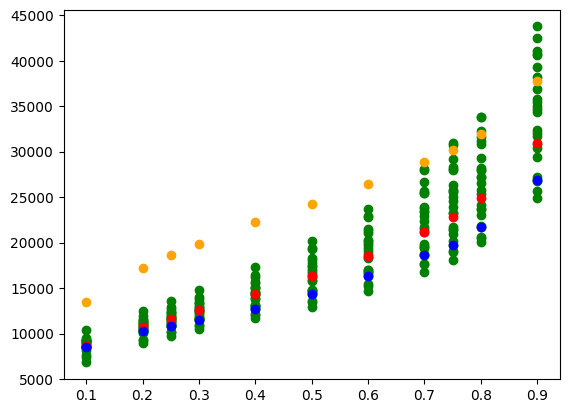

In [148]:
reunion = filo.iloc[34915:]
loc,scale,shape=0,9.7,.5

N_reunion_list = np.array(reunion["NBMEN"]).astype(int)
Q_reunion_list = np.array(reunion[["D1","D2","Q1","D3","D4","Q2","D6","D7","Q3","D8","D9"]]).astype(float)
P=np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])

for q in Q_reunion_list:
    plt.scatter(P,q,color = "green")
    
law = lognorm(s=shape, scale=np.exp(scale),loc=loc)
plt.scatter(P,law.ppf(P),color="red")


N_reunion, Q_reunion = N_reunion_list[np.argmin(N_reunion_list)], Q_reunion_list[np.argmin(N_reunion_list)]
plt.scatter(P,Q_reunion,color = "blue")
plt.scatter(P,Q_contes,color = "orange")
print(N_reunion)


In [7]:
min_q = 6389.64

## La pointe

In [16]:
filo2 = filo[~filo['NBMEN'].str.contains('s')]
filo2 = filo2[~filo2['NBMEN'].str.contains('nd')]
filo2 = filo2[~filo2['D1'].str.contains('s')]
filo3 = filo2[~filo2['CODGEO'].astype(str).str.startswith(('2A', '2B'))]
CODGEO = np.array(filo3['CODGEO']).astype(int)
DROM = filo3.iloc[np.where(CODGEO > 97000)[0]]
DROM.head()
NBMEN_DROM = np.array(DROM['NBMEN']).astype(int)
CODGEO_DROM = np.array(DROM['CODGEO']).astype(int)
np.min(NBMEN_DROM),CODGEO_DROM[np.argmin(NBMEN_DROM)]

(1321, 97203)

In [17]:
La_pointe = DROM.iloc[np.argmin(NBMEN_DROM)]
N_pointe = int(La_pointe["NBMEN"])
Q_pointe = np.array(La_pointe[["D1","D2","Q1","D3","D4","Q2","D6","D7","Q3","D8","D9"]]).astype(float)
N_pointe,Q_pointe

(1321,
 array([ 8550., 10820., 11630., 12500., 14350., 16190., 18070., 20860.,
        22330., 24130., 29140.]))

In [18]:
P=np.array([.1,.2,.25,.3,.4,.5,.6,.7,.75,.8,.9])    


NameError: name 'Q_reunion' is not defined

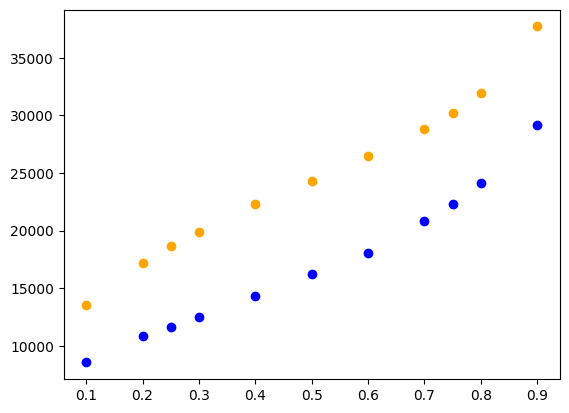

In [19]:
plt.scatter(P,Q_pointe,color = "blue",label="La Pointe N = {}".format(N_pointe))
plt.scatter(P,Q_contes,color = "orange",label="Contes N = {}".format(N_contes))
plt.scatter(P,Q_reunion,color = "green",label="Reunion N = {}".format(N_reunion))
plt.legend()


# Inférence Contes

In [38]:
from RobustGibbsObject.Distribution import Gamma

## Weibull 

In [137]:
from RobustGibbsObject.Model import WeibullModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [139]:
scale = Gamma(10000,10)
shape = Gamma(10,1)

weibull = WeibullModel(scale=scale,shape=shape)

Contes_w = weibull.Gibbs_Quantile(20100,N_contes,Q_contes,P,std_prop_dict={"scale":10,"shape":.01},std_prop_quantile=0.01,verbose=True)

Init...
Init done! {'scale': 15920.865337294323, 'shape': 1.5}


  0%|          | 0/20100 [00:00<?, ?it/s]

100%|██████████| 20100/20100 [03:05<00:00, 108.59it/s]


Acceptance rate of Q 0 = 55.88%
Acceptance rate of Q 1 = 56.65%
Acceptance rate of Q 2 = 52.64%
Acceptance rate of Q 3 = 49.30%
Acceptance rate of Q 4 = 34.61%
Acceptance rate of Q 5 = 35.70%
Acceptance rate of Q 6 = 49.18%
Acceptance rate of Q 7 = 54.08%
Acceptance rate of Q 8 = 59.41%
Acceptance rate of Q 9 = 51.14%
Acceptation rates MH : scale = 92.57% shape = 90.74% 


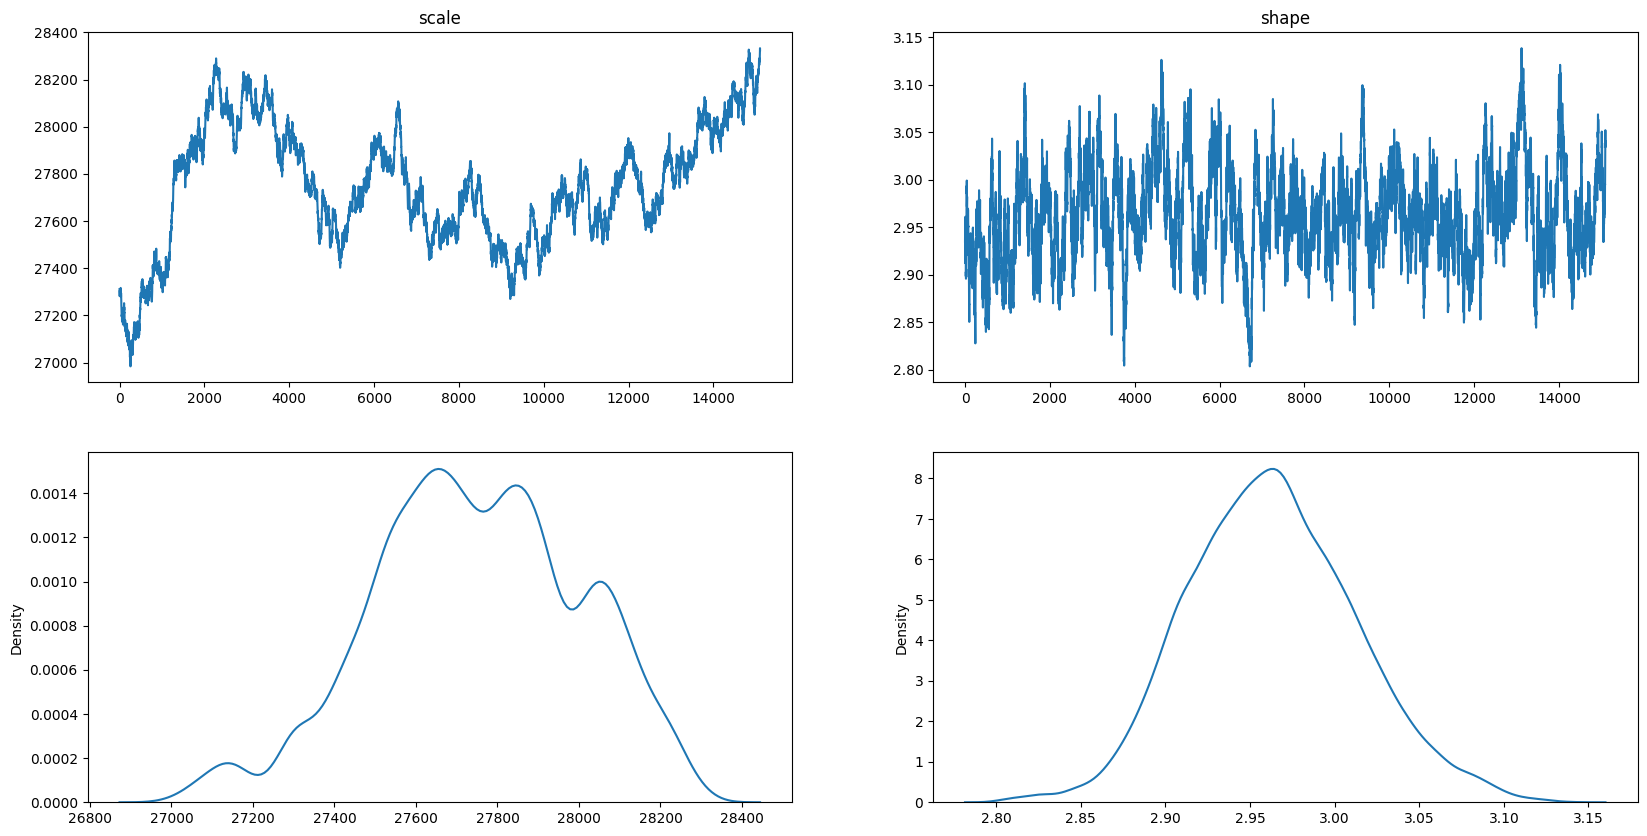

In [140]:
display(Contes_w,burnin=5000)

Weibull :
scale = 27747.928940712856 shape = 2.963065754421223
mean = 24764.976364702612 std = 9101.245121780601


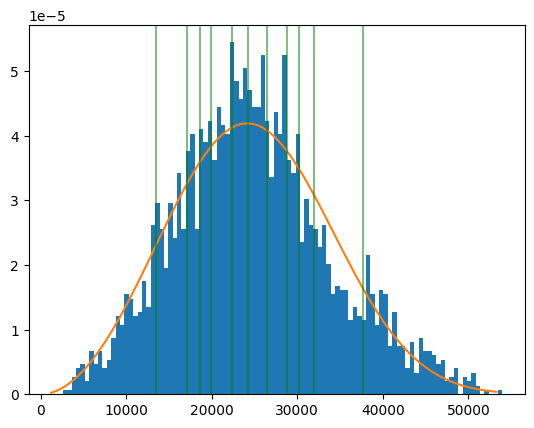

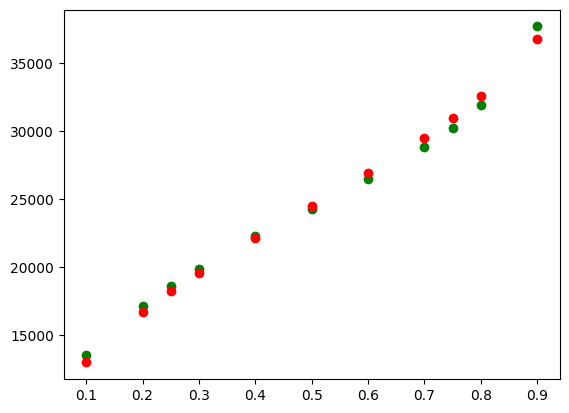

In [141]:
burnin = 5000
post_scale_w_c = np.array(Contes_w["chains"]["scale"][burnin:])
post_shape_w_c = np.array(Contes_w["chains"]["shape"][burnin:])

law_w = weibull_min(c=np.mean(post_shape_w_c),scale=np.mean(post_scale_w_c))
print("Weibull :\nscale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_scale_w_c),np.mean(post_shape_w_c),law_w.mean(),law_w.std()))

x = np.linspace(law_w.ppf(0.0001),law_w.ppf(0.999), 100)
plt.hist(Contes_w["X"][-1],density=True,bins=100)
plt.plot(x, law_w.pdf(x), label="Weibull")
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_w.ppf(P),color="red")
plt.show()


## Translated Weibull

In [142]:
from RobustGibbsObject.Model import TranslatedWeibullModel

In [143]:
loc = Gamma(10000,10)
scale = Gamma(1000,10)
shape = Gamma(10,10)

trans_weibull = TranslatedWeibullModel(loc=loc,scale=scale,shape=shape)

Contes_tw = trans_weibull.Gibbs_Quantile(10090,N_contes,Q_contes,P,std_prop_dict={"loc":300,"scale":300,"shape":.1},std_prop_quantile=0.01,verbose=True)


Init...
Init done! {'loc': 9850.0, 'scale': 15920.865337298015, 'shape': 1.5}


  0%|          | 0/10090 [00:00<?, ?it/s]

100%|██████████| 10090/10090 [01:36<00:00, 104.06it/s]


Acceptance rate of Q 0 = 53.47%
Acceptance rate of Q 1 = 58.14%
Acceptance rate of Q 2 = 55.88%
Acceptance rate of Q 3 = 52.07%
Acceptance rate of Q 4 = 33.43%
Acceptance rate of Q 5 = 37.01%
Acceptance rate of Q 6 = 47.30%
Acceptance rate of Q 7 = 52.11%
Acceptance rate of Q 8 = 57.50%
Acceptance rate of Q 9 = 52.75%
Acceptation rates MH : loc = 42.44% scale = 56.09% shape = 34.87% 


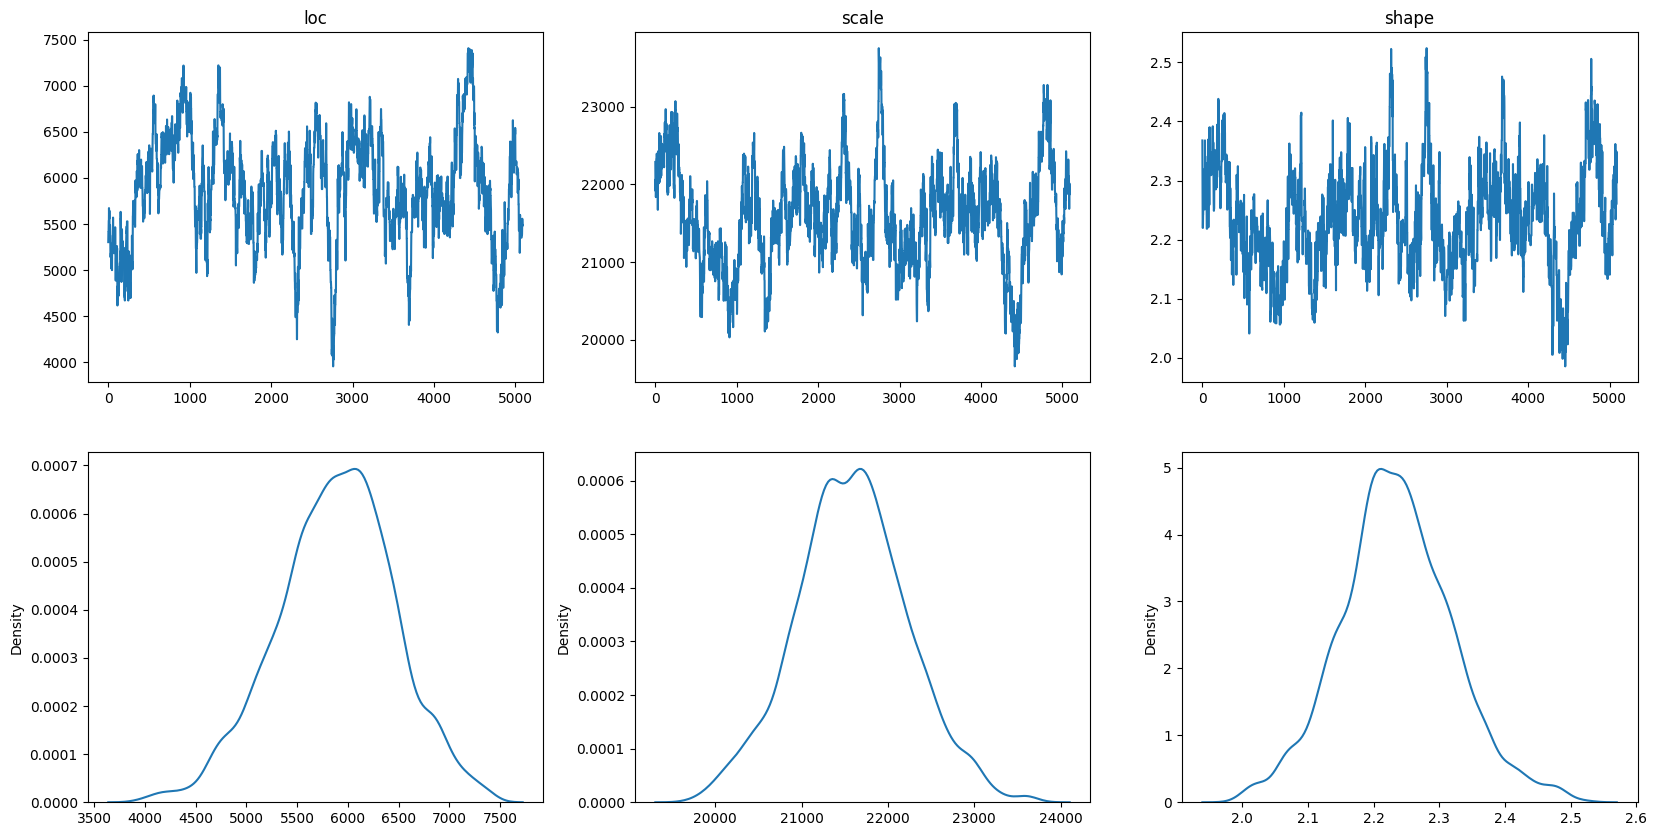

In [144]:
display(Contes_tw,burnin=5000)

In [284]:
import scipy

In [145]:
burnin = 5000
post_loc_tw_c = np.array(Contes_tw["chains"]["loc"][burnin:])
post_scale_tw_c = np.array(Contes_tw["chains"]["scale"][burnin:])
post_shape_tw_c = np.array(Contes_tw["chains"]["shape"][burnin:])

post_mean_tw = post_loc_tw_c + post_scale_tw_c * scipy.special.gamma(1+1/(post_shape_tw_c))
post_std_tw = post_scale_tw_c * np.sqrt(scipy.special.gamma(1+2/(post_shape_tw_c))-(scipy.special.gamma(1+1/(post_shape_tw_c)))**2)
law_tw = weibull_min(c=np.mean(post_shape_tw_c),scale=np.mean(post_scale_tw_c),loc=np.mean(post_loc_tw_c))
print("Translated Weibull :\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_tw_c),np.mean(post_scale_tw_c),np.mean(post_shape_tw_c),law_tw.mean(),law_tw.std()))

x = np.linspace(law_tw.ppf(0.0001),law_tw.ppf(0.999), 100)

plt.hist(Contes_tw["X"][-1],density=True,bins=100)
plt.plot(x, law_tw.pdf(x), label="Translated Weibull")
print("Mode = ",x[np.argmax(law_tw.pdf(x))])
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_tw.ppf(P),color="red")
plt.show()


NameError: name 'scipy' is not defined

In [287]:
np.mean(post_mean_tw),np.mean(post_std_tw)

(25005.697330431296, 9042.36278710849)

## LogNormal

In [ ]:
from RobustGibbsObject.Model import LogNormalModel

In [109]:
from scipy.stats import lognorm

In [ ]:
scale = Gamma(10,1, name="scale")
shape = Gamma(1,1, name="shape")

lognormm = LogNormalModel(scale,shape)


Contes_ln = lognormm.Gibbs_Quantile(10000,N_contes,Q_contes,P,std_prop_dict={"scale":.01,"shape":.01})

Init...
Init done! {'scale': 10.097820021996219, 'shape': 0.2997957637195009}


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [01:09<00:00, 144.25it/s]

Acceptance rate of Q 0 = 7.90%
Acceptance rate of Q 1 = 11.96%
Acceptance rate of Q 2 = 10.22%
Acceptance rate of Q 3 = 8.56%
Acceptance rate of Q 4 = 3.91%
Acceptance rate of Q 5 = 3.92%
Acceptance rate of Q 6 = 6.68%
Acceptance rate of Q 7 = 7.05%
Acceptance rate of Q 8 = 8.02%
Acceptance rate of Q 9 = 7.72%
Acceptation rates MH : scale = 61.43% shape = 50.96% 


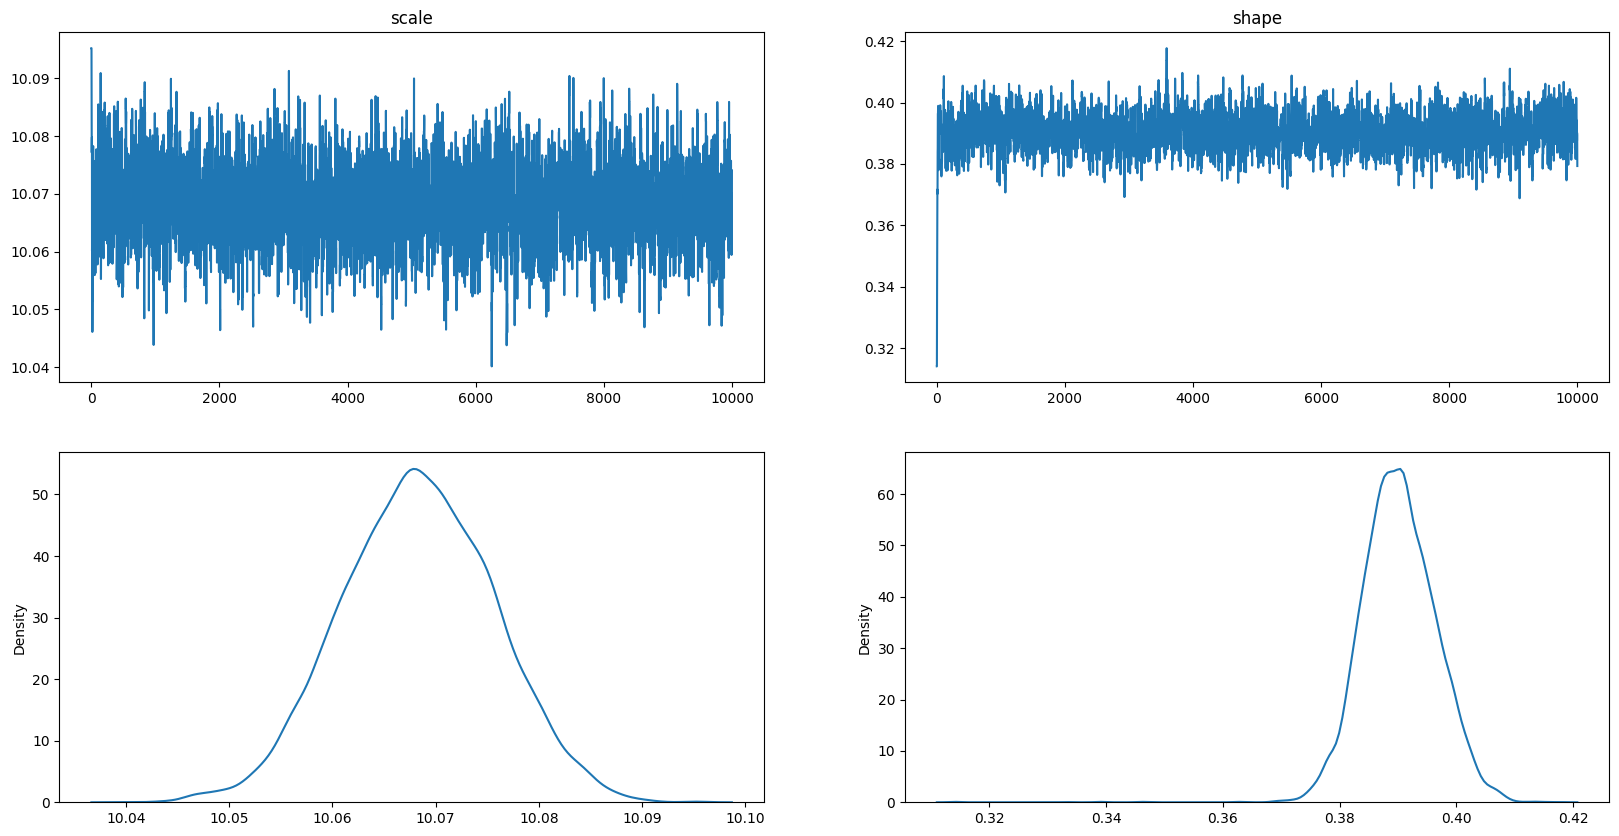

In [207]:
display(Contes_ln)

LogNormal:
scale = 10.068201344081682 shape = 0.39020483994604654


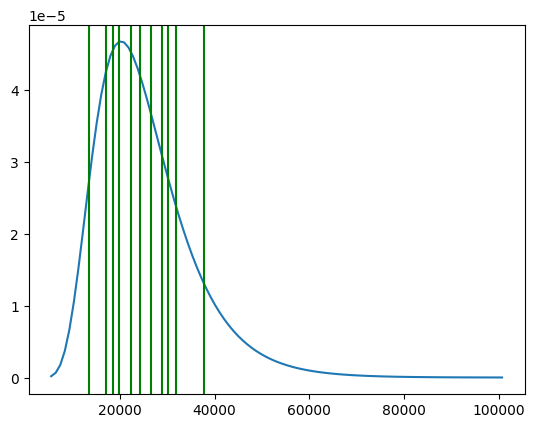

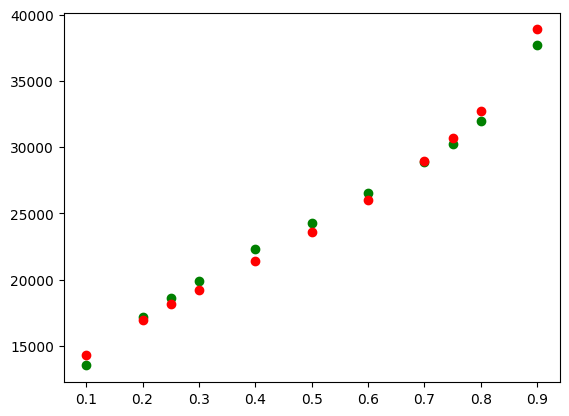

In [208]:
post_scale_ln_c = Contes_ln["chains"]["scale"][1000:]
post_shape_ln_c = Contes_ln["chains"]["shape"][1000:]

print("LogNormal:\nscale = {} shape = {}".format(np.mean(post_scale_ln_c),np.mean(post_shape_ln_c)))

law_ln = lognorm(s=np.mean(post_shape_ln_c), scale=np.mean(np.exp(post_scale_ln_c)))
x = np.linspace(law_ln.ppf(0.0001),law_ln.ppf(0.9999), 100)

plt.plot(x,law_ln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color = "green")
plt.show()

plt.scatter(P,Q_contes,color = "green")
plt.scatter(P,law_ln.ppf(P),color = "red")



## Translated LogNormal

In [161]:
from RobustGibbsObject.Model import TranslatedLogNormalModel

In [209]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(10,3, name="scale")
shape = Gamma(1,1,name="shape")

trans_lognorm = TranslatedLogNormalModel(loc,scale,shape)


Contes_tln = trans_lognorm.Gibbs_Quantile(10000,N_contes,Q_contes,P,std_prop_dict={"loc":100,"scale":.1,"shape":.1},std_prop_quantile=.01)

Init...
{'loc': 9850.0, 'scale': 10.097820021996219, 'shape': 0.2997957637195009}
Init done! {'loc': 9850.0, 'scale': 10.097820021996219, 'shape': 0.2997957637195009}


  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:224: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(proposed_llikelihood - current_llikelihood + proposed_lprior - current_lprior)
100%|██████████| 10000/10000 [01:33<00:00, 106.89it/s]


Acceptance rate of Q 0 = 50.60%
Acceptance rate of Q 1 = 64.56%
Acceptance rate of Q 2 = 59.03%
Acceptance rate of Q 3 = 56.64%
Acceptance rate of Q 4 = 35.87%
Acceptance rate of Q 5 = 35.22%
Acceptance rate of Q 6 = 43.89%
Acceptance rate of Q 7 = 47.12%
Acceptance rate of Q 8 = 51.90%
Acceptance rate of Q 9 = 51.05%
Acceptation rates MH : loc = 75.20% scale = 9.42% shape = 7.33% 


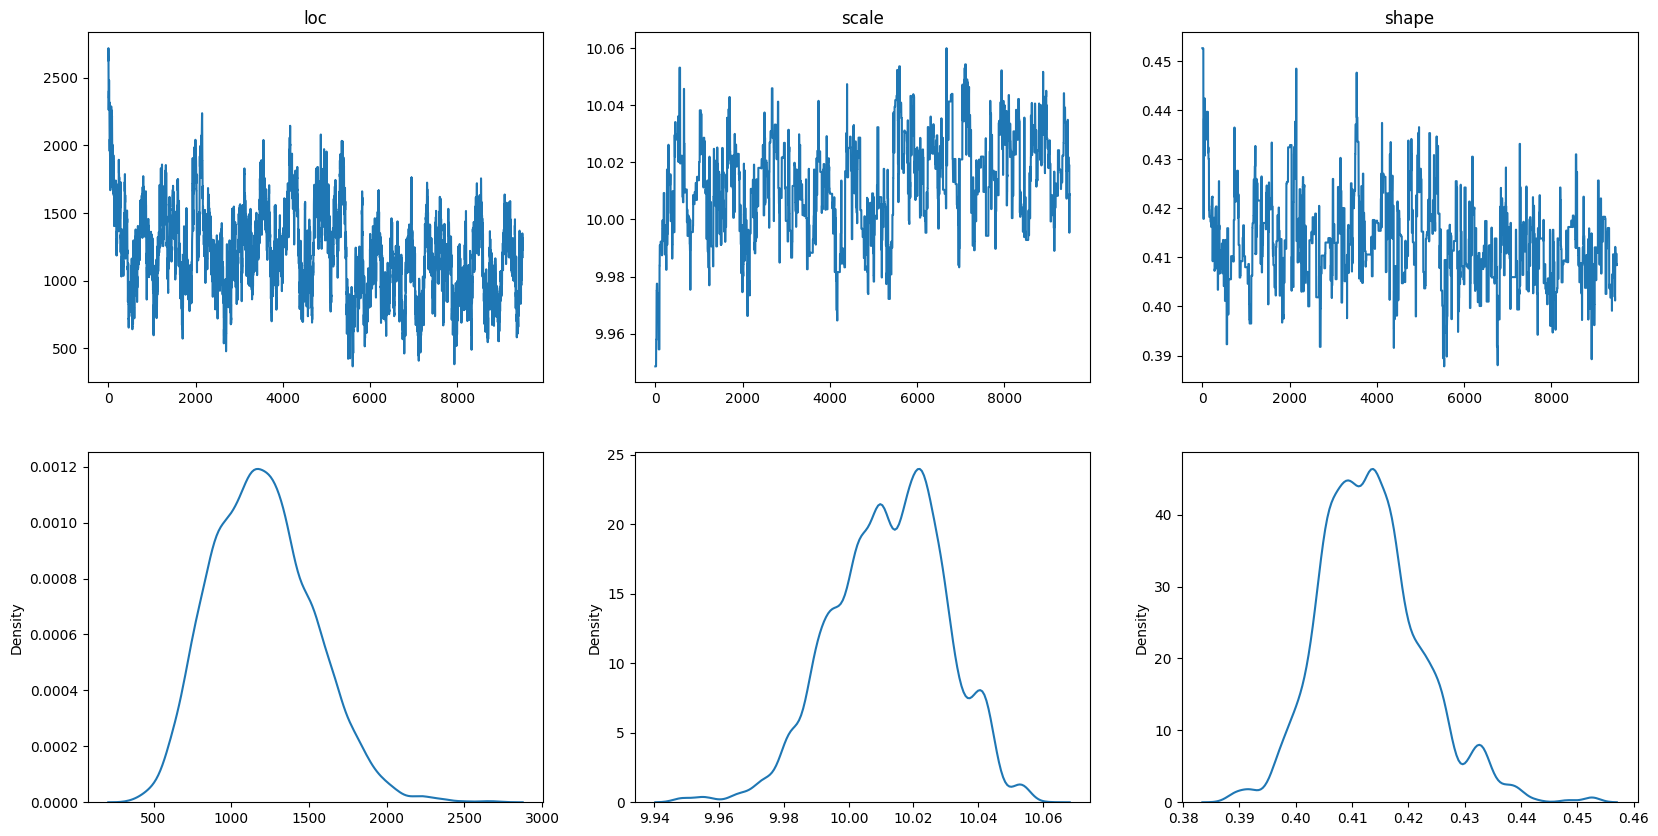

In [212]:
display(Contes_tln,burnin=500)

Translated LogNormal:
loc = 1184.0906306450315 scale = 10.013499203856787 shape = 0.4129156398278612


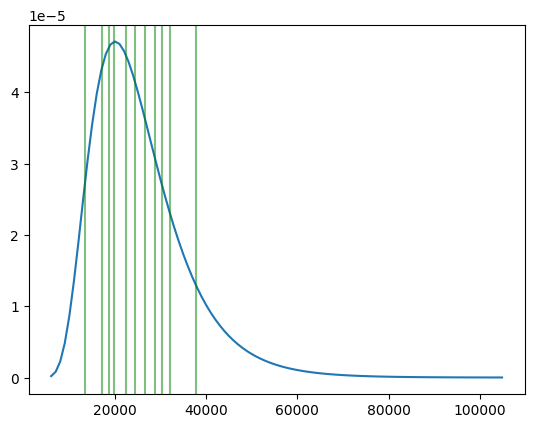

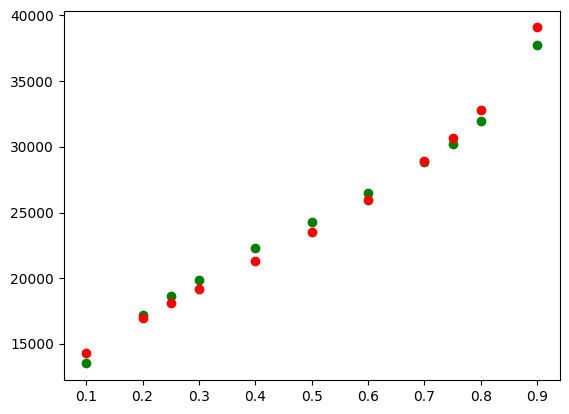

In [246]:
post_loc_tln_c = (Contes_tln["chains"]["loc"][1000:])
post_scale_tln_c = (Contes_tln["chains"]["scale"][1000:])
post_shape_tln_c = (Contes_tln["chains"]["shape"][1000:])

print("Translated LogNormal:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_tln_c),np.mean(post_scale_tln_c),np.mean(post_shape_tln_c)))
law_tln = lognorm(s=np.mean(post_shape_tln_c), scale=np.exp(np.mean(post_scale_tln_c)),loc=np.mean(post_loc_tln_c))
x=np.linspace(law_tln.ppf(0.0001),law_tln.ppf(0.9999), 100)
plt.plot(x,law_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_tln.ppf(P),color="red")

## Reparametrized Tranlated LogNormal

In [144]:
from RobustGibbsObject.Model import ReparametrizedTranslatedLogNormalModel
from RobustGibbsObject.Distribution import Gamma


In [215]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

trans_lognorm = ReparametrizedTranslatedLogNormalModel(loc,mean,std)


Contes_repar_tln = trans_lognorm.Gibbs_Quantile(10000,N_contes,Q_contes,P,std_prop_dict={"loc":80,"mean":500,"std":500},std_prop_quantile=.05)

Init...
Init done! {'loc': 9850.0, 'mean': 35256.460523108355, 'std': 7791.141037580667}


  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:224: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(proposed_llikelihood - current_llikelihood + proposed_lprior - current_lprior)
100%|██████████| 10000/10000 [01:24<00:00, 118.60it/s]

Acceptance rate of Q 0 = 13.70%
Acceptance rate of Q 1 = 21.59%
Acceptance rate of Q 2 = 19.26%
Acceptance rate of Q 3 = 17.26%
Acceptance rate of Q 4 = 9.46%
Acceptance rate of Q 5 = 9.09%
Acceptance rate of Q 6 = 11.60%
Acceptance rate of Q 7 = 13.52%
Acceptance rate of Q 8 = 15.03%
Acceptance rate of Q 9 = 14.40%
Acceptation rates MH : loc = 90.80% mean = 33.88% std = 33.08% 


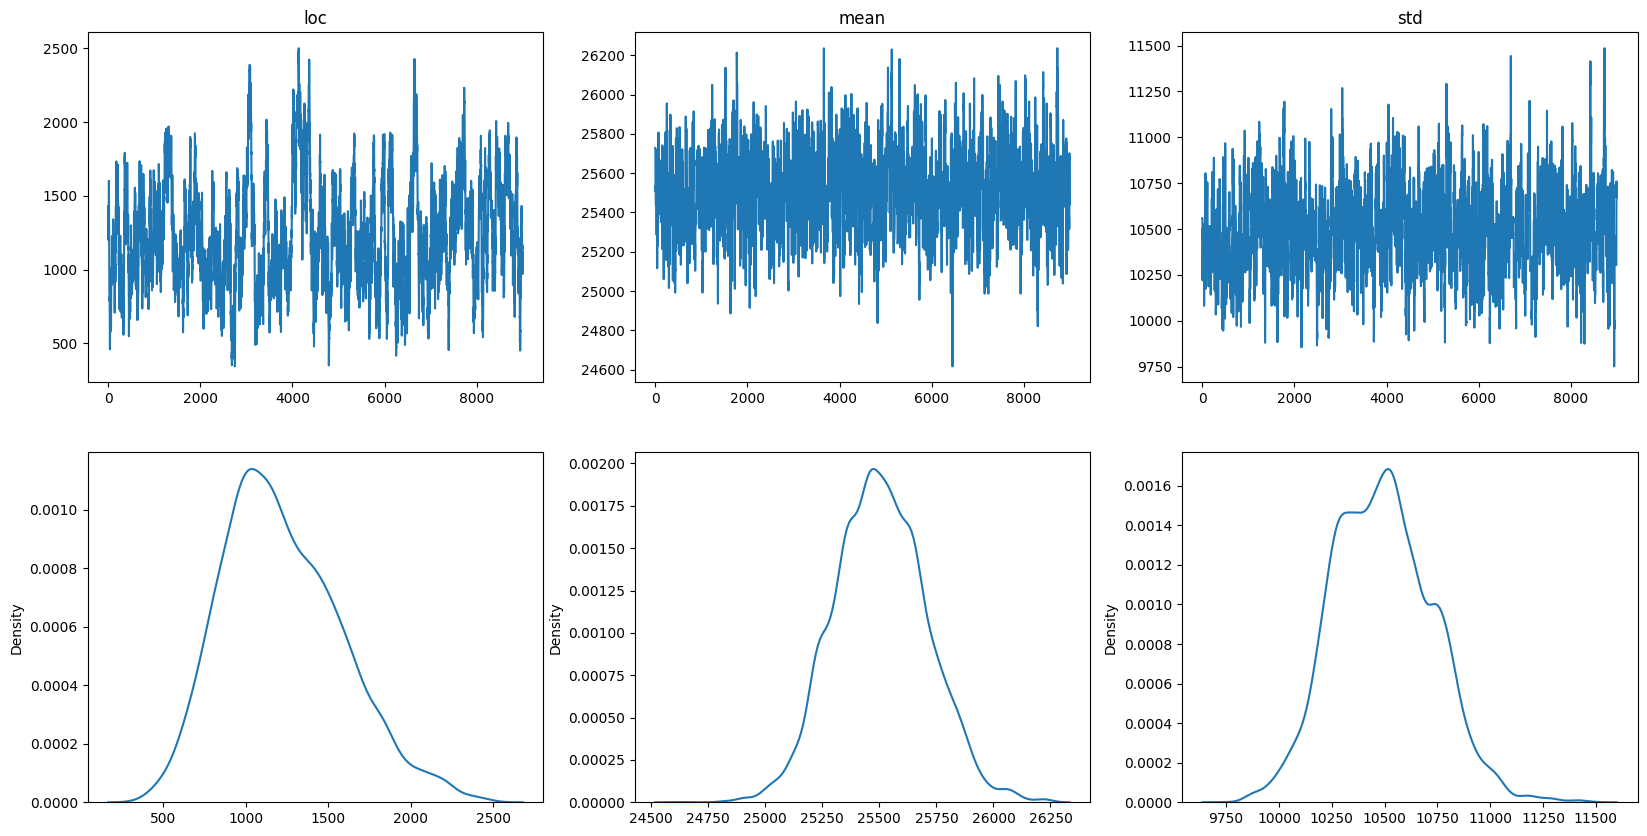

In [216]:
display(Contes_repar_tln,burnin=1000)

Reparametrized Translated LogNormal:
loc = 1224.052395175211 scale = 10.011665550865017 shape = 0.4138078409304721
mean = 25505.526828615253 std = 10492.073137148016


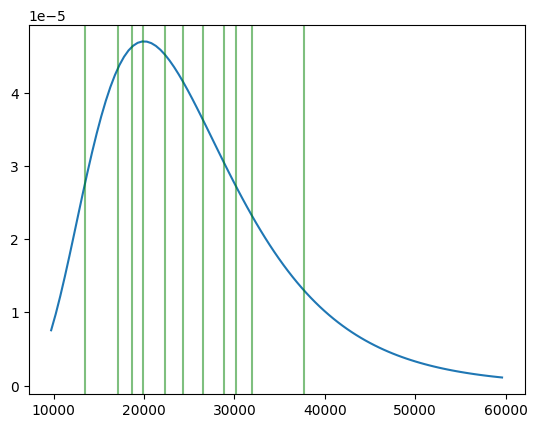

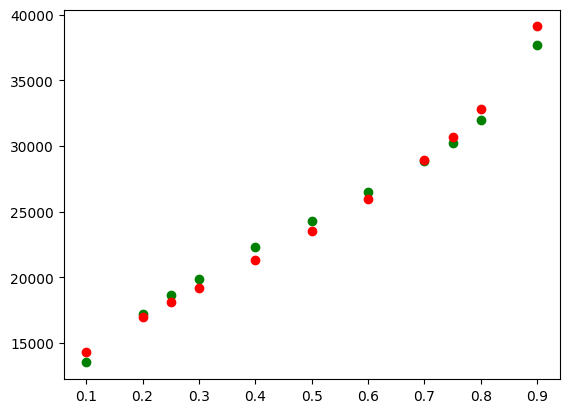

In [217]:
post_loc_repar_tln_c = np.array(Contes_repar_tln["chains"]["loc"][1000:])
post_mean_repar_tln_c = np.array(Contes_repar_tln["chains"]["mean"][1000:])
post_std_repar_tln_c = np.array(Contes_repar_tln["chains"]["std"][1000:])

post_scale_repar_tln_c = np.log((post_mean_repar_tln_c-post_loc_repar_tln_c)**2/np.sqrt((post_mean_repar_tln_c-post_loc_repar_tln_c)**2+(post_std_repar_tln_c)**2))
post_shape_repar_tln_c = np.sqrt(np.log(1+np.power(post_std_repar_tln_c,2)/np.power(post_mean_repar_tln_c-post_loc_repar_tln_c,2)))

print("Reparametrized Translated LogNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_tln_c),np.mean(post_scale_repar_tln_c),np.mean(post_shape_repar_tln_c),np.mean(post_mean_repar_tln_c),np.mean(post_std_repar_tln_c)))

law_repar_tnl = lognorm(s=np.mean(post_shape_repar_tln_c), scale=np.mean(np.exp(post_scale_repar_tln_c)),loc=np.mean(post_loc_repar_tln_c))
x=np.linspace(law_repar_tnl.ppf(0.01),law_repar_tnl.ppf(0.99), 100)
plt.plot(x,law_repar_tnl.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_repar_tnl.ppf(P),color="red")


## Generalized Pareto

In [218]:
from RobustGibbsObject.Model import GeneralizedParetoModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [219]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(1000,25,name="scale")
shape = Normal(0,1, name="shape")

gen_par = GeneralizedParetoModel(loc,scale,shape)


Contes_gp = gen_par.Gibbs_Quantile(50000,N_contes,Q_contes,P,std_prop_dict={"loc":10,"scale":400,"shape":.01},std_prop_quantile=.01,List_X=True)

Init...
Init done! {'loc': 9850.0, 'scale': 9748.980441233685, 'shape': 0.1}


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [10:13<00:00, 81.50it/s]


Acceptance rate of Q 0 = 54.30%
Acceptance rate of Q 1 = 64.21%
Acceptance rate of Q 2 = 56.36%
Acceptance rate of Q 3 = 50.45%
Acceptance rate of Q 4 = 31.27%
Acceptance rate of Q 5 = 31.49%
Acceptance rate of Q 6 = 44.07%
Acceptance rate of Q 7 = 49.93%
Acceptance rate of Q 8 = 59.03%
Acceptance rate of Q 9 = 52.69%
Acceptation rates MH : loc = 45.63% scale = 15.30% shape = 18.90% 


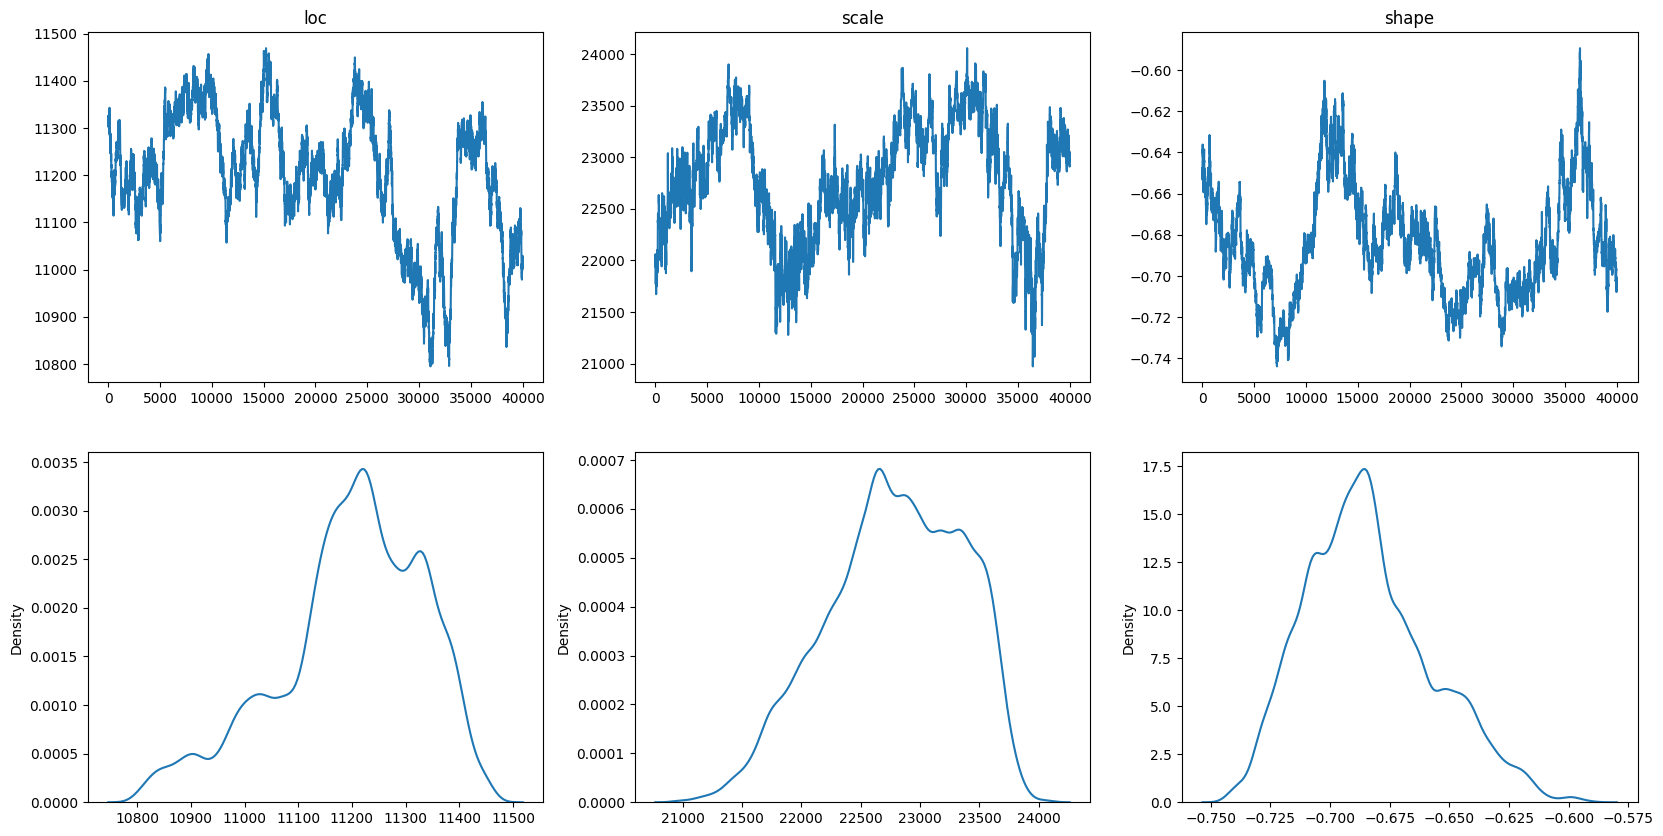

In [220]:
display(Contes_gp,burnin=10000)

Generalized Pareto:
loc = 11198.086865789473 scale = 22784.785310012026 shape = -0.684059904768414
mean = 24727.76312344333 std = 8791.957284704613


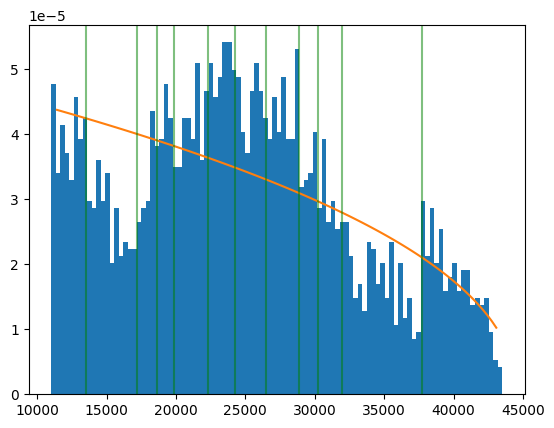

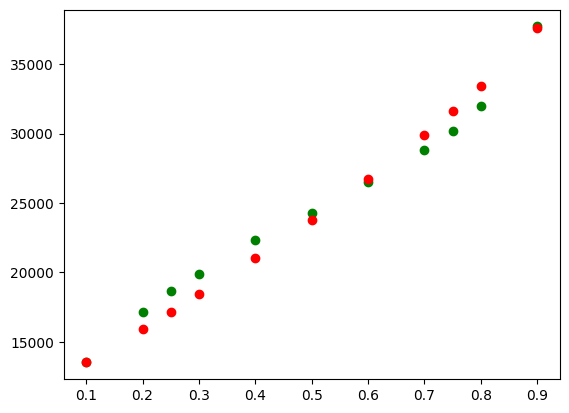

In [221]:
burnin=10000
post_loc_gp_c = np.array(Contes_gp["chains"]["loc"][burnin:])
post_scale_gp_c = np.array(Contes_gp["chains"]["scale"][burnin:])
post_shape_gp_c = np.array(Contes_gp["chains"]["shape"][burnin:])

print("Generalized Pareto:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_gp_c),np.mean(post_scale_gp_c),np.mean(post_shape_gp_c)))
law_gp = genpareto(c=np.mean(post_shape_gp_c), scale=np.mean(post_scale_gp_c),loc=np.mean(post_loc_gp_c))
print("mean = {} std = {}".format(law_gp.mean(),law_gp.std()))
plt.hist(Contes_gp["X"][-1],bins=100,density=True);
x=np.linspace(law_gp.ppf(0.01),law_gp.ppf(0.99), 100)

plt.plot(x,law_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_gp.ppf(P),color="red")



## Reparametrized Generalized Pareto

In [147]:
from RobustGibbsObject.Model import ReparametrizedGeneralizedParetoModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [222]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

repar_gen_par = ReparametrizedGeneralizedParetoModel(loc,mean,std)

Contes_repar_gp = repar_gen_par.Gibbs_Quantile(50000,N_contes,Q_contes,P,std_prop_dict={"loc":10,"mean":65,"std":12},std_prop_quantile=.05)


Init...
Init done! {'loc': 9850.0, 'mean': 20682.200490259653, 'std': 10899.691488957207}


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [19:16<00:00, 43.23it/s]    


Acceptance rate of Q 0 = 16.40%
Acceptance rate of Q 1 = 22.65%
Acceptance rate of Q 2 = 17.22%
Acceptance rate of Q 3 = 14.35%
Acceptance rate of Q 4 = 7.38%
Acceptance rate of Q 5 = 7.23%
Acceptance rate of Q 6 = 11.61%
Acceptance rate of Q 7 = 14.17%
Acceptance rate of Q 8 = 19.30%
Acceptance rate of Q 9 = 15.71%
Acceptation rates MH : loc = 46.30% mean = 46.46% std = 63.39% 


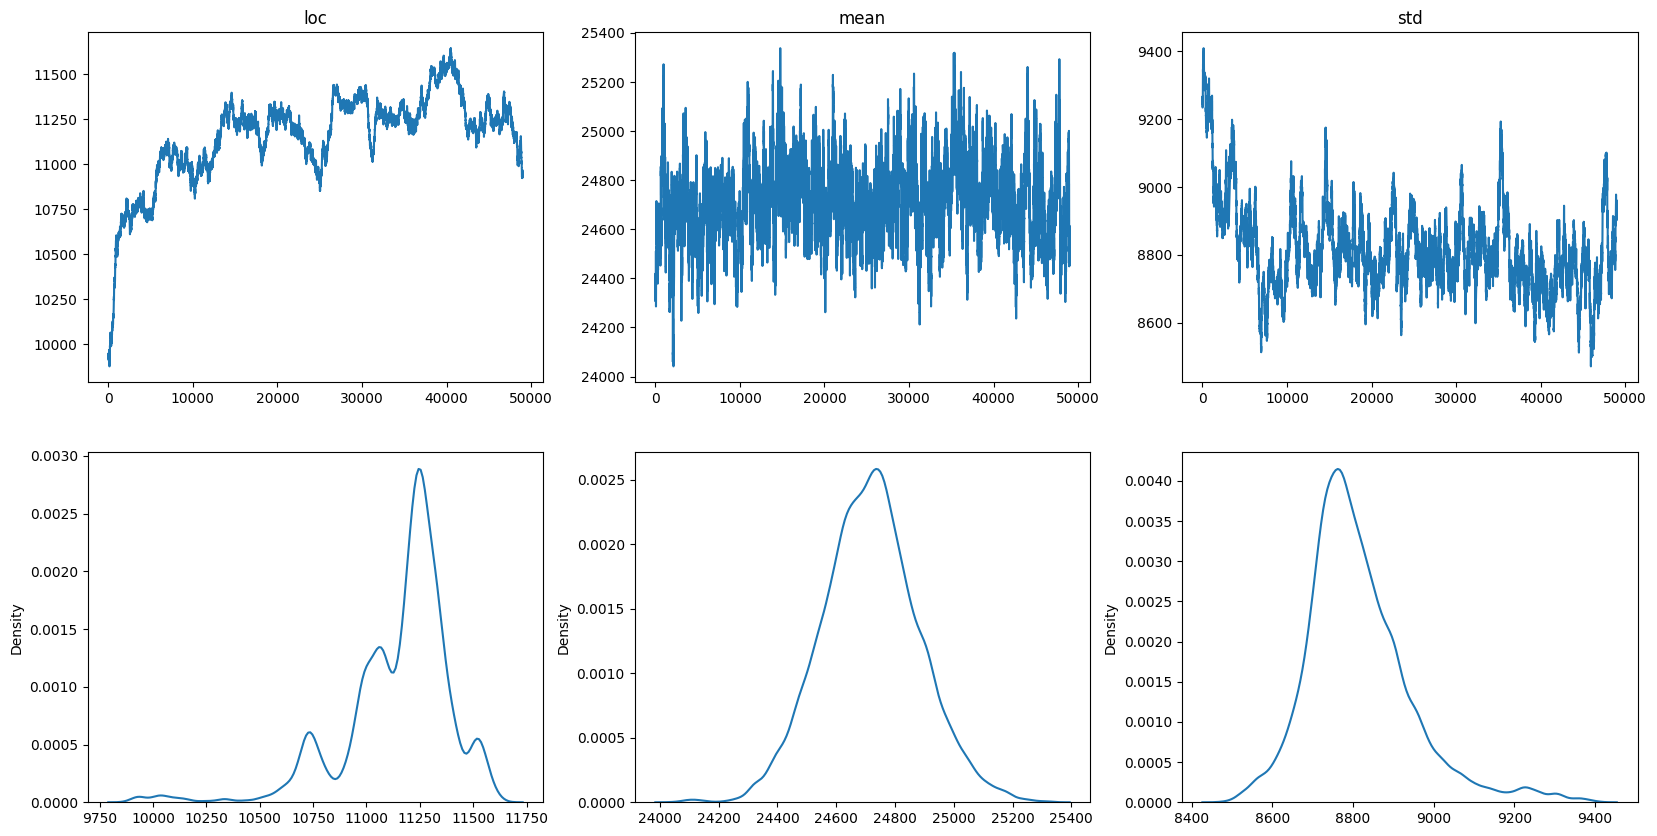

In [223]:
display(Contes_repar_gp,burnin=1000)

Reparametrized Generalized Pareto:
loc = 11150.748404375154 scale = 22860.008671836873 shape = -0.6846287883381434
mean = 24717.039478089202 std = 8814.741046483528


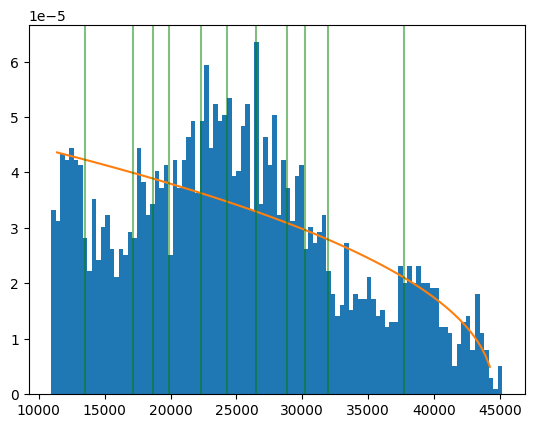

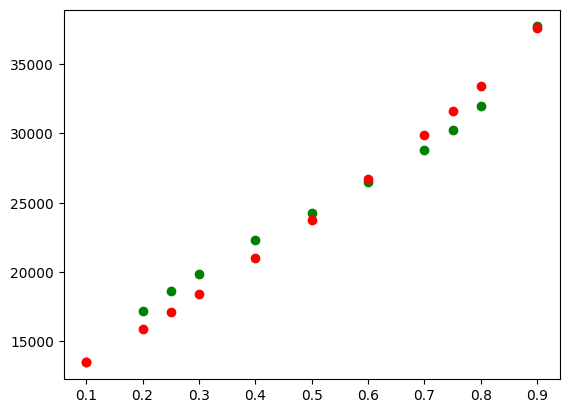

In [224]:
burnin =1000
post_loc_repar_gp_c = np.array(Contes_repar_gp["chains"]["loc"][burnin:])
post_mean_repar_gp_c = np.array(Contes_repar_gp["chains"]["mean"][burnin:])
post_std_repar_gp_c = np.array(Contes_repar_gp["chains"]["std"][burnin:])

post_scale_repar_gp_c = ((post_mean_repar_gp_c-post_loc_repar_gp_c)/2+(post_mean_repar_gp_c-post_loc_repar_gp_c)**3/(2*post_std_repar_gp_c**2))
post_shape_repar_gp_c = 1/2-(post_mean_repar_gp_c-post_loc_repar_gp_c)**2/(2*post_std_repar_gp_c**2)

print("Reparametrized Generalized Pareto:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_gp_c),np.mean(post_scale_repar_gp_c),np.mean(post_shape_repar_gp_c),np.mean(post_mean_repar_gp_c),np.mean(post_std_repar_gp_c)))
law_repar_gp = genpareto(c=np.mean(post_shape_repar_gp_c), scale=np.mean(post_scale_repar_gp_c),loc=np.mean(post_loc_repar_gp_c))
x=np.linspace(law_repar_gp.ppf(0.01),law_repar_gp.ppf(0.999), 100)

plt.hist(Contes_repar_gp["X"][-1],bins=100,density=True);
plt.plot(x,law_repar_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_repar_gp.ppf(P),color="red")


## Pareto Type II

In [8]:
from RobustGibbsObject.Model import ParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [ ]:
scale, shape = (scale-loc)*(shape**2+(scale-loc)**2)/(shape**2-(scale-loc)**2),2*shape**2/(shape**2-(scale-loc)**2)

In [225]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(1000,1000, name="scale")
shape = Gamma(10,10, name="shape")

p2 = ParetoType2Model(loc,scale,shape)

Contes_p2 = p2.Gibbs_Quantile(100000,N_contes,Q_contes,P,std_prop_dict={"loc":10,"scale":5000,"shape":1},std_prop_quantile=.1,List_X=True)

Init...
Init done! {'loc': 9850.0, 'scale': 16482.376877221937, 'shape': 2.5}


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 70/100000 [00:00<02:22, 699.20it/s]

CONTINUE {} -0.4123296291097134


100%|██████████| 100000/100000 [02:18<00:00, 724.46it/s]


Acceptance rate of Q 0 = 8.89%
Acceptance rate of Q 1 = 17.38%
Acceptance rate of Q 2 = 12.00%
Acceptance rate of Q 3 = 9.10%
Acceptance rate of Q 4 = 4.05%
Acceptance rate of Q 5 = 3.14%
Acceptance rate of Q 6 = 4.28%
Acceptance rate of Q 7 = 4.66%
Acceptance rate of Q 8 = 5.27%
Acceptance rate of Q 9 = 6.47%
Acceptation rates MH : loc = 32.77% scale = 90.30% shape = 77.39% 


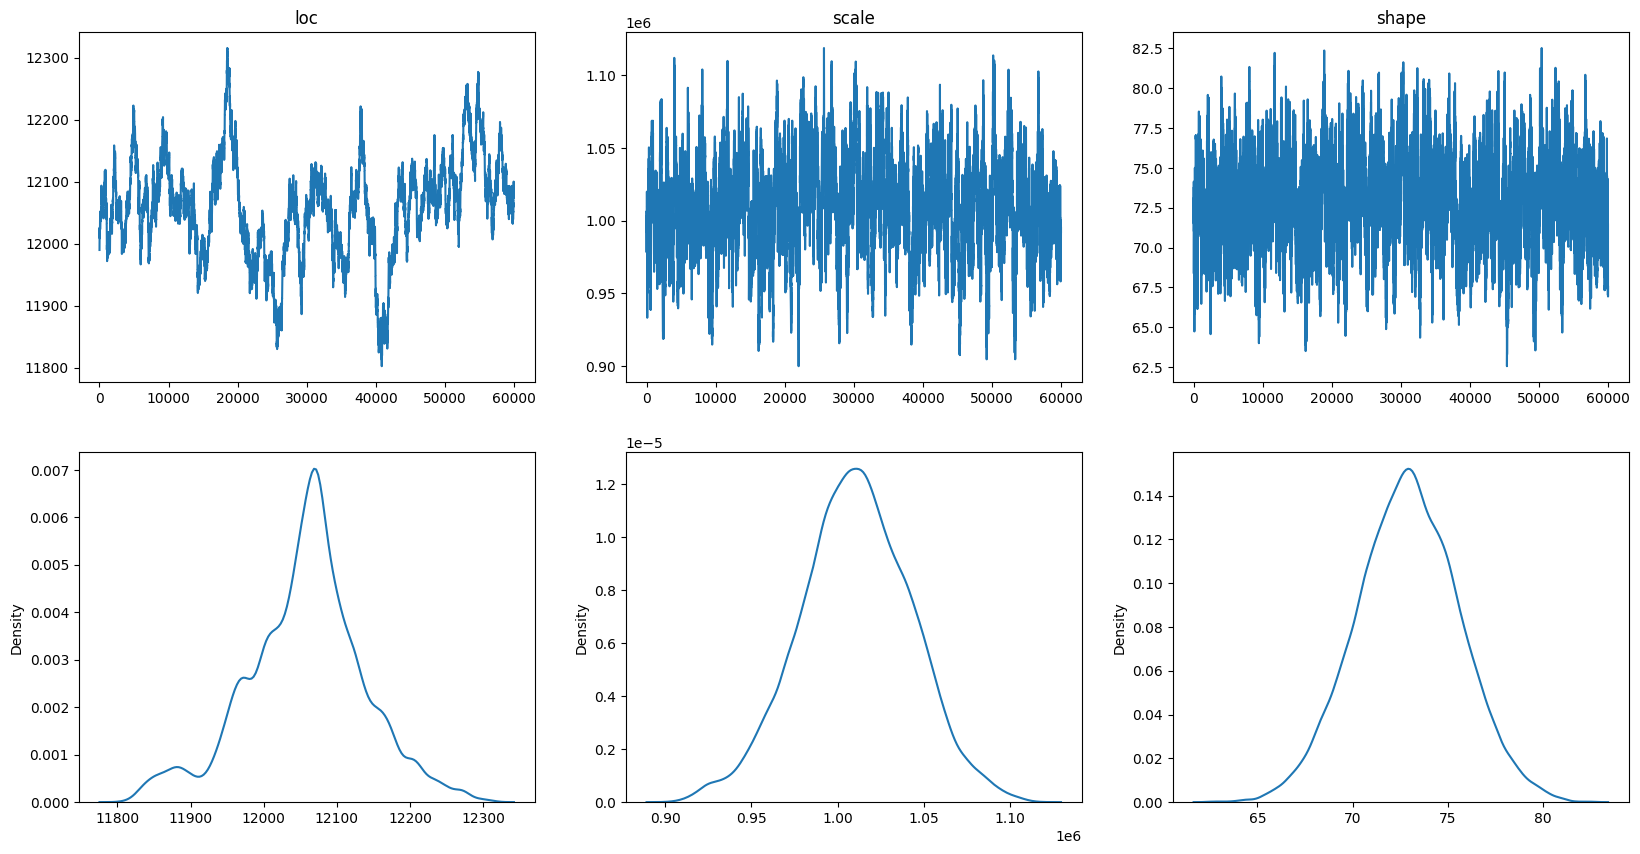

In [226]:
display(Contes_p2,burnin=40000)

In [47]:
class pareto2:
    def __init__(self, loc=0, scale=1,shape=1):
        self.loc = loc
        self.scale = scale
        self.shape = shape
        
    def pdf(self,x):
        x=np.array(x)
        return (self.shape/self.scale)*(1+(x-self.loc)/self.scale)**(-self.shape-1)
    def cdf(self,x):
        x=np.array(x)
        return 1-(1+(x-self.loc)/self.scale)**(-self.shape)
    def ppf(self,x):
        x=np.array(x)
        return self.loc+self.scale*((1-x)**(-1/self.shape)-1)
    def logpdf(self,x):
        x=np.array(x)
        return np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale)
    def rvs(self,size):
        return self.ppf(np.random.random(size))
    def mean(self):
        if self.shape<1:
            return np.inf
        else:
            return self.scale/(self.shape-1)+self.loc
    def std(self):
        if self.shape<2:
            return np.inf
        else:
            return self.scale*np.sqrt(self.shape/((self.shape-1)**2*(self.shape-2)))

Pareto Type 2:
loc = 12057.433614215564 scale = 1010481.1225630274 shape = 72.89998406194775
mean = 26111.416181060293 std = 14250.826686936405


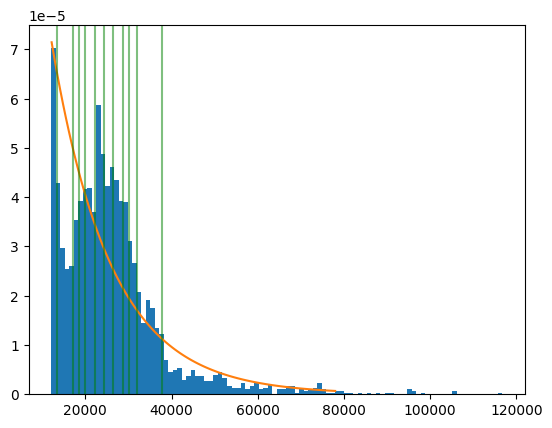

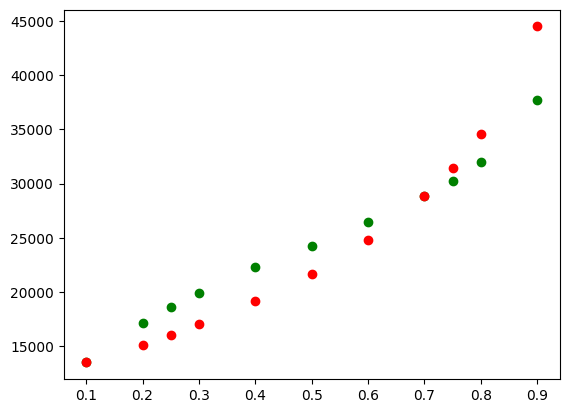

In [227]:
burnin = 40000
post_loc_p2_c = np.array(Contes_p2["chains"]["loc"][burnin:])
post_scale_p2_c = np.array(Contes_p2["chains"]["scale"][burnin:])
post_shape_p2_c = np.array(Contes_p2["chains"]["shape"][burnin:])

print("Pareto Type 2:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_p2_c),np.mean(post_scale_p2_c),np.mean(post_shape_p2_c)))

law_p2 = pareto2(loc=np.mean(post_loc_p2_c), scale=np.mean(post_scale_p2_c),shape=np.mean(post_shape_p2_c))
print("mean = {} std = {}".format(law_p2.mean(),law_p2.std()))
x=np.linspace(law_p2.ppf(0.01),law_p2.ppf(0.99), 100)
plt.hist(Contes_p2["X"][-1],bins=100,density=True);
plt.plot(x,law_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_p2.ppf(P),color="red")


## Reparametrized Pareto Type II

In [11]:
from RobustGibbsObject.Model import ReparametrizedParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [151]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

repar_p2 = ReparametrizedParetoType2Model(loc,mean,std)

Contes_repar_p2 = repar_p2.Gibbs_Quantile(100000,N_contes,Q_contes,P,std_prop_dict={"loc":10,"mean":65,"std":12},std_prop_quantile=.05)


Init...
Init done! {'loc': 9850.0, 'mean': 20838.25125148129, 'std': 24570.476752159306}


  2%|▏         | 2074/100000 [00:03<02:19, 701.76it/s]/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Distribution.py:427: RuntimeWarning: invalid value encountered in log
  return np.where(x>=self.loc,np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale),-np.inf)
100%|██████████| 100000/100000 [02:22<00:00, 699.42it/s]


Acceptance rate of Q 0 = 26.66%
Acceptance rate of Q 1 = 31.69%
Acceptance rate of Q 2 = 23.47%
Acceptance rate of Q 3 = 18.09%
Acceptance rate of Q 4 = 8.25%
Acceptance rate of Q 5 = 6.60%
Acceptance rate of Q 6 = 8.82%
Acceptance rate of Q 7 = 9.72%
Acceptance rate of Q 8 = 10.98%
Acceptance rate of Q 9 = 12.93%
Acceptation rates MH : loc = 45.48% mean = 17.59% std = 54.90% 


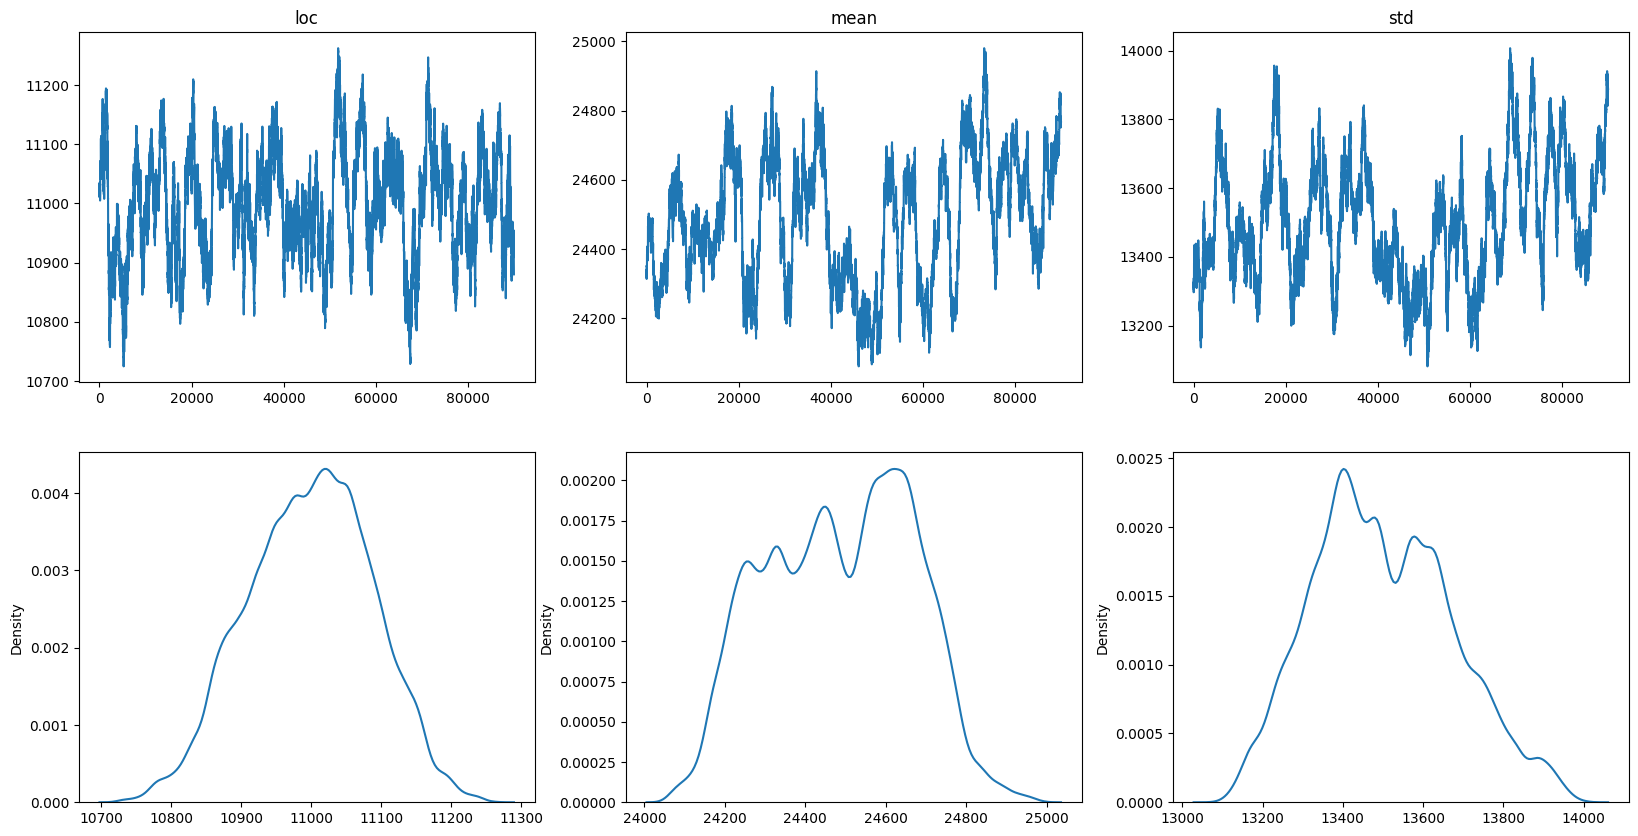

In [228]:
display(Contes_repar_p2,10000)

Reparametrized Pareto Type 2:
loc = 10998.366358511601 scale = 146376652.42228487 shape = 10864.960106651706
mean = 24486.166628017938 std = 13500.53219123775


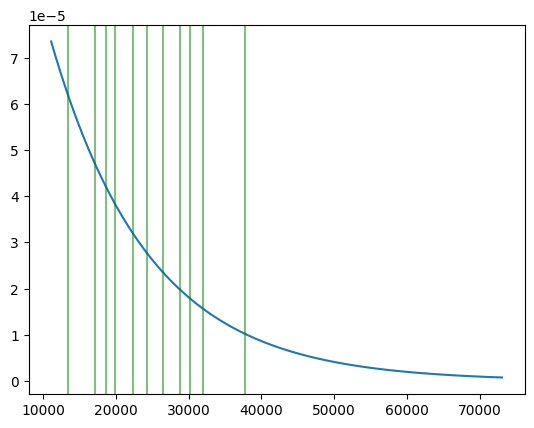

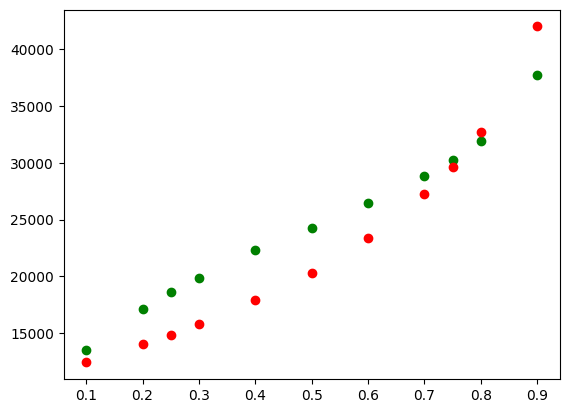

In [229]:
post_loc_repar_p2_c = np.array(Contes_repar_p2["chains"]["loc"][10000:])
post_mean_repar_p2_c = np.array(Contes_repar_p2["chains"]["mean"][10000:])
post_std_repar_p2_c = np.array(Contes_repar_p2["chains"]["std"][10000:])

post_scale_repar_p2_c = ((post_mean_repar_p2_c-post_loc_repar_p2_c)*(post_std_repar_p2_c**2+(post_mean_repar_p2_c-post_loc_repar_p2_c)**2)/(post_std_repar_p2_c**2-(post_mean_repar_p2_c-post_loc_repar_p2_c)**2))

post_shape_repar_p2_c = 2*post_std_repar_p2_c**2/(post_std_repar_p2_c**2-(post_mean_repar_p2_c-post_loc_repar_p2_c)**2)

print("Reparametrized Pareto Type 2:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_p2_c),np.mean(post_scale_repar_p2_c),np.mean(post_shape_repar_p2_c),np.mean(post_mean_repar_p2_c),np.mean(post_std_repar_p2_c)))
law_repar_p2 = pareto2(loc=np.mean(post_loc_repar_p2_c), scale=np.mean(post_scale_repar_p2_c),shape=np.mean(post_shape_repar_p2_c))
x=np.linspace(law_repar_p2.ppf(0.01),law_repar_p2.ppf(0.99), 100)
plt.plot(x,law_repar_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_repar_p2.ppf(P),color="red")


## Fixed Translated LN

In [ ]:
from RobustGibbsObject.Model import FixedReparametrizedTranslatedLogNormalModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [147]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_tln = FixedReparametrizedTranslatedLogNormalModel(mean,std)

Reunion_fix_repar_tln = fix_repar_tln.Gibbs_Quantile(20000,N_contes,Q_contes,P,std_prop_dict={"mean":100,"std":50},std_prop_quantile=.05,List_X=True)

Init...
Init done! {'mean': 25000, 'std': 10000}


  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [02:45<00:00, 121.08it/s]


Acceptance rate of Q 0 = 13.92%
Acceptance rate of Q 1 = 24.52%
Acceptance rate of Q 2 = 21.07%
Acceptance rate of Q 3 = 17.51%
Acceptance rate of Q 4 = 9.21%
Acceptance rate of Q 5 = 8.09%
Acceptance rate of Q 6 = 11.25%
Acceptance rate of Q 7 = 11.45%
Acceptance rate of Q 8 = 13.00%
Acceptance rate of Q 9 = 14.29%
Acceptation rates MH : mean = 78.21% std = 90.83% 


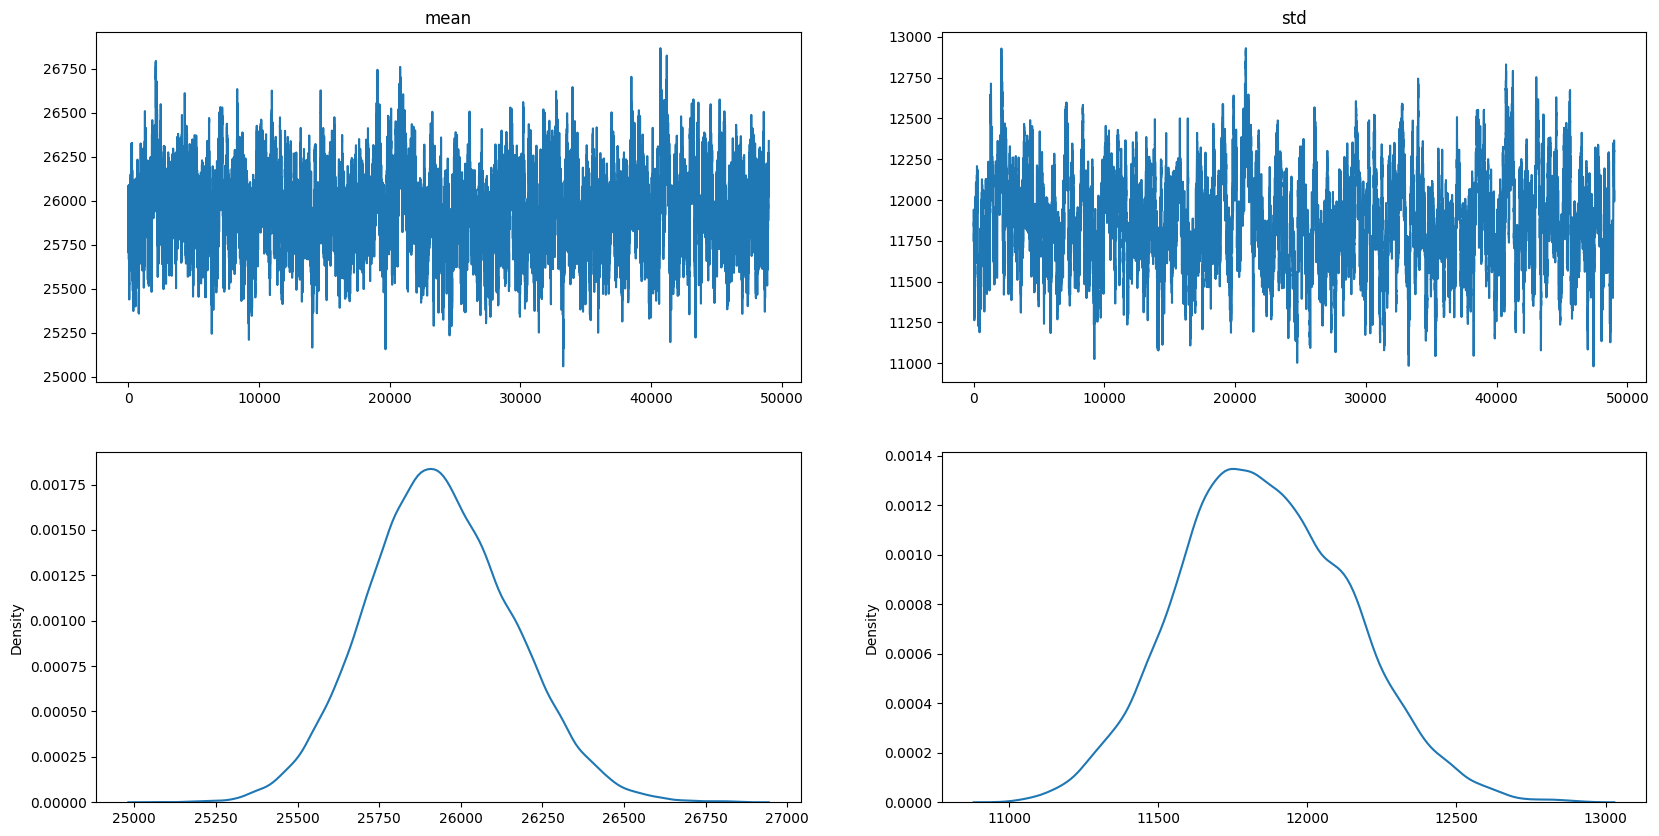

In [ ]:
display(Contes_fix_repar_tln,burnin=1000)

Fixed Reparametrized Translated LogNormal:
loc = 6389.64 scale = 9.72379802708665 shape = 0.5596938045702589
mean = 25935.645569907134 std = 11856.77310344519


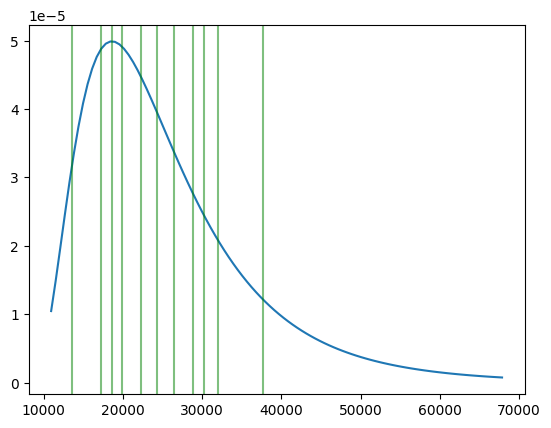

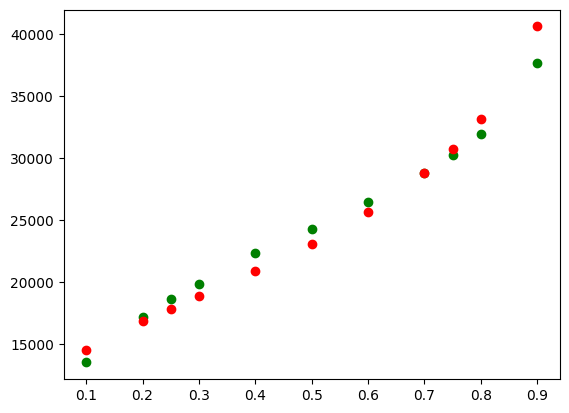

In [ ]:
loc = 6389.64
burnin = 1000
post_mean_fix_repar_tln_c = np.array(Reunion_fix_repar_tln["chains"]["mean"][burnin:])
post_std_fix_repar_tln_c = np.array(Reunion_fix_repar_tln["chains"]["std"][burnin:])

Y_tln = np.array(Reunion_fix_repar_tln["X"][burnin:])

post_scale_fix_repar_tln_c = np.log((post_mean_fix_repar_tln_c-loc)**2/np.sqrt((post_mean_fix_repar_tln_c-loc)**2+(post_std_fix_repar_tln_c)**2))
post_shape_fix_repar_tln_c = np.sqrt(np.log(1+np.power(post_std_fix_repar_tln_c,2)/np.power(post_mean_fix_repar_tln_c-loc,2)))

law_fix_repar_tnl = lognorm(s=np.mean(post_shape_fix_repar_tln_c), scale=np.mean(np.exp(post_scale_fix_repar_tln_c)),loc=loc)
print("Fixed Reparametrized Translated LogNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_tln_c),np.mean(post_shape_fix_repar_tln_c),np.mean(post_mean_fix_repar_tln_c),np.mean(post_std_fix_repar_tln_c)))
x=np.linspace(law_fix_repar_tnl.ppf(0.01),law_fix_repar_tnl.ppf(0.99), 100)
plt.plot(x,law_fix_repar_tnl.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_fix_repar_tnl.ppf(P),color="red")



## Fixed Translated GP

In [ ]:
from RobustGibbsObject.Model import FixedReparametrizedGeneralizedParetoModel

In [ ]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_gp = FixedReparametrizedGeneralizedParetoModel(mean,std)

Contes_fix_repar_gp = fix_repar_gp.Gibbs_Quantile(200000,N_contes,Q_contes,P,std_prop_dict={"mean":10,"std":5},std_prop_quantile=.01,List_X=True)

Init...
{'mean': 25000, 'std': 10000}
Init done! {'mean': 25000, 'std': 10000}


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [08:58<00:00, 92.82it/s] 


Acceptance rate of Q 0 = 66.30%
Acceptance rate of Q 1 = 54.36%
Acceptance rate of Q 2 = 47.59%
Acceptance rate of Q 3 = 41.93%
Acceptance rate of Q 4 = 25.59%
Acceptance rate of Q 5 = 27.51%
Acceptance rate of Q 6 = 42.60%
Acceptance rate of Q 7 = 51.39%
Acceptance rate of Q 8 = 63.47%
Acceptance rate of Q 9 = 54.61%
Acceptation rates MH : mean = 55.41% std = 29.45% 


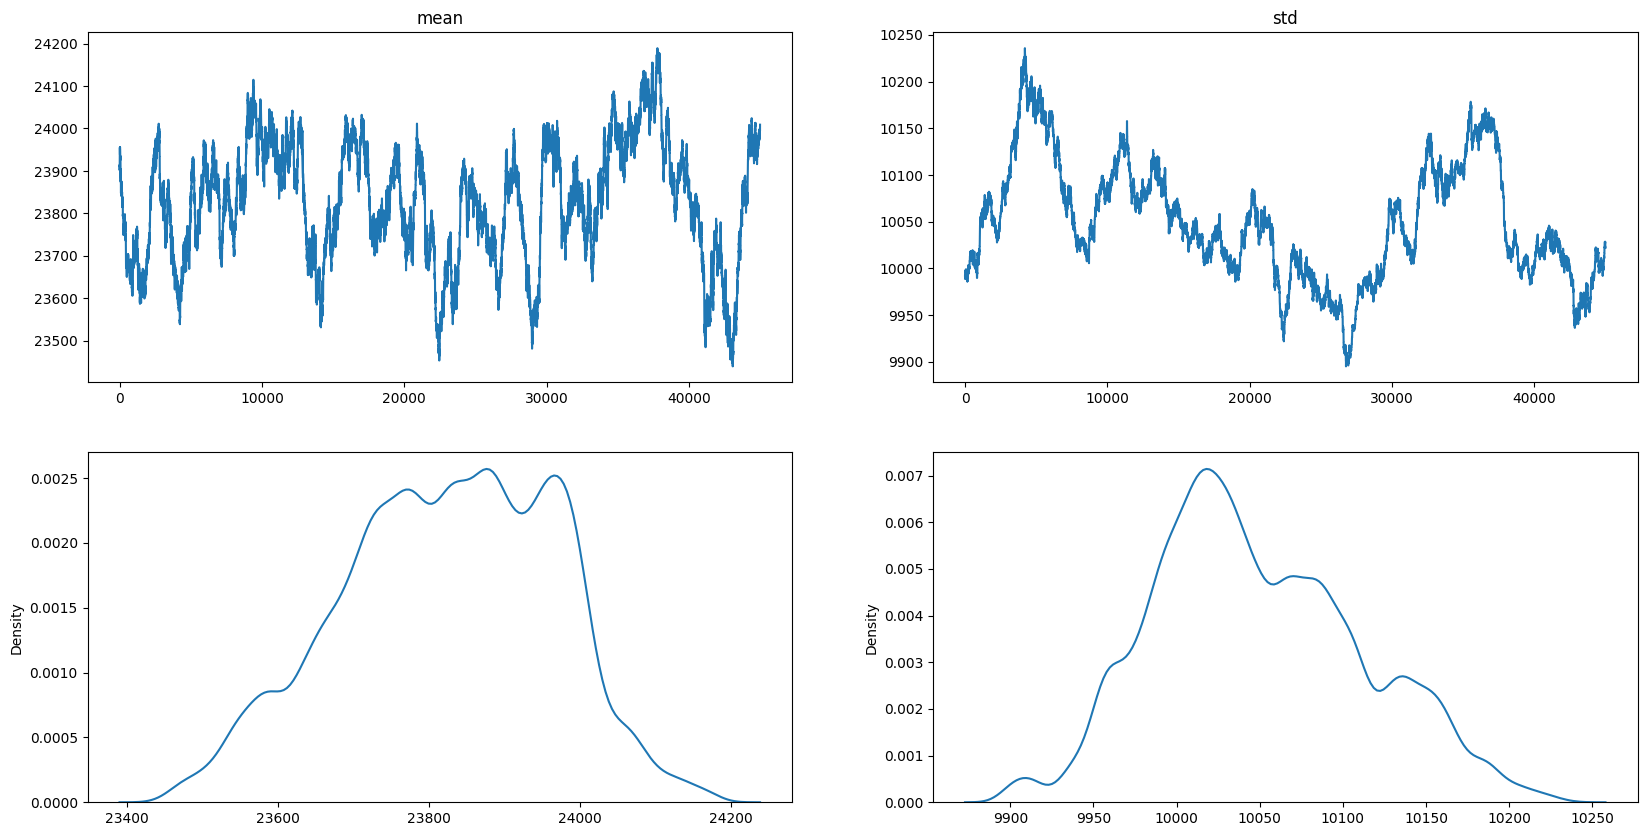

In [234]:
display(Reunion_fix_repar_gp,burnin=5000)

Fixed Reparametrized Generalized Pareto:
loc = 6389.64 scale = 34966.33144036461 shape = -1.0053684124790032
mean = 23824.73407512773 std = 10048.783924351437


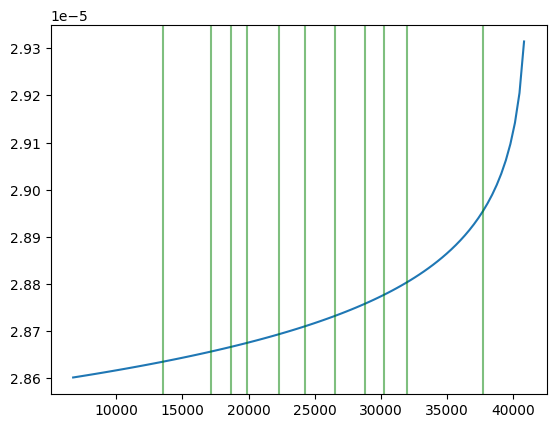

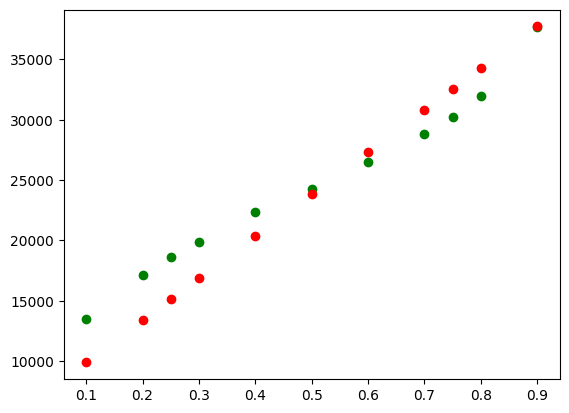

In [ ]:
loc= 6389.64
burnin=5000
post_mean_fix_repar_gp_c = np.array(Reunion_fix_repar_gp["chains"]["mean"][burnin:])
post_std_fix_repar_gp_c = np.array(Reunion_fix_repar_gp["chains"]["std"][burnin:])

Y_gp = np.array(Reunion_fix_repar_gp["X"][burnin:])

post_scale_fix_repar_gp_c = ((post_mean_fix_repar_gp_c-loc)/2+(post_mean_fix_repar_gp_c-loc)**3/(2*post_std_fix_repar_gp_c**2))
post_shape_fix_repar_gp_c = 1/2-(post_mean_fix_repar_gp_c-loc)**2/(2*post_std_fix_repar_gp_c**2)

law_fix_repar_gp = genpareto(c=np.mean(post_shape_fix_repar_gp_c), scale=np.mean(post_scale_fix_repar_gp_c),loc=loc)
print("Fixed Reparametrized Generalized Pareto:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_gp_c),np.mean(post_shape_fix_repar_gp_c),np.mean(post_mean_fix_repar_gp_c),np.mean(post_std_fix_repar_gp_c)))
x=np.linspace(law_fix_repar_gp.ppf(0.01),law_fix_repar_gp.ppf(0.99), 100)
plt.plot(x,law_fix_repar_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_fix_repar_gp.ppf(P),color="red")


## Fixed Translated P2

In [ ]:
from RobustGibbsObject.Model import FixedReparametrizedParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [ ]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_p2 = FixedReparametrizedParetoType2Model(mean,std)

Contes_fix_repar_p2 = fix_repar_p2.Gibbs_Quantile(100000,N_contes,Q_contes,P,std_prop_dict={"mean":10,"std":5},std_prop_quantile=.01,List_X=True)

Init...
17377.891251474488 24570.476752144088
{'mean': 17377.891251474488, 'std': 24570.476752144088}
Init done! {'mean': 17377.891251474488, 'std': 24570.476752144088}


  6%|▌         | 6053/100000 [00:08<02:05, 745.75it/s]/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Distribution.py:427: RuntimeWarning: invalid value encountered in log
  return np.where(x>=self.loc,np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale),-np.inf)
100%|██████████| 100000/100000 [02:16<00:00, 734.70it/s]


Acceptance rate of Q 0 = 77.47%
Acceptance rate of Q 1 = 64.15%
Acceptance rate of Q 2 = 54.66%
Acceptance rate of Q 3 = 47.09%
Acceptance rate of Q 4 = 26.33%
Acceptance rate of Q 5 = 21.03%
Acceptance rate of Q 6 = 26.63%
Acceptance rate of Q 7 = 28.63%
Acceptance rate of Q 8 = 33.15%
Acceptance rate of Q 9 = 42.95%
Acceptation rates MH : mean = 78.03% std = 87.81% 


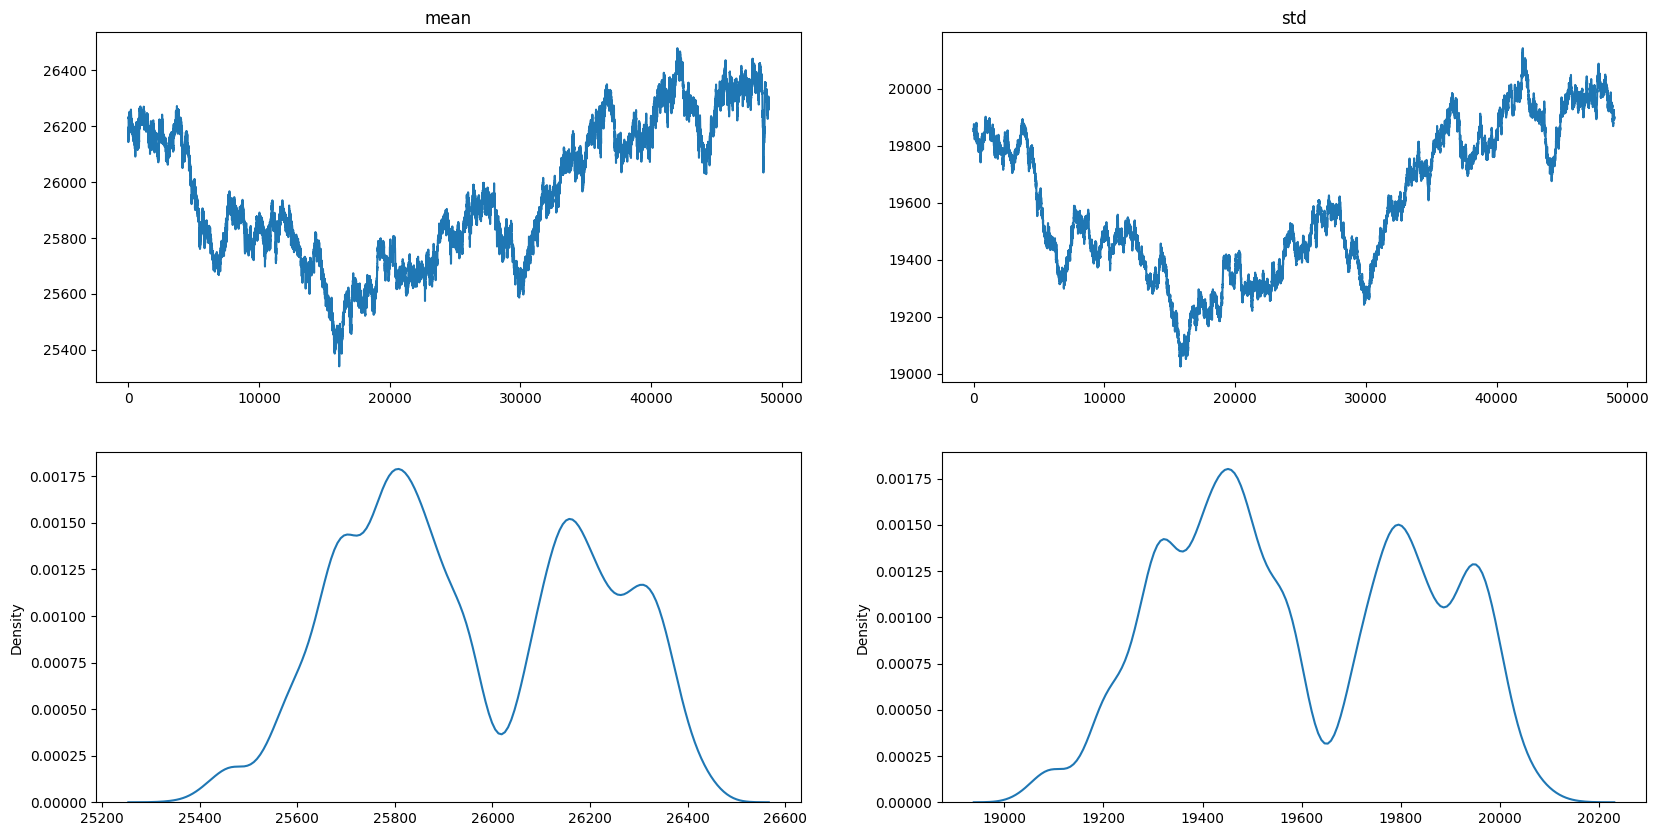

In [237]:
display(Contes_fix_repar_p2,burnin=51000)

Fixed Reparametrized Pareto Type 2:
loc = 6389.64 scale = 249556027.78051674 shape = 12813.268078680692
mean = 25958.642616943005 std = 19593.626594256926


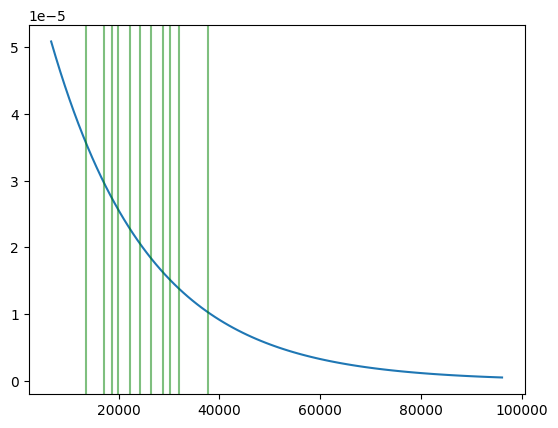

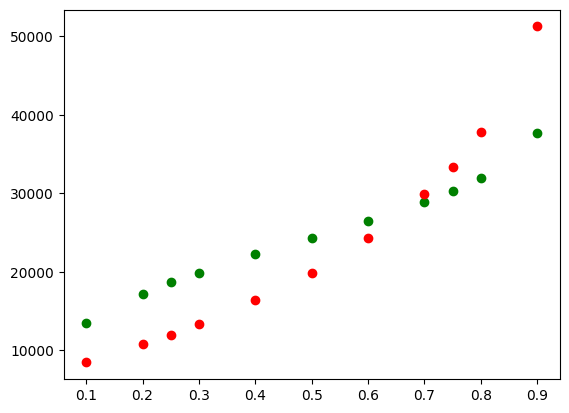

In [238]:
burnin=51000
post_mean_fix_repar_p2_c = np.array(Contes_fix_repar_p2["chains"]["mean"][burnin:])
post_std_fix_repar_p2_c = np.array(Contes_fix_repar_p2["chains"]["std"][burnin:])
loc = 6389.64
Y_p2 = np.array(Contes_fix_repar_gp["X"][burnin:])
post_scale_fix_repar_p2_c = ((post_mean_fix_repar_p2_c-loc)*(post_std_fix_repar_p2_c**2+(post_mean_fix_repar_p2_c-loc)**2)/(post_std_fix_repar_p2_c**2-(post_mean_fix_repar_p2_c-loc)**2))

post_shape_fix_repar_p2_c = 2*post_std_fix_repar_p2_c**2/(post_std_fix_repar_p2_c**2-(post_mean_fix_repar_p2_c-loc)**2)

print("Fixed Reparametrized Pareto Type 2:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_p2_c),np.mean(post_shape_fix_repar_p2_c),np.mean(post_mean_fix_repar_p2_c),np.mean(post_std_fix_repar_p2_c)))
law_fix_repar_p2 = pareto2(loc=loc,scale=np.mean(post_scale_fix_repar_p2_c),shape=np.mean(post_shape_fix_repar_p2_c))
x=np.linspace(law_fix_repar_p2.ppf(0.01),law_fix_repar_p2.ppf(0.99), 100)
plt.plot(x,law_fix_repar_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_contes,color="green")
plt.scatter(P,law_fix_repar_p2.ppf(P),color="red")


# Comparison

In [250]:
print("LOG NORMAL\nNormal:\nscale = {} shape = {}\nmean = {} std = {}\n\nTranslated:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n\nTranslated reparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n".format(np.mean(post_scale_ln_c),np.mean(post_shape_ln_c),np.mean(np.exp(post_scale_ln_c)),np.mean(np.exp(post_scale_ln_c)),np.mean(post_loc_tln_c),np.mean(post_scale_tln_c),np.mean(post_shape_tln_c),law_tln.mean(),law_tln.std(),np.mean(post_loc_repar_tln_c),np.mean(post_scale_repar_tln_c),np.mean(post_shape_repar_tln_c),np.mean(post_mean_repar_tln_c),np.mean(post_std_repar_tln_c)))
print("Fixed translated reparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_tln_c),np.mean(post_shape_fix_repar_tln_c),np.mean(post_mean_fix_repar_tln_c),np.mean(post_std_fix_repar_tln_c)))

LOG NORMAL
Normal:
scale = 10.068201344081682 shape = 0.39020483994604654
mean = 23581.732942369494 std = 23581.732942369494

Translated:
loc = 1184.0906306450315 scale = 10.013499203856787 shape = 0.4129156398278612
mean = 25496.662748998806 std = 10482.549571770436

Translated reparametrized:
loc = 1224.052395175211 scale = 10.011665550865017 shape = 0.4138078409304721
mean = 25505.526828615253 std = 10492.073137148016

Fixed translated reparametrized:
loc = 6389.64 scale = 9.72379802708665 shape = 0.5596938045702589
mean = 25935.645569907134 std = 11856.77310344519


In [251]:
print("GENRALIZED PARETO:\nNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n\nReparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n".format(np.mean(post_loc_gp_c),np.mean(post_scale_gp_c),np.mean(post_shape_gp_c),law_gp.mean(),law_gp.std(),np.mean(post_loc_repar_gp_c),np.mean(post_scale_repar_gp_c),np.mean(post_shape_repar_gp_c),np.mean(post_mean_repar_gp_c),np.mean(post_std_repar_gp_c)))

print("Fixed reparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_gp_c),np.mean(post_shape_fix_repar_gp_c),np.mean(post_mean_fix_repar_gp_c),np.mean(post_std_fix_repar_gp_c)))

GENRALIZED PARETO:
Normal:
loc = 11198.086865789473 scale = 22784.785310012026 shape = -0.684059904768414
mean = 24727.76312344333 std = 8791.957284704613

Reparametrized:
loc = 11150.748404375154 scale = 22860.008671836873 shape = -0.6846287883381434
mean = 24717.039478089202 std = 8814.741046483528

Fixed reparametrized:
loc = 6389.64 scale = 34966.33144036461 shape = -1.0053684124790032
mean = 23824.73407512773 std = 10048.783924351437


In [252]:
print("PARETO TYPE II:\nNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n\nReparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}\n".format(np.mean(post_loc_p2_c),np.mean(post_scale_p2_c),np.mean(post_shape_p2_c),law_p2.mean(),law_p2.std(),np.mean(post_loc_repar_p2_c),np.mean(post_scale_repar_p2_c),np.mean(post_shape_repar_p2_c),np.mean(post_mean_repar_p2_c),np.mean(post_std_repar_p2_c)))

print("Fixed reparametrized:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_p2_c),np.mean(post_shape_fix_repar_p2_c),np.mean(post_mean_fix_repar_p2_c),np.mean(post_std_fix_repar_p2_c)))

PARETO TYPE II:
Normal:
loc = 12057.433614215564 scale = 1010481.1225630274 shape = 72.89998406194775
mean = 26111.416181060293 std = 14250.826686936405

Reparametrized:
loc = 10998.366358511601 scale = 146376652.42228487 shape = 10864.960106651706
mean = 24486.166628017938 std = 13500.53219123775

Fixed reparametrized:
loc = 6389.64 scale = 249556027.78051674 shape = 12813.268078680692
mean = 25958.642616943005 std = 19593.626594256926


# Bayes Factor

## Translated LogNorm / Generalized Pareto

In [ ]:
#

# Inférence Reunion

In [ ]:
from RobustGibbsObject.Distribution import Gamma

## Weibull 

In [ ]:
from RobustGibbsObject.Model import WeibullModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [36]:
scale = Gamma(10000,10)
shape = Gamma(10,1)

weibull = WeibullModel(scale=scale,shape=shape)

Reunion_w = weibull.Gibbs_Quantile(10000,N_reunion,Q_reunion,P,std_prop_dict={"scale":100,"shape":.1},std_prop_quantile=0.01,verbose=True)

Init...
Init done! {'scale': 20563.629041602373, 'shape': 1.5}


100%|██████████| 10000/10000 [00:37<00:00, 267.23it/s]


Acceptation rates MH : scale = 83.88% shape = 25.34% 


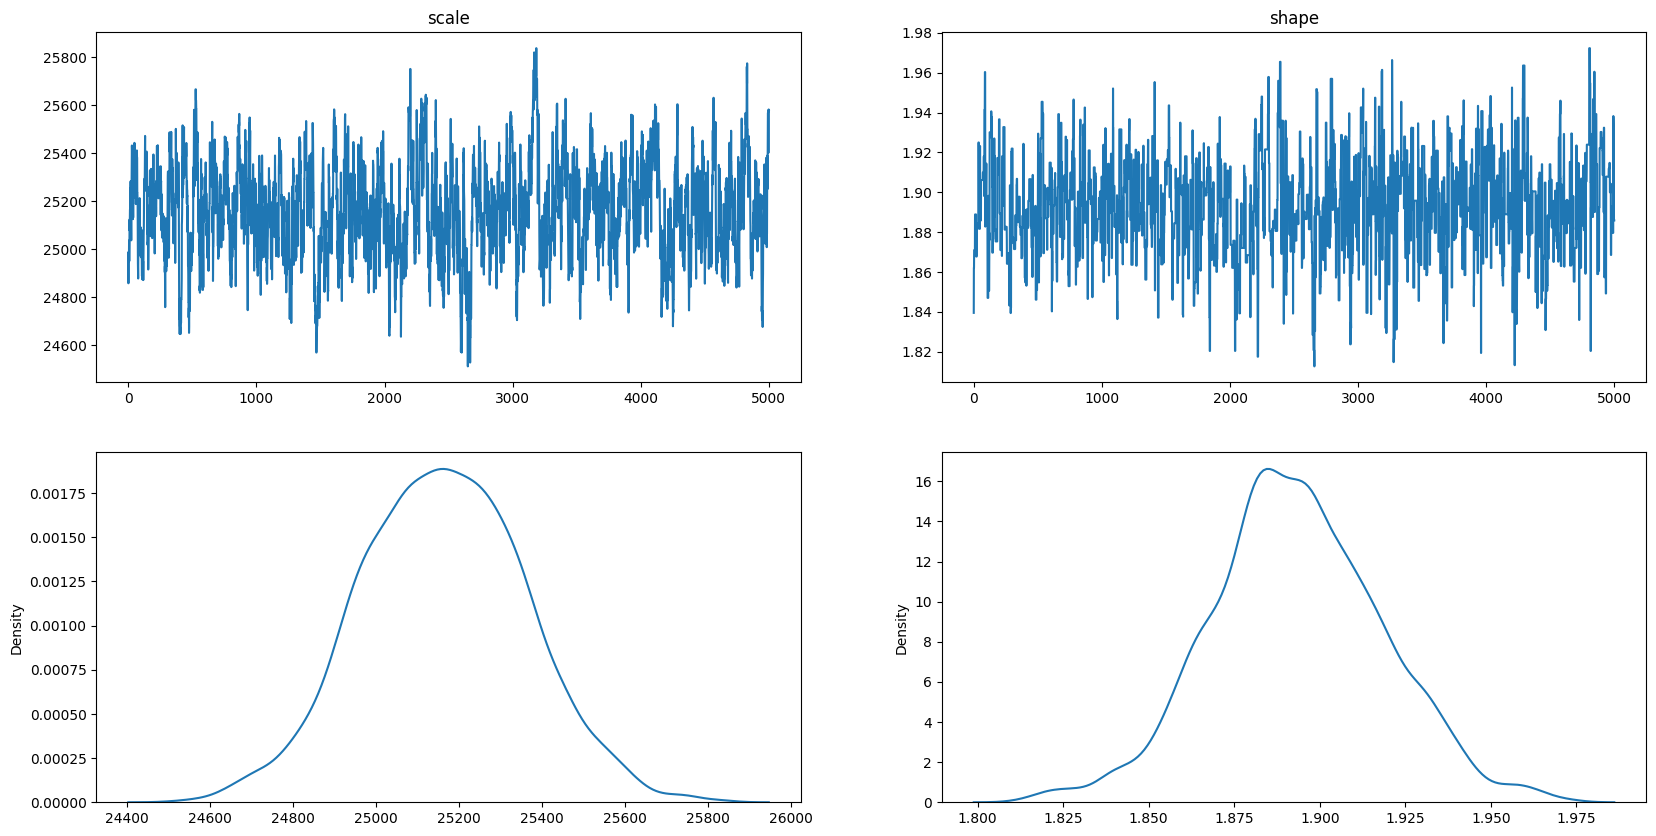

In [37]:
display(Reunion_w,burnin=5000)

In [ ]:
post_mean_

Weibull :
scale = 25160.945305503767 shape = 1.8932156542037282
mean = 22329.496841951615 std = 12263.873242897625


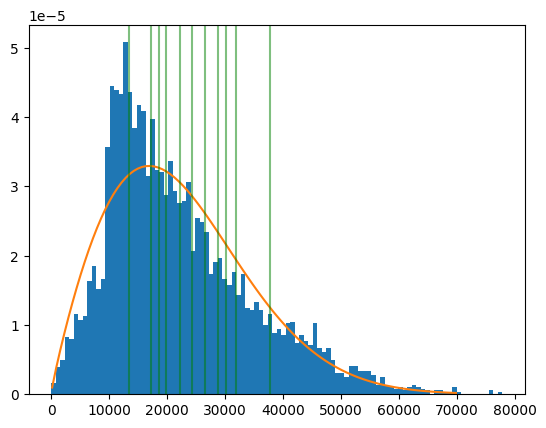

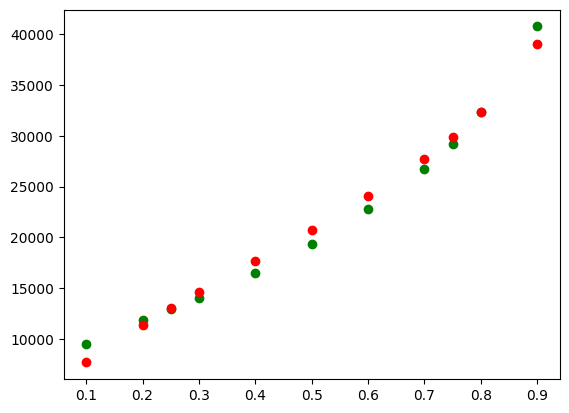

In [38]:
burnin = 5000
post_scale_w_r = np.array(Reunion_w["chains"]["scale"][burnin:])
post_shape_w_r = np.array(Reunion_w["chains"]["shape"][burnin:])

law_w = weibull_min(c=np.mean(post_shape_w_r),scale=np.mean(post_scale_w_r))
print("Weibull :\nscale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_scale_w_r),np.mean(post_shape_w_r),law_w.mean(),law_w.std()))

x = np.linspace(law_w.ppf(0.0001),law_w.ppf(0.999), 100)
plt.hist(Reunion_w["X"][-1],density=True,bins=100)
plt.plot(x, law_w.pdf(x), label="Weibull")
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_w.ppf(P),color="red")
plt.show()


## Translated Weibull

In [40]:
from RobustGibbsObject.Model import TranslatedWeibullModel

In [39]:
loc = Gamma(10000,10)
scale = Gamma(1000,10)
shape = Gamma(10,10)

trans_weibull = TranslatedWeibullModel(loc=loc,scale=scale,shape=shape)

Reunion_tw = trans_weibull.Gibbs_Quantile(10000,N_reunion,Q_reunion,P,std_prop_dict={"loc":300,"scale":300,"shape":.1},std_prop_quantile=0.01,verbose=True)


Init...
Init done! {'loc': 7130.0, 'scale': 20563.629041607142, 'shape': 1.5}


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:48<00:00, 205.46it/s]

Acceptation rates MH : loc = 4.46% scale = 60.68% shape = 16.64% 


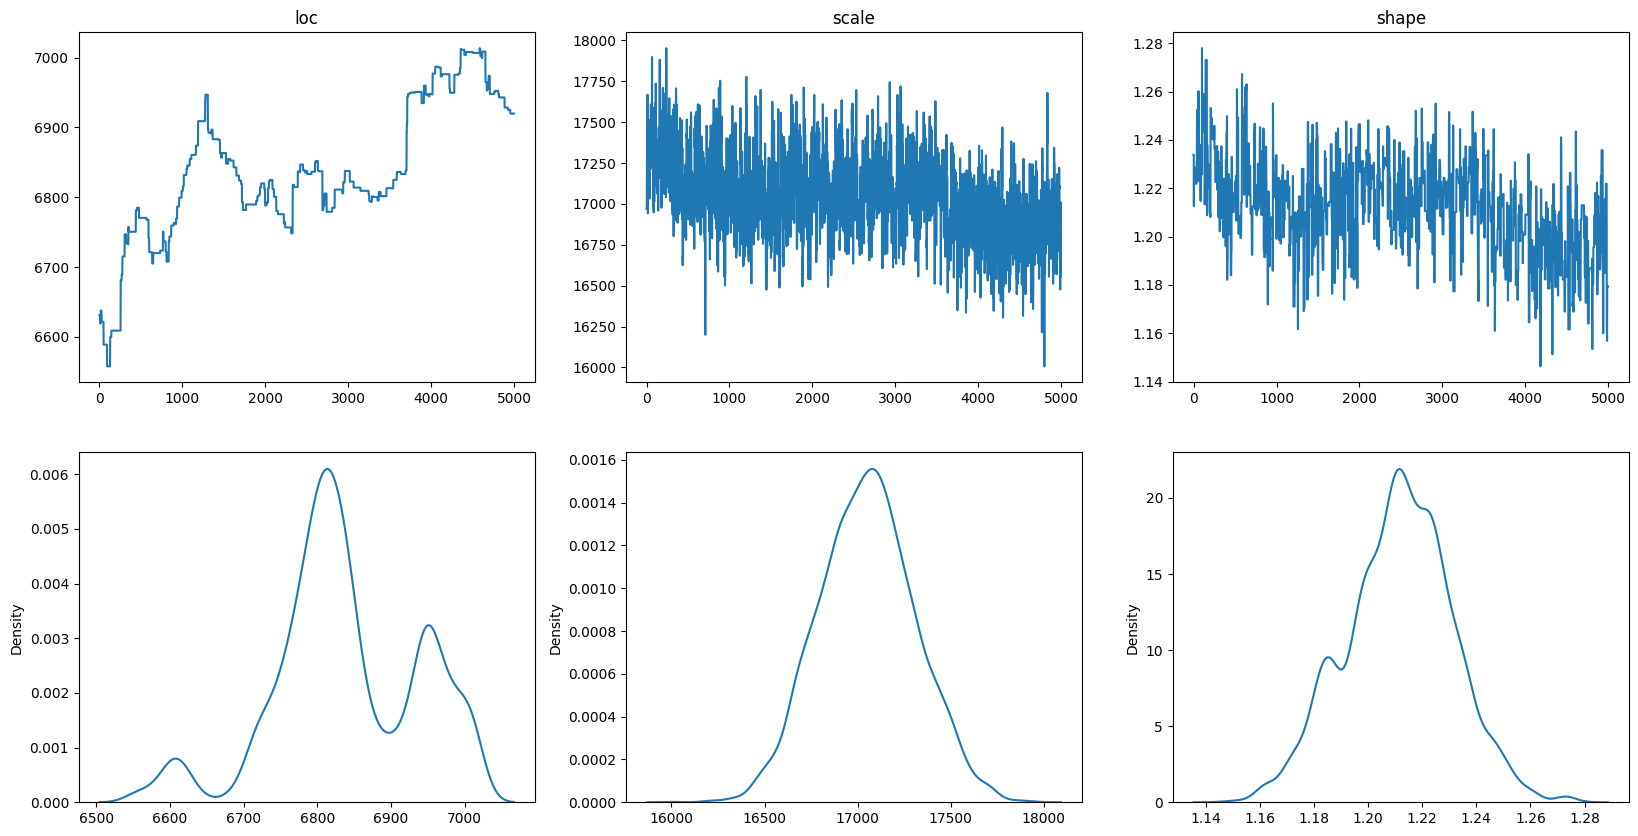

In [41]:
display(Reunion_tw,burnin=5000)

In [43]:
import scipy

Translated Weibull :
loc = 6838.343392339491 scale = 17052.35334485249 shape = 1.211526743929885
mean = 22839.818370369394 std = 13269.968881221486
Mode =  11091.762487582611


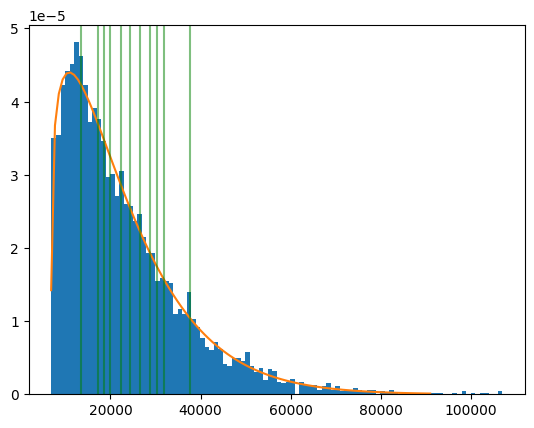

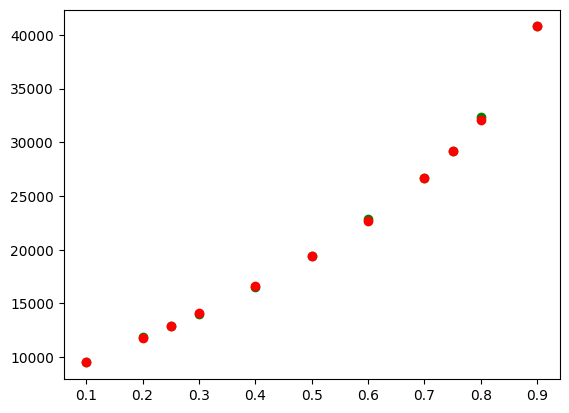

In [44]:
burnin = 5000
post_loc_tw_r = np.array(Reunion_tw["chains"]["loc"][burnin:])
post_scale_tw_r = np.array(Reunion_tw["chains"]["scale"][burnin:])
post_shape_tw_r = np.array(Reunion_tw["chains"]["shape"][burnin:])

post_mean_tw = post_loc_tw_r + post_scale_tw_r * scipy.special.gamma(1+1/(post_shape_tw_r))
post_std_tw = post_scale_tw_r * np.sqrt(scipy.special.gamma(1+2/(post_shape_tw_r))-(scipy.special.gamma(1+1/(post_shape_tw_r)))**2)
law_tw = weibull_min(c=np.mean(post_shape_tw_r),scale=np.mean(post_scale_tw_r),loc=np.mean(post_loc_tw_r))
print("Translated Weibull :\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_tw_r),np.mean(post_scale_tw_r),np.mean(post_shape_tw_r),law_tw.mean(),law_tw.std()))

x = np.linspace(law_tw.ppf(0.0001),law_tw.ppf(0.999), 100)

plt.hist(Reunion_tw["X"][-1],density=True,bins=100)
plt.plot(x, law_tw.pdf(x), label="Translated Weibull")
print("Mode = ",x[np.argmax(law_tw.pdf(x))])
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_tw.ppf(P),color="red")
plt.show()


## LogNormal

In [45]:
from RobustGibbsObject.Model import LogNormalModel

In [48]:
from scipy.stats import lognorm

In [214]:
scale = Gamma(10,1, name="scale")
shape = Gamma(1,1, name="shape")

lognormm = LogNormalModel(scale,shape)


Reunion_ln = lognormm.Gibbs_Quantile(100000,N_reunion,Q_reunion,P,std_prop_dict={"scale":.01,"shape":.01})

Init...
Init done! {'scale': 9.569412440514636, 'shape': 0.38606524461163855}


100%|██████████| 100000/100000 [11:36<00:00, 143.67it/s]


Acceptance rate of Q 0 = 5.68%
Acceptance rate of Q 1 = 6.62%
Acceptance rate of Q 2 = 6.00%
Acceptance rate of Q 3 = 6.55%
Acceptance rate of Q 4 = 7.66%
Acceptance rate of Q 5 = 9.38%
Acceptance rate of Q 6 = 9.77%
Acceptance rate of Q 7 = 7.67%
Acceptance rate of Q 8 = 7.67%
Acceptance rate of Q 9 = 7.97%
Acceptance rate of Q 10 = 5.49%
Acceptation rates MH : scale = 71.09% shape = 61.21% 


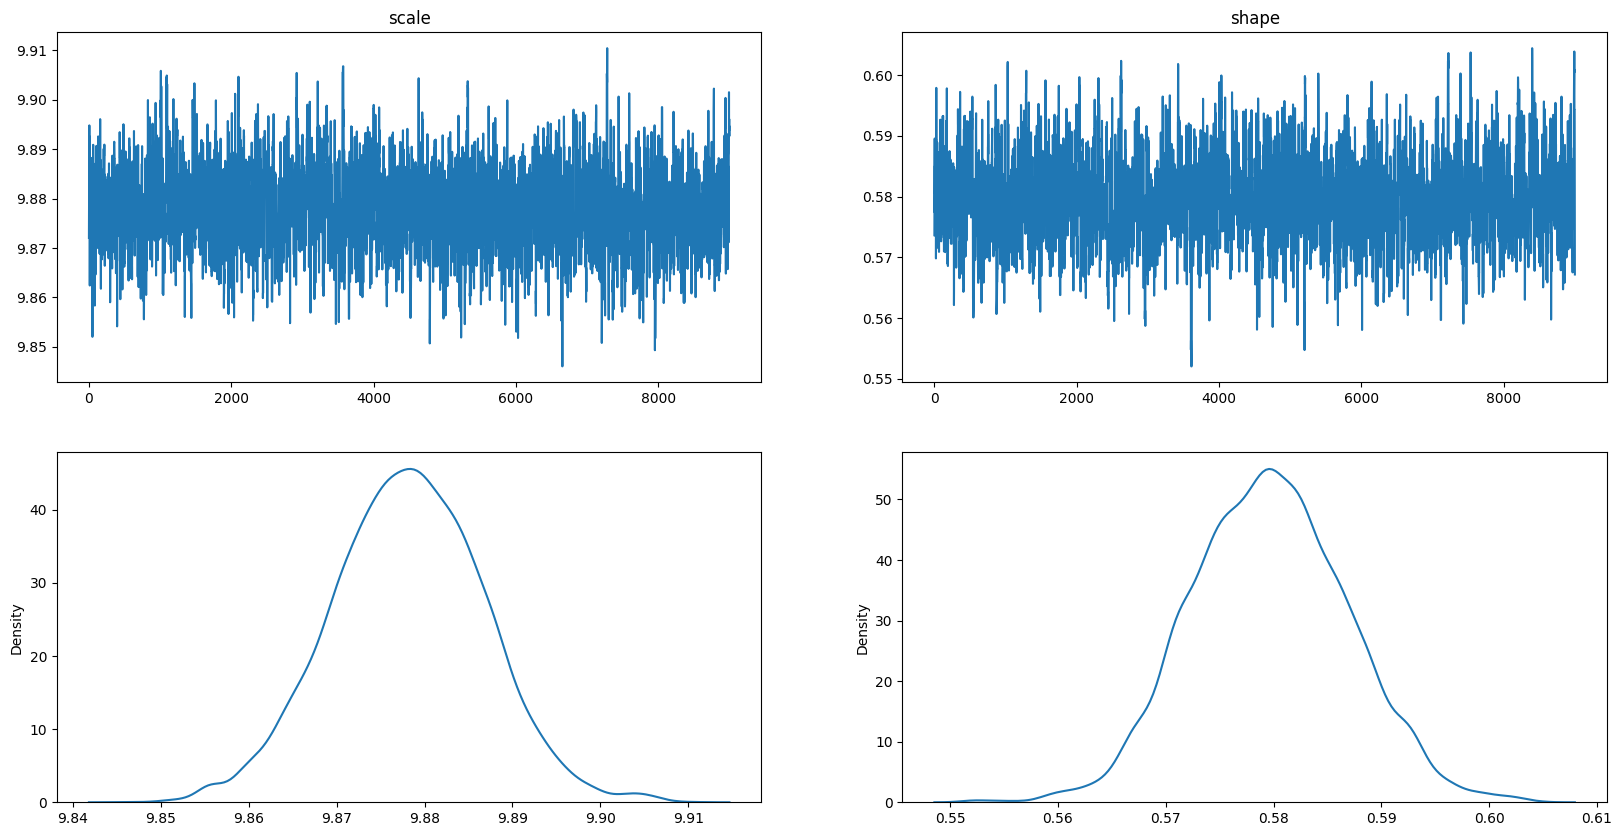

In [47]:
display(Reunion_ln,burnin=1000)

LogNormal:
scale = 9.878103611680986 shape = 0.5796090865186996


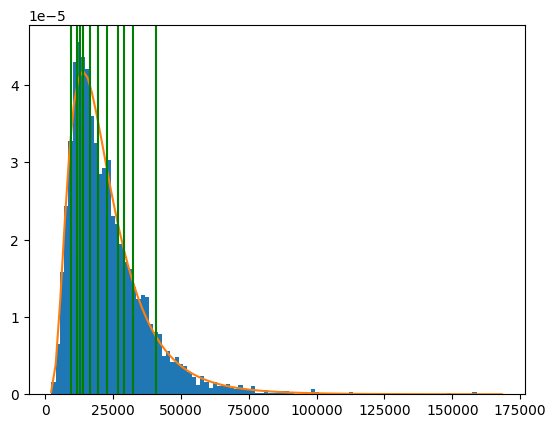

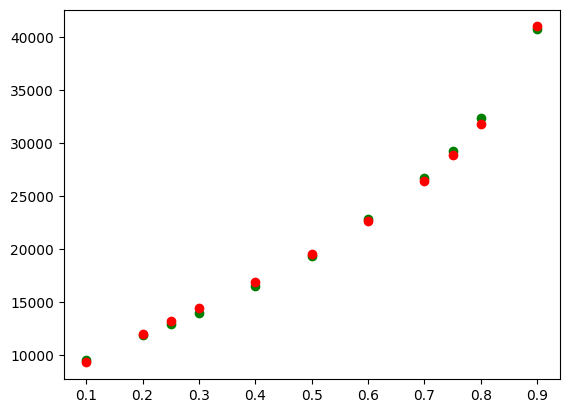

In [49]:
post_scale_ln_r = Reunion_ln["chains"]["scale"][1000:]
post_shape_ln_r = Reunion_ln["chains"]["shape"][1000:]

print("LogNormal:\nscale = {} shape = {}".format(np.mean(post_scale_ln_r),np.mean(post_shape_ln_r)))

law_ln = lognorm(s=np.mean(post_shape_ln_r), scale=np.mean(np.exp(post_scale_ln_r)))
x = np.linspace(law_ln.ppf(0.0001),law_ln.ppf(0.9999), 100)
plt.hist(Reunion_ln["X"][-1],density=True,bins=100);
plt.plot(x,law_ln.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color = "green")
plt.show()

plt.scatter(P,Q_reunion,color = "green")
plt.scatter(P,law_ln.ppf(P),color = "red")



## Translated LogNormal

In [50]:
from RobustGibbsObject.Model import TranslatedLogNormalModel

In [51]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(10,3, name="scale")
shape = Gamma(1,1,name="shape")

trans_lognorm = TranslatedLogNormalModel(loc,scale,shape)


Reunion_tln = trans_lognorm.Gibbs_Quantile(10000,N_reunion,Q_reunion,P,std_prop_dict={"loc":100,"scale":.1,"shape":.1},std_prop_quantile=.01)

Init...
{'loc': 7130.0, 'scale': 9.871480756401041, 'shape': 0.4855751775312018}
Init done! {'loc': 7130.0, 'scale': 9.871480756401041, 'shape': 0.4855751775312018}


  0%|          | 0/10000 [00:00<?, ?it/s]

/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:224: RuntimeWarning: overflow encountered in exp
  ratio = np.exp(proposed_llikelihood - current_llikelihood + proposed_lprior - current_lprior)
100%|██████████| 10000/10000 [00:47<00:00, 210.01it/s]

Acceptation rates MH : loc = 66.48% scale = 12.44% shape = 9.52% 


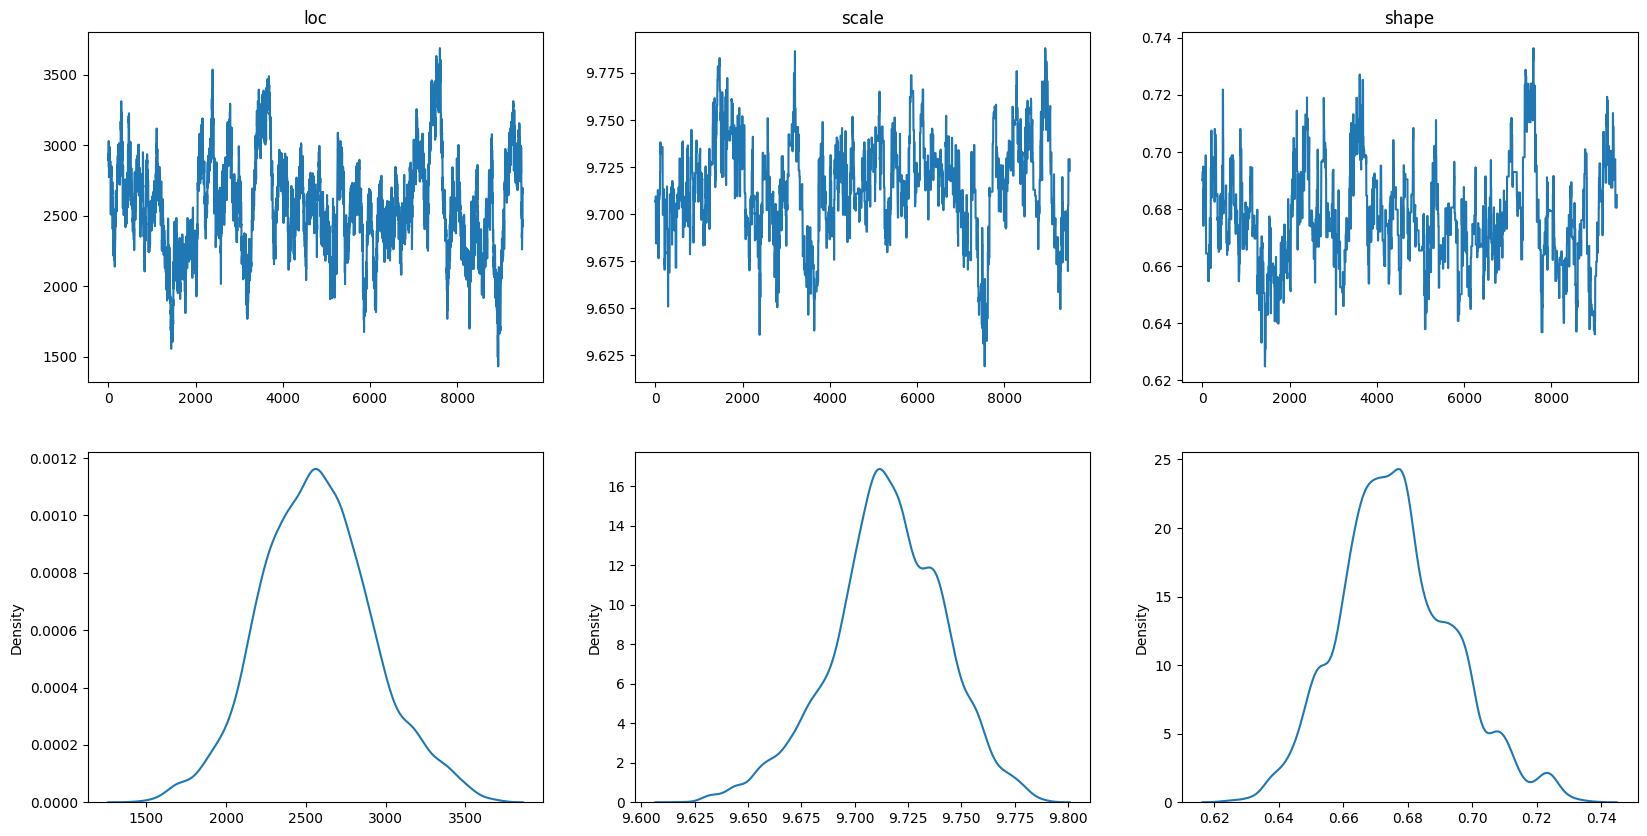

In [52]:
display(Reunion_tln,burnin=500)

Translated LogNormal:
loc = 2560.280782507828 scale = 9.715955138419789 shape = 0.5796090865186996


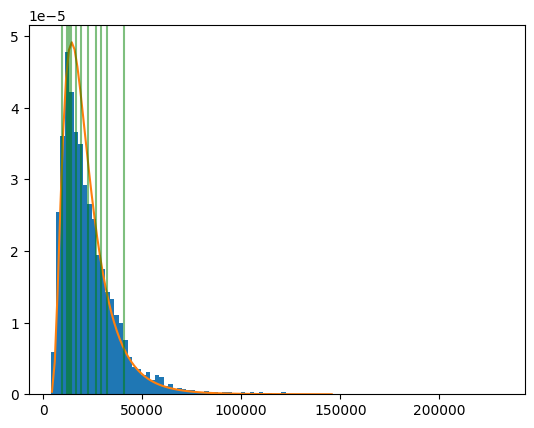

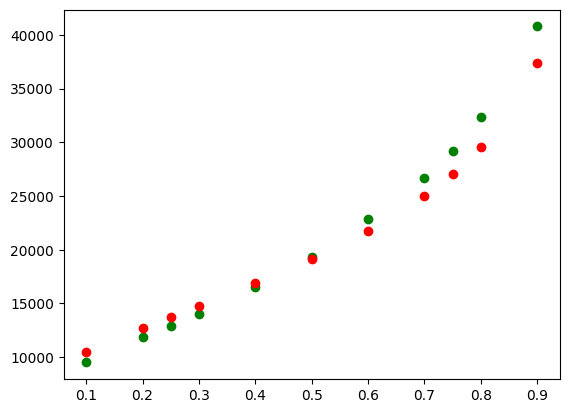

In [53]:
post_loc_tln_r = (Reunion_tln["chains"]["loc"][1000:])
post_scale_tln_r = (Reunion_tln["chains"]["scale"][1000:])
post_shape_tln_r = (Reunion_ln["chains"]["shape"][1000:])

print("Translated LogNormal:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_tln_r),np.mean(post_scale_tln_r),np.mean(post_shape_tln_r)))
law_tln = lognorm(s=np.mean(post_shape_tln_r), scale=np.exp(np.mean(post_scale_tln_r)),loc=np.mean(post_loc_tln_r))
x=np.linspace(law_tln.ppf(0.0001),law_tln.ppf(0.9999), 100)
plt.hist(Reunion_tln["X"][-1],bins=100,density=True);
plt.plot(x,law_tln.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_tln.ppf(P),color="red")


## Reparametrized Tranlated LogNormal

In [54]:
from RobustGibbsObject.Model import ReparametrizedTranslatedLogNormalModel
from RobustGibbsObject.Distribution import Gamma


In [55]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

trans_lognorm = ReparametrizedTranslatedLogNormalModel(loc,mean,std)


Reunion_repar_tln = trans_lognorm.Gibbs_Quantile(10000,N_reunion,Q_reunion,P,std_prop_dict={"loc":80,"mean":500,"std":500},std_prop_quantile=.05)

Init...
Init done! {'loc': 7130.0, 'mean': 28923.616459081994, 'std': 11237.98352192661}


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:48<00:00, 205.62it/s]

Acceptation rates MH : loc = 84.19% mean = 31.42% std = 40.25% 


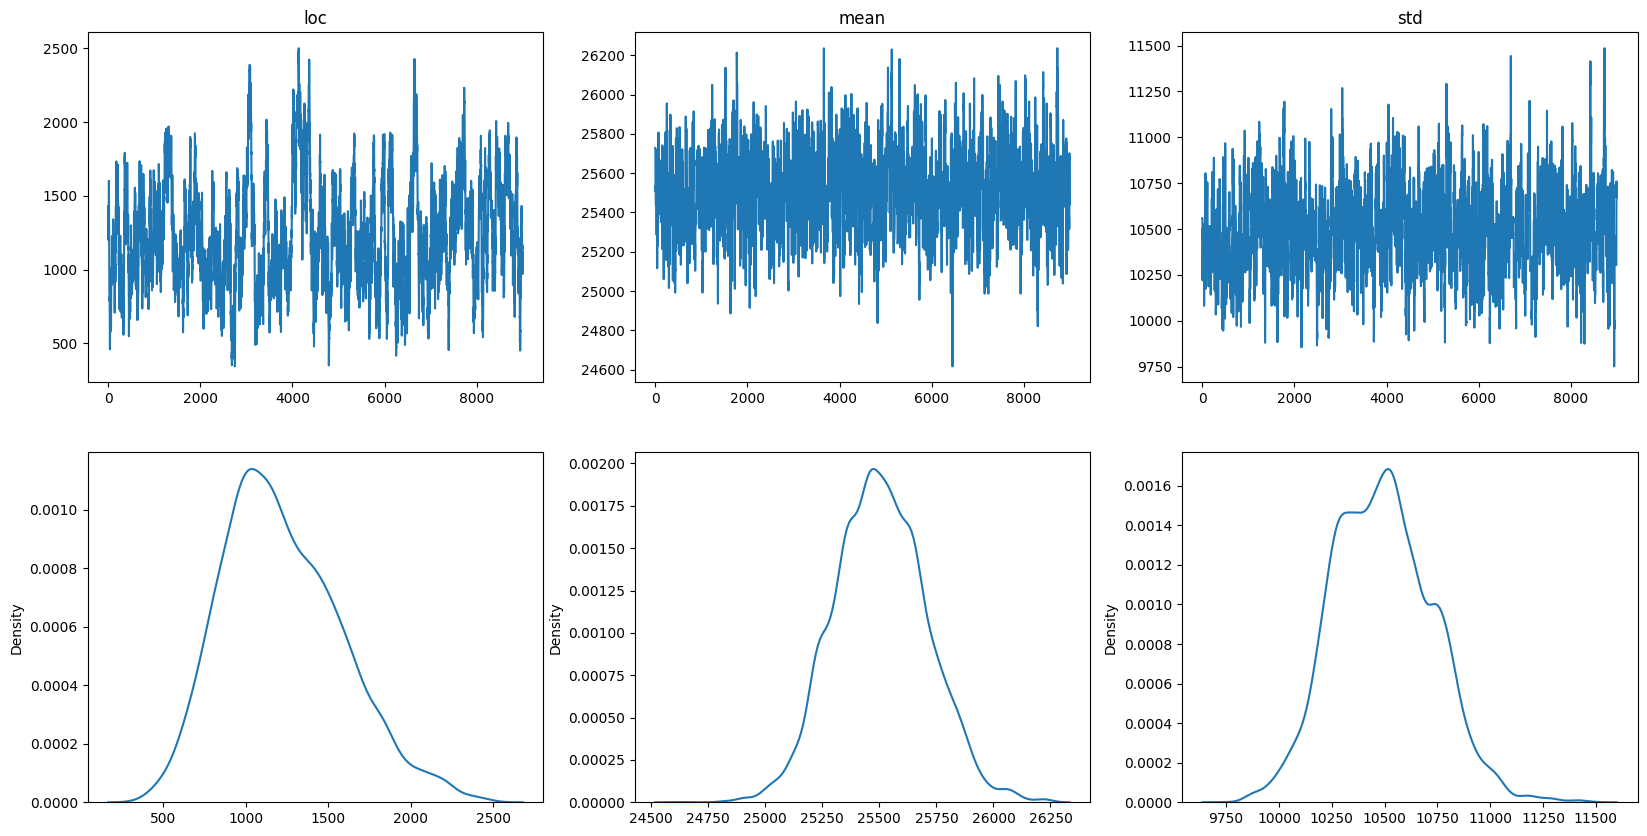

In [ ]:
display(Reunion_repar_tln,burnin=1000)

Reparametrized Translated LogNormal:
loc = 2488.5943192264285 scale = 9.721569003007456 shape = 0.6727887292718511
mean = 23404.86988009335 std = 15823.862376119283


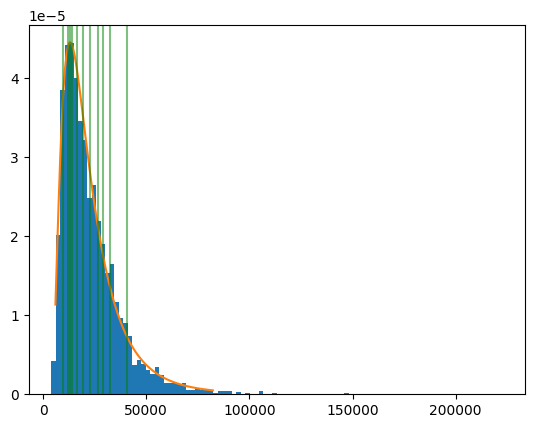

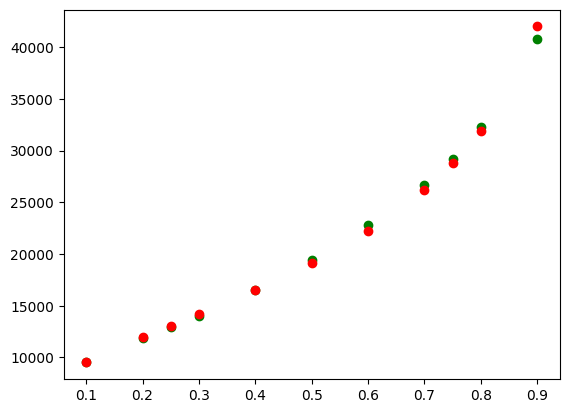

In [433]:
post_loc_repar_tln_r = np.array(Reunion_repar_tln["chains"]["loc"][1000:])
post_mean_repar_tln_r = np.array(Reunion_repar_tln["chains"]["mean"][1000:])
post_std_repar_tln_r = np.array(Reunion_repar_tln["chains"]["std"][1000:])

post_scale_repar_tln_r = np.log((post_mean_repar_tln_r-post_loc_repar_tln_r)**2/np.sqrt((post_mean_repar_tln_r-post_loc_repar_tln_r)**2+(post_std_repar_tln_r)**2))
post_shape_repar_tln_r = np.sqrt(np.log(1+np.power(post_std_repar_tln_r,2)/np.power(post_mean_repar_tln_r-post_loc_repar_tln_r,2)))

print("Reparametrized Translated LogNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_tln_r),np.mean(post_scale_repar_tln_r),np.mean(post_shape_repar_tln_r),np.mean(post_mean_repar_tln_r),np.mean(post_std_repar_tln_r)))

law_repar_tnl = lognorm(s=np.mean(post_shape_repar_tln_r), scale=np.mean(np.exp(post_scale_repar_tln_r)),loc=np.mean(post_loc_repar_tln_r))
x=np.linspace(law_repar_tnl.ppf(0.01),law_repar_tnl.ppf(0.99), 100)
plt.hist(Reunion_repar_tln["X"][-1],bins=100,density=True);
plt.plot(x,law_repar_tnl.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_repar_tnl.ppf(P),color="red")

## Generalized Pareto

In [ ]:
from RobustGibbsObject.Model import GeneralizedParetoModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [434]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(1000,25,name="scale")
shape = Normal(0,1, name="shape")

gen_par = GeneralizedParetoModel(loc,scale,shape)


Reunion_gp = gen_par.Gibbs_Quantile(50000,N_reunion,Q_reunion,P,std_prop_dict={"loc":10,"scale":400,"shape":.01},std_prop_quantile=.01,List_X=True)

Init...
Init done! {'loc': 7130.0, 'scale': 12591.929714880864, 'shape': 0.1}


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [04:35<00:00, 181.56it/s]


Acceptation rates MH : loc = 28.04% scale = 50.27% shape = 59.93% 


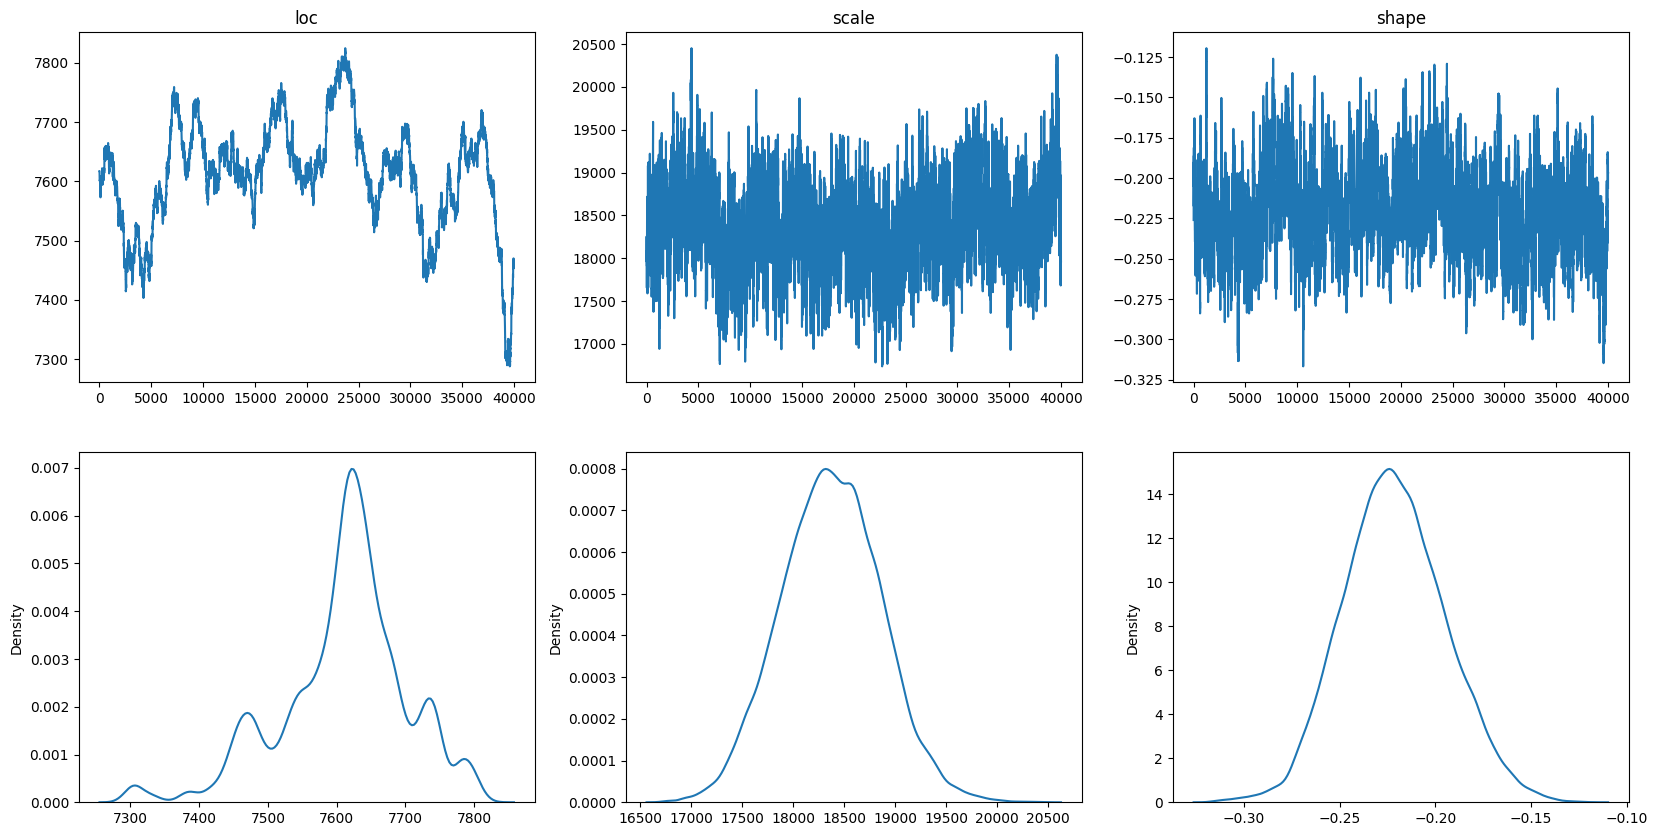

In [435]:
display(Reunion_gp,burnin=10000)

Generalized Pareto:
loc = 7610.960940005611 scale = 18371.266260676923 shape = -0.22130168764156227
mean = 22653.32634945117 std = 12523.988563739409


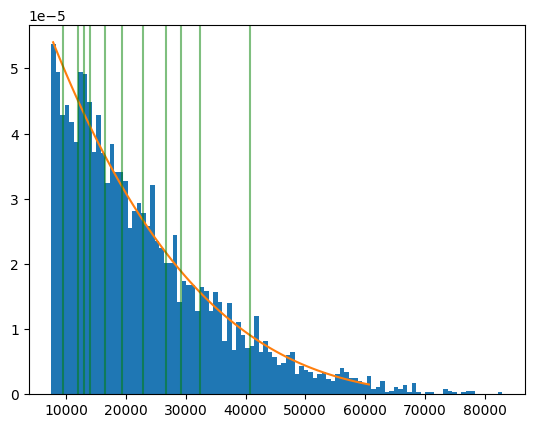

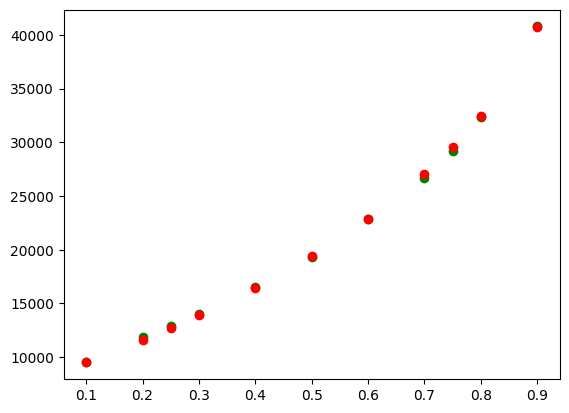

In [436]:
burnin=10000
post_loc_gp_r = np.array(Reunion_gp["chains"]["loc"][burnin:])
post_scale_gp_r = np.array(Reunion_gp["chains"]["scale"][burnin:])
post_shape_gp_r = np.array(Reunion_gp["chains"]["shape"][burnin:])
law_gp = genpareto(c=np.mean(post_shape_gp_r), scale=np.mean(post_scale_gp_r),loc=np.mean(post_loc_gp_r))
print("Generalized Pareto:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_gp_r),np.mean(post_scale_gp_r),np.mean(post_shape_gp_r)))
print("mean = {} std = {}".format(law_gp.mean(),law_gp.std()))
plt.hist(Reunion_gp["X"][-1],bins=100,density=True);
x=np.linspace(law_gp.ppf(0.01),law_gp.ppf(0.99), 100)
plt.plot(x,law_gp.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_gp.ppf(P),color="red")


## Reparametrized Generalized Pareto

In [ ]:
from RobustGibbsObject.Model import ReparametrizedGeneralizedParetoModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [437]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

repar_gen_par = ReparametrizedGeneralizedParetoModel(loc,mean,std)

Reunion_repar_gp = repar_gen_par.Gibbs_Quantile(50000,N_reunion,Q_reunion,P,std_prop_dict={"loc":10,"mean":65,"std":12},std_prop_quantile=.05)


Init...
Init done! {'loc': 7130.0, 'mean': 21121.033016534293, 'std': 14078.205405186578}


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [04:30<00:00, 185.00it/s]


Acceptation rates MH : loc = 27.67% mean = 82.61% std = 95.58% 


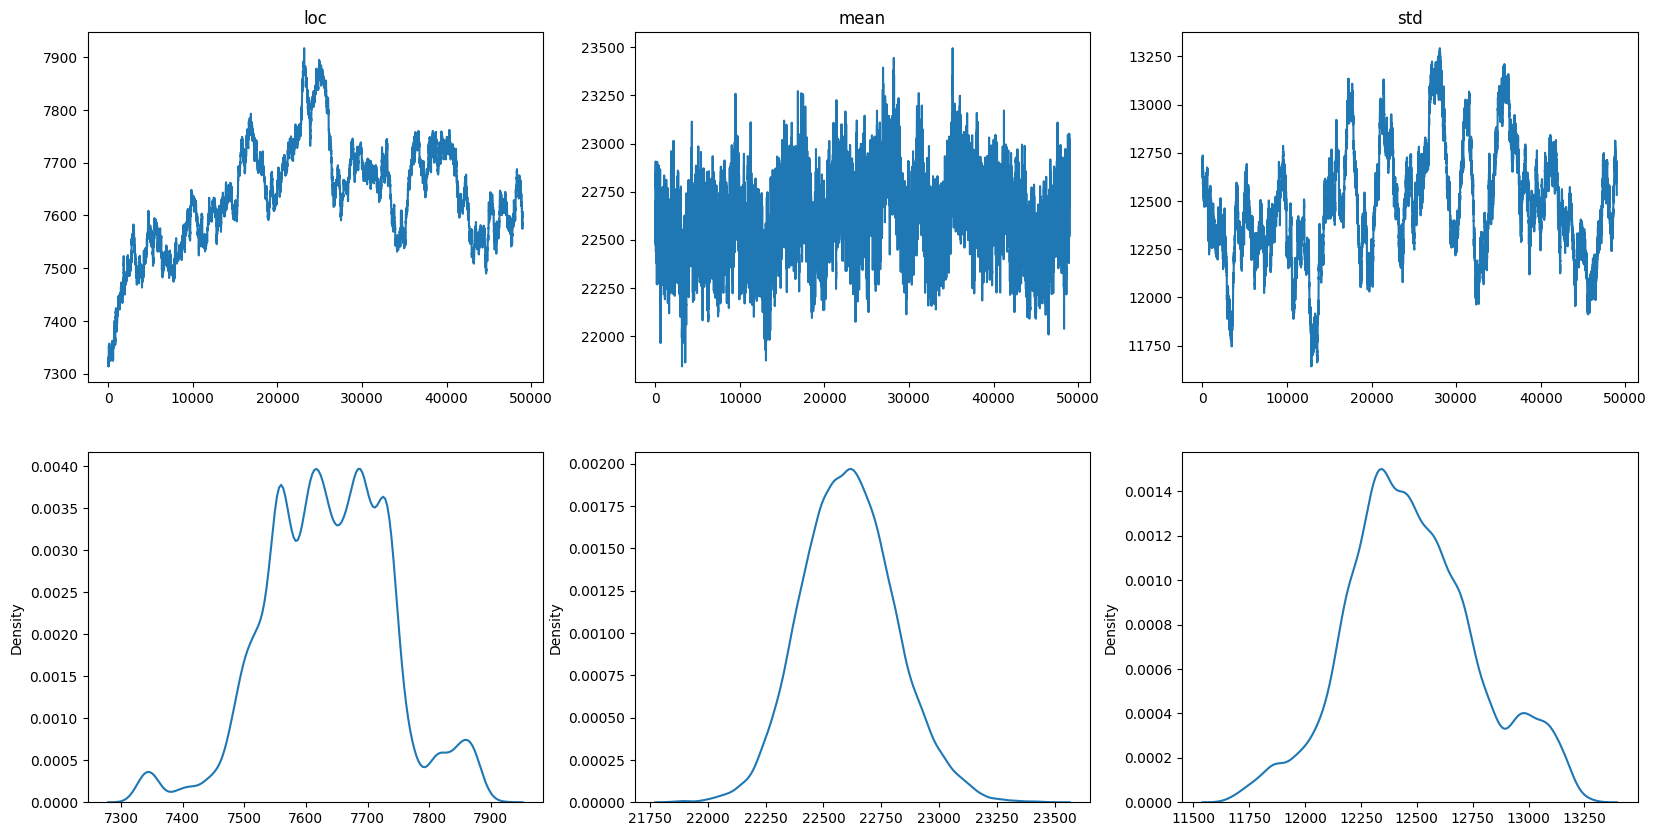

In [438]:
display(Reunion_repar_gp,burnin=1000)

Reparametrized Generalized Pareto:
loc = 7635.584720680339 scale = 18280.514123511257 shape = -0.2207194541242827
mean = 22610.46054568663 std = 12480.440991419513


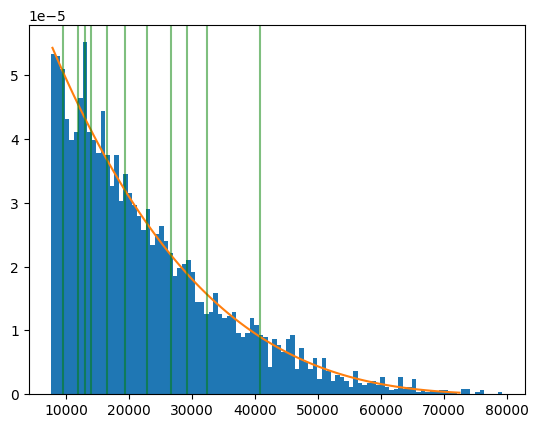

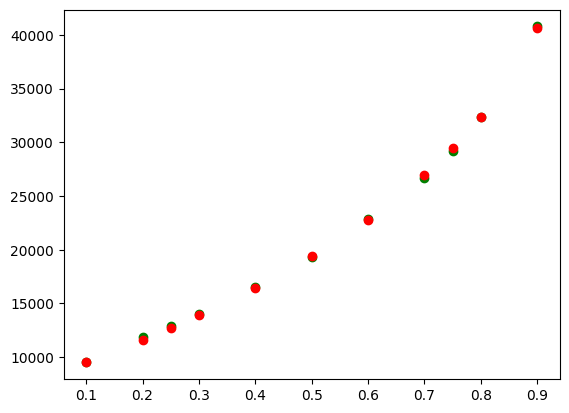

In [439]:
burnin =1000
post_loc_repar_gp_r = np.array(Reunion_repar_gp["chains"]["loc"][burnin:])
post_mean_repar_gp_r = np.array(Reunion_repar_gp["chains"]["mean"][burnin:])
post_std_repar_gp_r = np.array(Reunion_repar_gp["chains"]["std"][burnin:])

post_scale_repar_gp_r = ((post_mean_repar_gp_r-post_loc_repar_gp_r)/2+(post_mean_repar_gp_r-post_loc_repar_gp_r)**3/(2*post_std_repar_gp_r**2))
post_shape_repar_gp_r = 1/2-(post_mean_repar_gp_r-post_loc_repar_gp_r)**2/(2*post_std_repar_gp_r**2)

print("Reparametrized Generalized Pareto:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_gp_r),np.mean(post_scale_repar_gp_r),np.mean(post_shape_repar_gp_r),np.mean(post_mean_repar_gp_r),np.mean(post_std_repar_gp_r)))

law_repar_gp = genpareto(c=np.mean(post_shape_repar_gp_r), scale=np.mean(post_scale_repar_gp_r),loc=np.mean(post_loc_repar_gp_r))

plt.hist(Reunion_repar_gp["X"][-1],bins=100,density=True);
x=np.linspace(law_repar_gp.ppf(0.01),law_repar_gp.ppf(0.999), 100)
plt.plot(x,law_repar_gp.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_repar_gp.ppf(P),color="red")


## Pareto Type II

In [ ]:
from RobustGibbsObject.Model import ParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [440]:
loc = Gamma(1000,10, name="loc")
scale = Gamma(1000,1000, name="scale")
shape = Gamma(10,10, name="shape")

p2 = ParetoType2Model(loc,scale,shape)

Reunion_p2 = p2.Gibbs_Quantile(100000,N_reunion,Q_reunion,P,std_prop_dict={"loc":10,"scale":5000,"shape":1},std_prop_quantile=.1,List_X=True)

Init...
Init done! {'loc': 7130.0, 'scale': 21288.885788947162, 'shape': 2.5}


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:50<00:00, 904.79it/s]


Acceptation rates MH : loc = 23.90% scale = 88.34% shape = 69.86% 


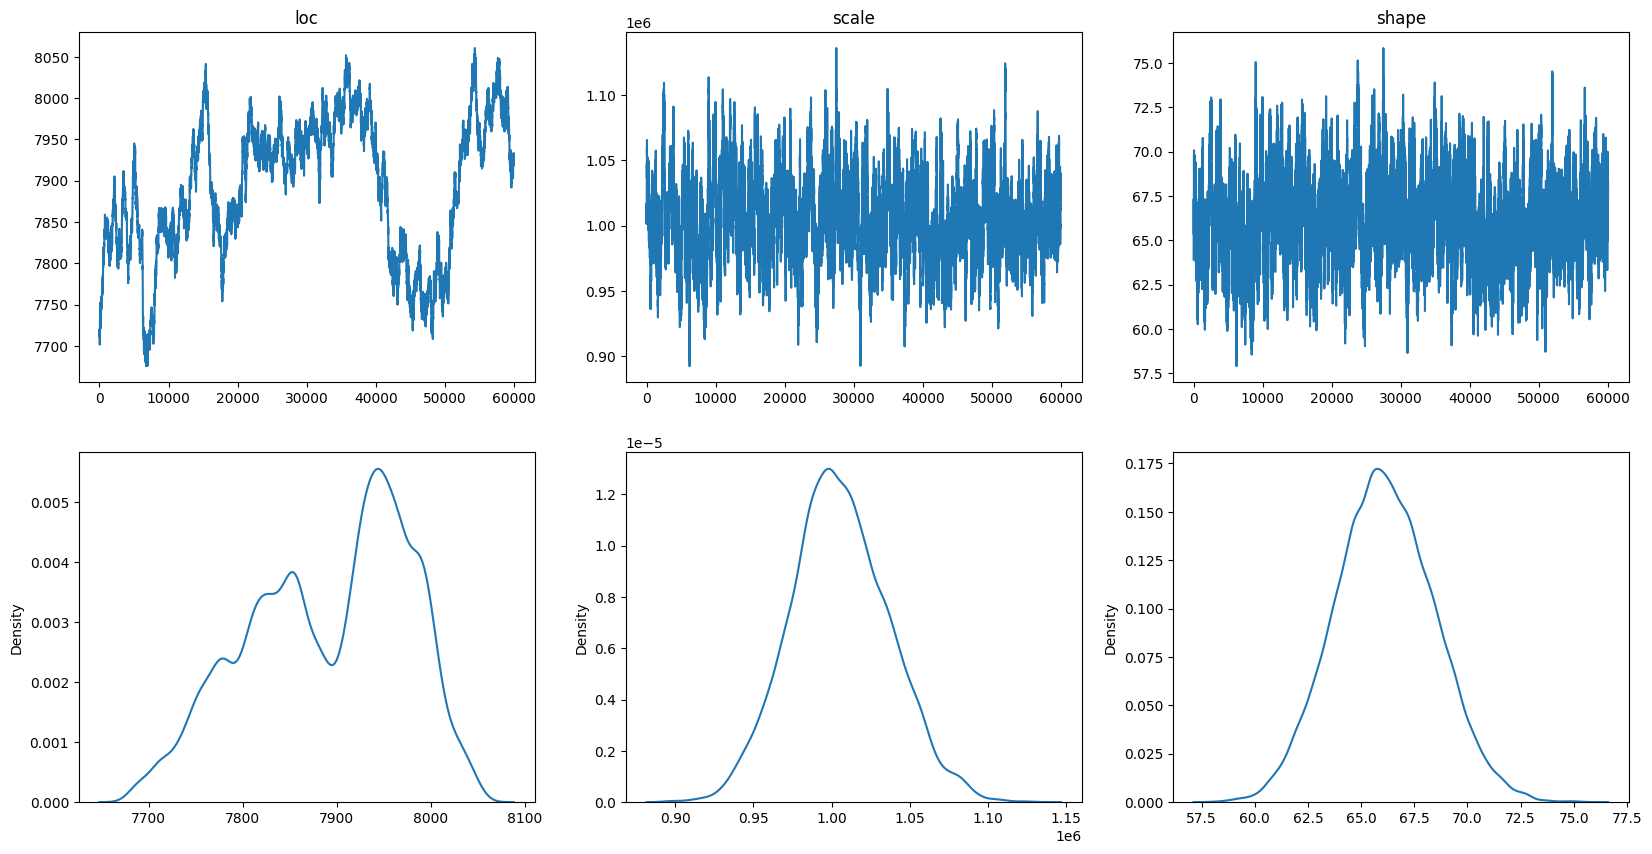

In [441]:
display(Reunion_p2,burnin=40000)

In [86]:
class pareto2:
    def __init__(self, loc=0, scale=1,shape=1):
        self.loc = loc
        self.scale = scale
        self.shape = shape
        
    def pdf(self,x):
        x=np.array(x)
        return (self.shape/self.scale)*(1+(x-self.loc)/self.scale)**(-self.shape-1)
    def cdf(self,x):
        x=np.array(x)
        return 1-(1+(x-self.loc)/self.scale)**(-self.shape)
    def ppf(self,x):
        x=np.array(x)
        return self.loc+self.scale*((1-x)**(-1/self.shape)-1)
    def logpdf(self,x):
        x=np.array(x)
        return np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale)
    def rvs(self,size):
        return self.ppf(np.random.random(size))
    def mean(self):
        if self.shape<1:
            return np.inf
        else:
            return self.scale/(self.shape-1)+self.loc
    def std(self):
        if self.shape<2:
            return np.inf
        else:
            return self.scale*np.sqrt(self.shape/((self.shape-1)**2*(self.shape-2)))

Pareto Type 2:
loc = 7891.384245475292 scale = 1005448.3649090712 shape = 66.12147888222646
mean = 23330.965504485786 std = 15678.518820584259


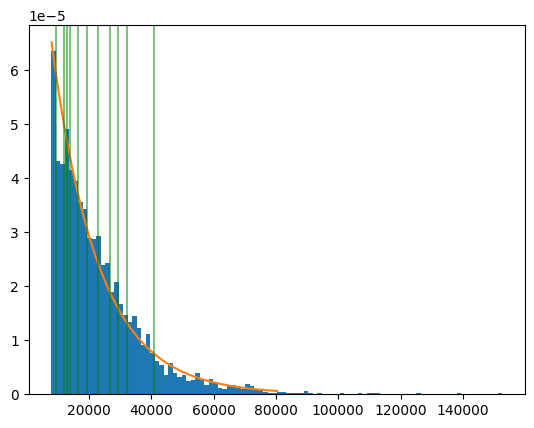

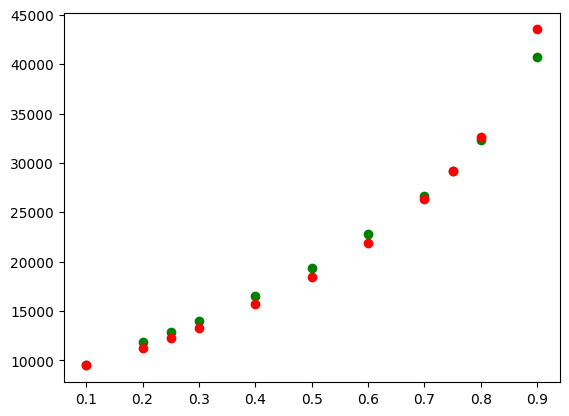

In [442]:
burnin = 40000
post_loc_p2_r = np.array(Reunion_p2["chains"]["loc"][burnin:])
post_scale_p2_r = np.array(Reunion_p2["chains"]["scale"][burnin:])
post_shape_p2_r = np.array(Reunion_p2["chains"]["shape"][burnin:])

print("Pareto Type 2:\nloc = {} scale = {} shape = {}".format(np.mean(post_loc_p2_r),np.mean(post_scale_p2_r),np.mean(post_shape_p2_r)))

law_p2 = pareto2(loc=np.mean(post_loc_p2_r), scale=np.mean(post_scale_p2_r),shape=np.mean(post_shape_p2_r))
print("mean = {} std = {}".format(law_p2.mean(),law_p2.std()))
x=np.linspace(law_p2.ppf(0.01),law_p2.ppf(0.99), 100)
plt.hist(Reunion_p2["X"][-1],bins=100,density=True);
plt.plot(x,law_p2.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_p2.ppf(P),color="red")



## Reparametrized Pareto Type II

In [13]:
from RobustGibbsObject.Model import ReparametrizedParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [443]:
loc = Gamma(1000,10, name="loc")
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

repar_p2 = ReparametrizedParetoType2Model(loc,mean,std)

Reunion_repar_p2 = repar_p2.Gibbs_Quantile(100000,N_reunion,Q_reunion,P,std_prop_dict={"loc":10,"mean":65,"std":12},std_prop_quantile=.05)


Init...
Init done! {'loc': 7130.0, 'mean': 21322.590525964777, 'std': 31735.597192876732}


  0%|          | 0/100000 [00:00<?, ?it/s]

 33%|███▎      | 32906/100000 [00:33<01:11, 934.36it/s] /Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Distribution.py:462: RuntimeWarning: invalid value encountered in log
  return np.where(x>=self.loc,np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale),-np.inf)
100%|██████████| 100000/100000 [01:46<00:00, 939.80it/s]


Acceptation rates MH : loc = 23.39% mean = 63.29% std = 89.35% 


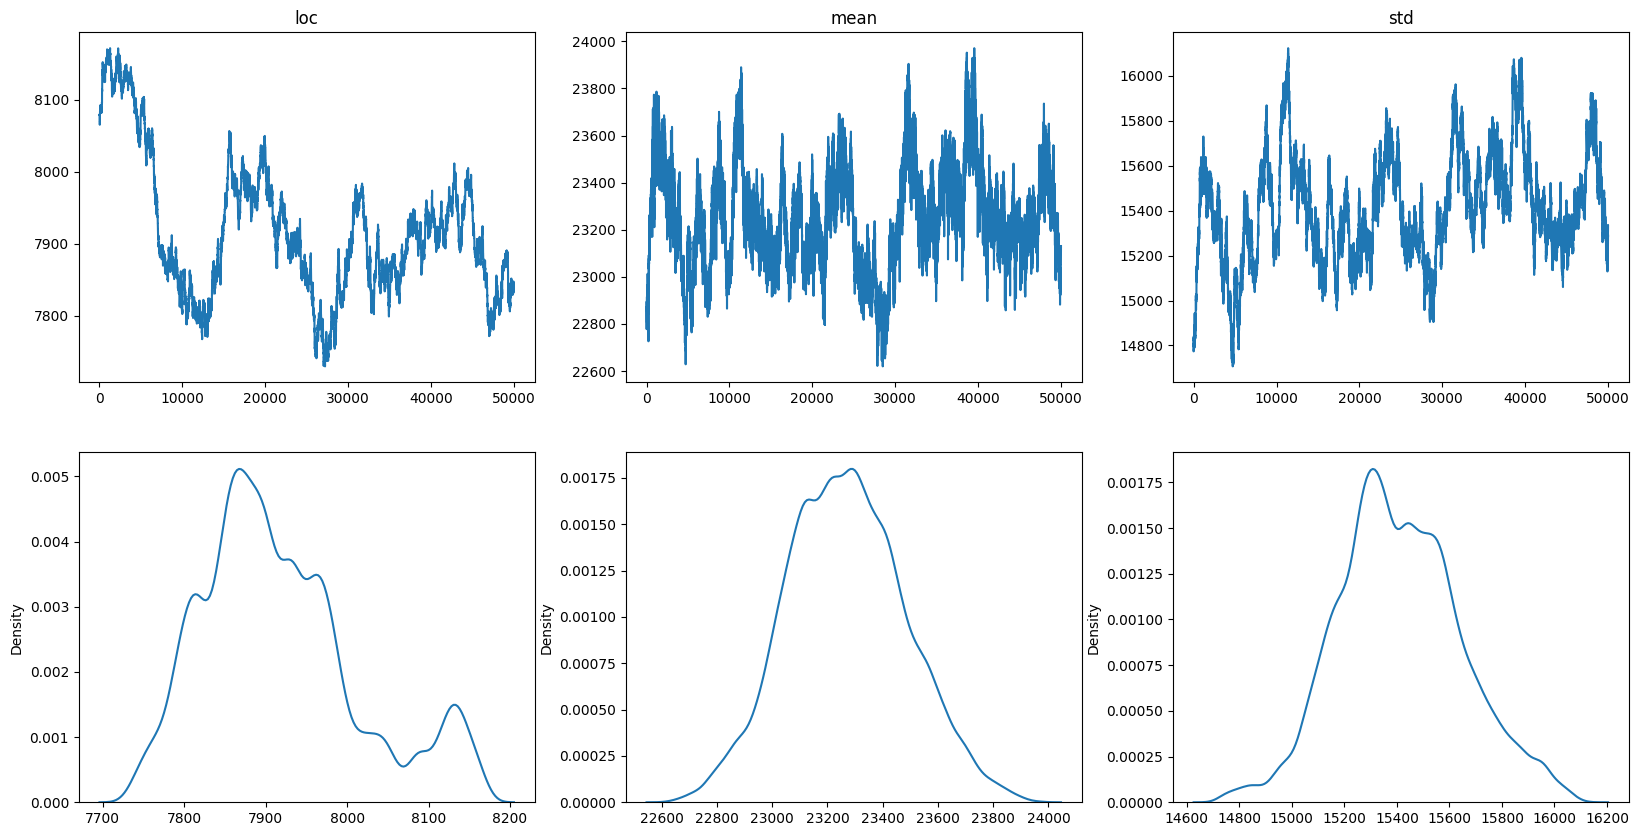

In [455]:
display(Reunion_repar_p2,50000)

In [456]:
burnin= 50000
post_loc_repar_p2_r = np.array(Reunion_repar_p2["chains"]["loc"][burnin:])
post_mean_repar_p2_r = np.array(Reunion_repar_p2["chains"]["mean"][burnin:])
post_std_repar_p2_r = np.array(Reunion_repar_p2["chains"]["std"][burnin:])

post_scale_repar_p2_r = ((post_mean_repar_p2_r-post_loc_repar_p2_r)*(post_std_repar_p2_r**2+(post_mean_repar_p2_r-post_loc_repar_p2_r)**2)/(post_std_repar_p2_r**2-(post_mean_repar_p2_r-post_loc_repar_p2_r)**2))
post_shape_repar_p2_r = 2*post_std_repar_p2_r**2/(post_std_repar_p2_r**2-(post_mean_repar_p2_r-post_loc_repar_p2_r)**2)

print("Reparametrized Pareto Type 2:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(np.mean(post_loc_repar_p2_r),np.mean(post_scale_repar_p2_r),np.mean(post_shape_repar_p2_r),np.mean(post_mean_repar_p2_r),np.mean(post_std_repar_p2_r)))
law_repar_p2 = pareto2(loc=np.mean(post_loc_repar_p2_r), scale=np.mean(post_scale_repar_p2_r),shape=np.mean(post_shape_repar_p2_r))
x=np.linspace(law_repar_p2.ppf(0.01),law_repar_p2.ppf(0.99), 100)
plt.plot(x,law_repar_p2.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_repar_p2.ppf(P),color="red")


Reparametrized Pareto Type 2:
loc = 7917.157238471585 scale = 132119018.45501342 shape = 8537.940987997443
mean = 23269.221230797964 std = 15411.32705304273


KeyboardInterrupt: 

## Fixed Translated LN

In [565]:
from RobustGibbsObject.Model import FixedReparametrizedTranslatedLogNormalModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [179]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_tln = FixedReparametrizedTranslatedLogNormalModel(mean,std)

Reunion_fix_repar_tln = fix_repar_tln.Gibbs_Quantile(201000,N_reunion,Q_reunion,P,std_prop_dict={"mean":400,"std":500},std_prop_quantile=.01,List_X=True)

Init...
Init done! {'mean': 25000, 'std': 10000}


  0%|          | 0/21000 [00:00<?, ?it/s]

100%|██████████| 21000/21000 [03:31<00:00, 99.16it/s] 


Acceptance rate of Q 0 = 38.37%
Acceptance rate of Q 1 = 58.43%
Acceptance rate of Q 2 = 52.76%
Acceptance rate of Q 3 = 53.58%
Acceptance rate of Q 4 = 56.38%
Acceptance rate of Q 5 = 58.70%
Acceptance rate of Q 6 = 55.51%
Acceptance rate of Q 7 = 46.69%
Acceptance rate of Q 8 = 43.89%
Acceptance rate of Q 9 = 44.50%
Acceptance rate of Q 10 = 39.37%
Acceptation rates MH : mean = 35.17% std = 46.36% 


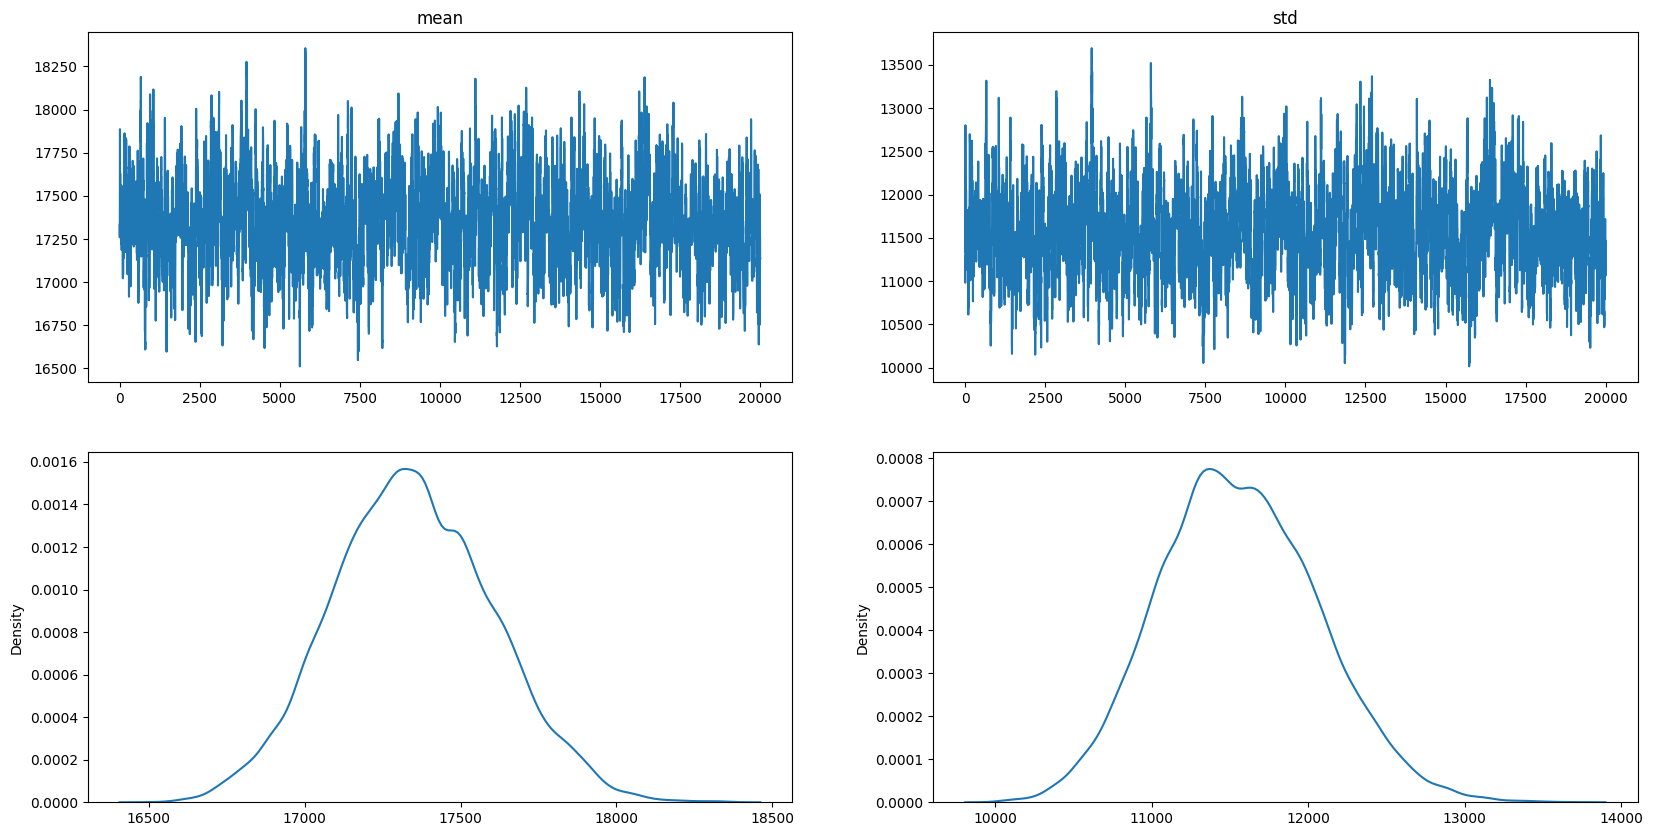

In [186]:
display(Reunion_fix_repar_tln,burnin=1000)

Fixed Reparametrized Translated LogNormal:
loc = 6389.64 scale = 8.927799665510442 shape = 0.8644370083020585
mean = 17347.624710903485 std = 11557.934292906779


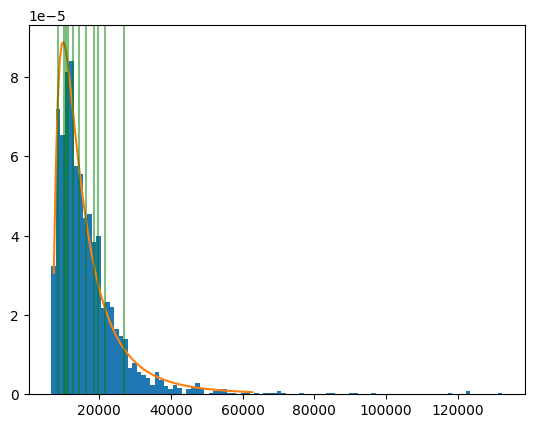

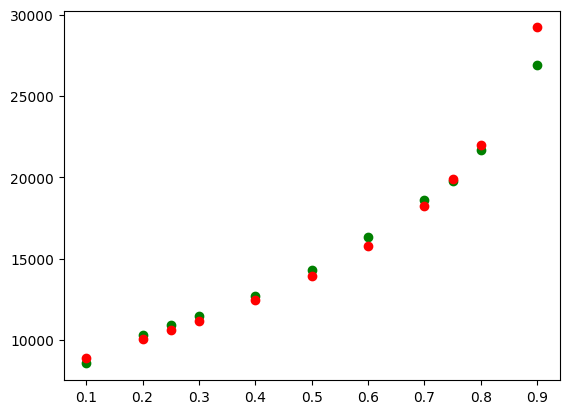

In [187]:
loc = 6389.64
burnin = 1000
post_mean_fix_repar_tln_r = np.array(Reunion_fix_repar_tln["chains"]["mean"][burnin:])
post_std_fix_repar_tln_r = np.array(Reunion_fix_repar_tln["chains"]["std"][burnin:])    

Y_tln = np.array(Reunion_fix_repar_tln["X"][burnin+1:])
post_scale_fix_repar_tln_r = np.log((post_mean_fix_repar_tln_r-loc)**2/np.sqrt((post_mean_fix_repar_tln_r-loc)**2+(post_std_fix_repar_tln_r)**2))
post_shape_fix_repar_tln_r = np.sqrt(np.log(1+np.power(post_std_fix_repar_tln_r,2)/np.power(post_mean_fix_repar_tln_r-loc,2)))

law_fix_repar_tnl = lognorm(s=np.mean(post_shape_fix_repar_tln_r), scale=np.mean(np.exp(post_scale_fix_repar_tln_r)),loc=loc)
print("Fixed Reparametrized Translated LogNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_tln_r),np.mean(post_shape_fix_repar_tln_r),np.mean(post_mean_fix_repar_tln_r),np.mean(post_std_fix_repar_tln_r)))
plt.hist(Reunion_fix_repar_tln["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_tnl.ppf(0.01),law_fix_repar_tnl.ppf(0.99), 100)
plt.plot(x,law_fix_repar_tnl.pdf(x))

for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_fix_repar_tnl.ppf(P),color="red")



## Fixed Translated GP

In [152]:
from RobustGibbsObject.Model import FixedReparametrizedGeneralizedParetoModel

In [180]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_gp = FixedReparametrizedGeneralizedParetoModel(mean,std)

Reunion_fix_repar_gp = fix_repar_gp.Gibbs_Quantile(201000,N_reunion,Q_reunion,P,std_prop_dict={"mean":300,"std":100},std_prop_quantile=.01,List_X=True)

Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [04:24<00:00, 79.47it/s]


Acceptance rate of Q 0 = 53.45%
Acceptance rate of Q 1 = 49.84%
Acceptance rate of Q 2 = 42.59%
Acceptance rate of Q 3 = 44.29%
Acceptance rate of Q 4 = 46.93%
Acceptance rate of Q 5 = 51.41%
Acceptance rate of Q 6 = 51.17%
Acceptance rate of Q 7 = 46.98%
Acceptance rate of Q 8 = 46.66%
Acceptance rate of Q 9 = 54.01%
Acceptance rate of Q 10 = 42.33%
Acceptation rates MH : mean = 32.20% std = 45.77% 


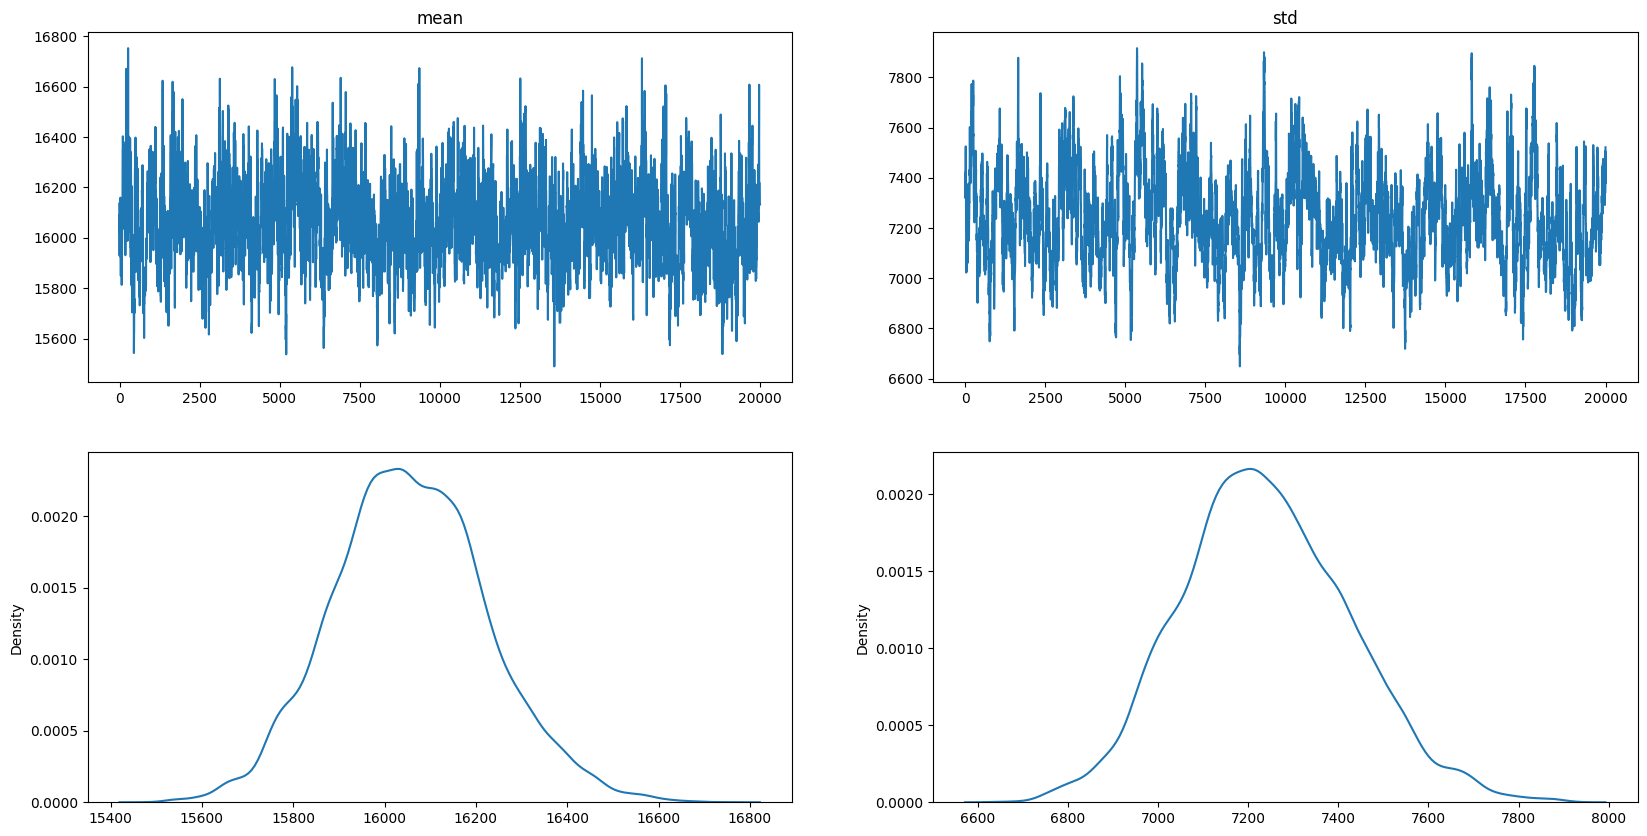

In [184]:
display(Reunion_fix_repar_gp,burnin=1000)

Fixed Reparametrized Generalized Pareto:
loc = 6389.64 scale = 13467.409045577553 shape = -0.39296464005203524
mean = 16057.284935879146 std = 7238.60916842144


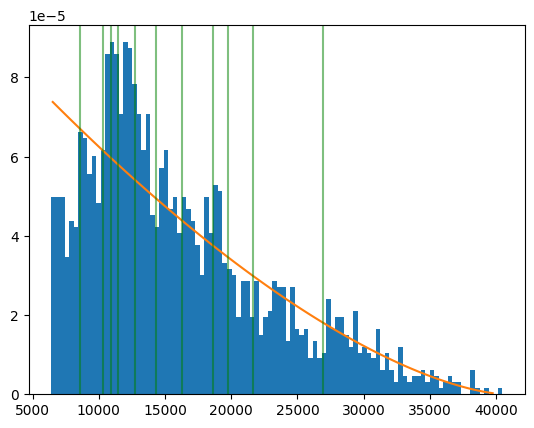

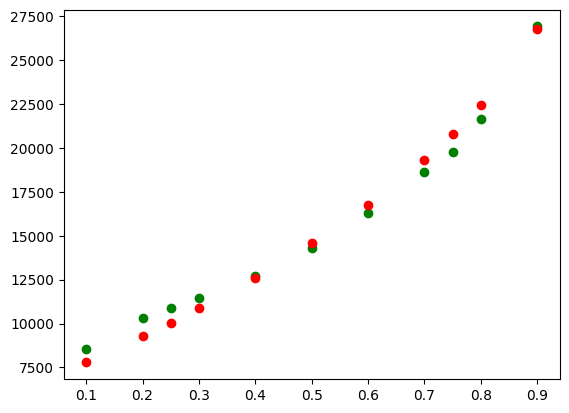

In [185]:
loc= 6389.64
burnin=1000
post_mean_fix_repar_gp_r = np.array(Reunion_fix_repar_gp["chains"]["mean"][burnin:])
post_std_fix_repar_gp_r = np.array(Reunion_fix_repar_gp["chains"]["std"][burnin:])
Y_gp = np.array(Reunion_fix_repar_gp["X"][burnin+1:])

post_scale_fix_repar_gp_r = ((post_mean_fix_repar_gp_r-loc)/2+(post_mean_fix_repar_gp_r-loc)**3/(2*post_std_fix_repar_gp_r**2))
post_shape_fix_repar_gp_r = 1/2-(post_mean_fix_repar_gp_r-loc)**2/(2*post_std_fix_repar_gp_r**2)

print("Fixed Reparametrized Generalized Pareto:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_gp_r),np.mean(post_shape_fix_repar_gp_r),np.mean(post_mean_fix_repar_gp_r),np.mean(post_std_fix_repar_gp_r)))

law_fix_repar_gp = genpareto(c=np.mean(post_shape_fix_repar_gp_r), scale=np.mean(post_scale_fix_repar_gp_r),loc=loc)
plt.hist(Reunion_fix_repar_gp["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_gp.ppf(0.01),law_fix_repar_gp.ppf(0.9999), 100)
plt.plot(x,law_fix_repar_gp.pdf(x))
for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_fix_repar_gp.ppf(P),color="red")


## Fixed Translated P2

In [156]:
from RobustGibbsObject.Model import FixedReparametrizedParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [181]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_p2 = FixedReparametrizedParetoType2Model(mean,std)

Reunion_fix_repar_p2 = fix_repar_p2.Gibbs_Quantile(21000,N_reunion,Q_reunion,P,std_prop_dict={"mean":70,"std":70},std_prop_quantile=.01,List_X=True)

Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


  0%|          | 0/21000 [00:00<?, ?it/s]/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Distribution.py:521: RuntimeWarning: invalid value encountered in log
  return np.where(x>=self.loc,np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale),-np.inf)
100%|██████████| 21000/21000 [00:33<00:00, 629.85it/s]


Acceptance rate of Q 0 = 60.91%
Acceptance rate of Q 1 = 56.95%
Acceptance rate of Q 2 = 48.35%
Acceptance rate of Q 3 = 47.82%
Acceptance rate of Q 4 = 49.81%
Acceptance rate of Q 5 = 50.40%
Acceptance rate of Q 6 = 50.60%
Acceptance rate of Q 7 = 42.26%
Acceptance rate of Q 8 = 39.82%
Acceptance rate of Q 9 = 44.10%
Acceptance rate of Q 10 = 40.67%
Acceptation rates MH : mean = 37.92% std = 38.93% 


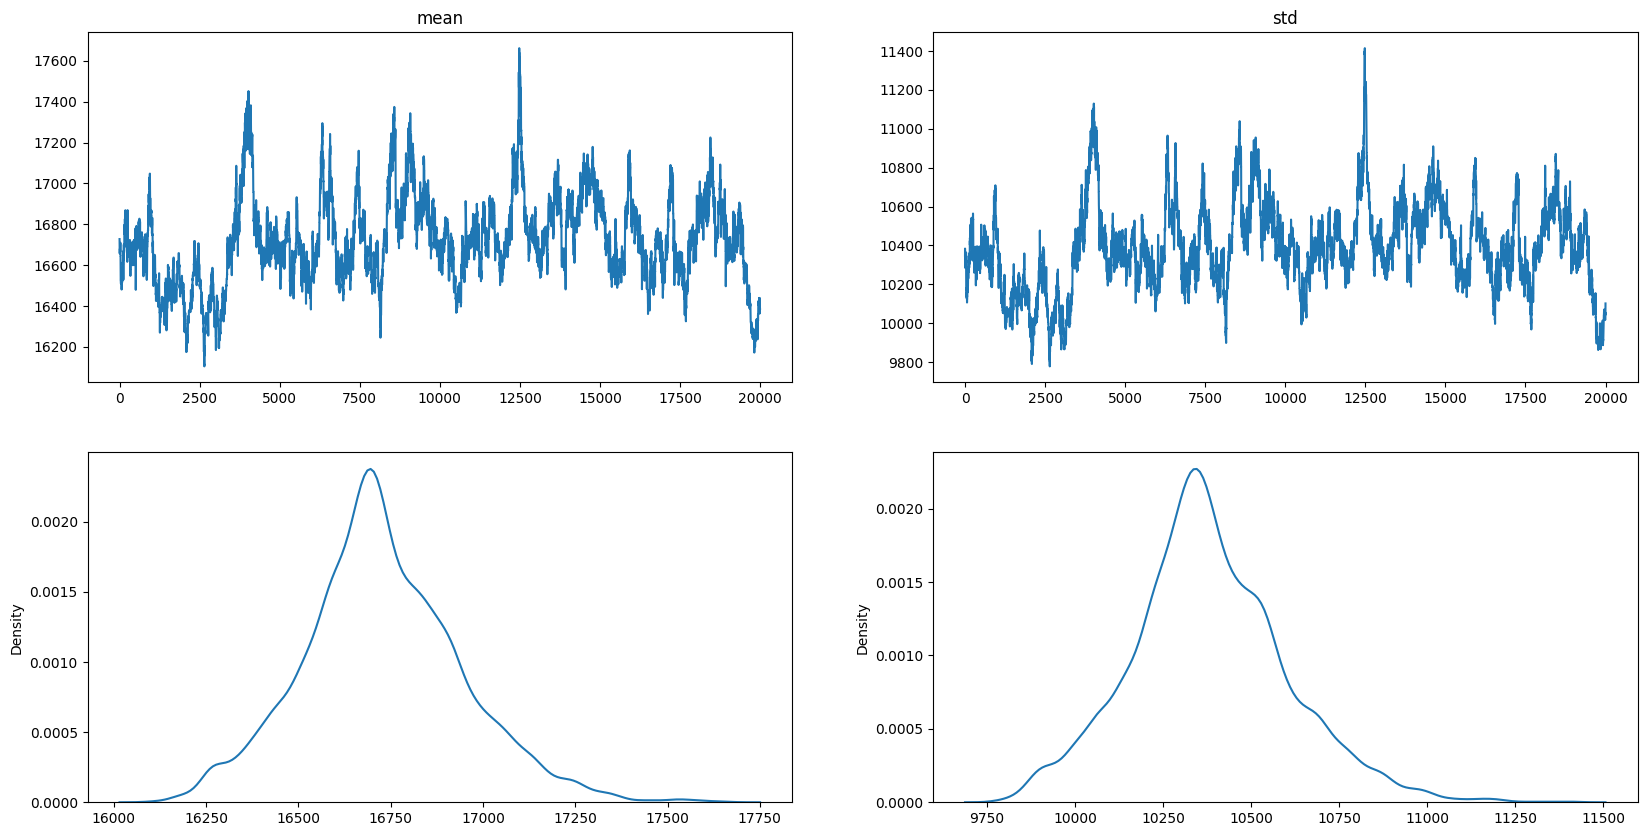

In [182]:
display(Reunion_fix_repar_p2,burnin=1000)

Fixed Reparametrized Pareto Type 2:
loc = 6389.64 scale = 23391462.243397936 shape = 2260.0034291538973
mean = 16728.856162587526 std = 10380.175726230073


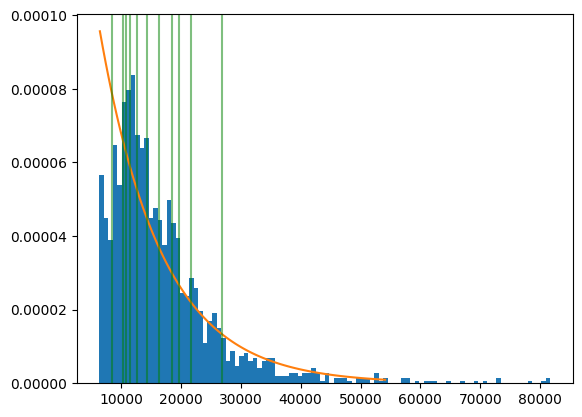

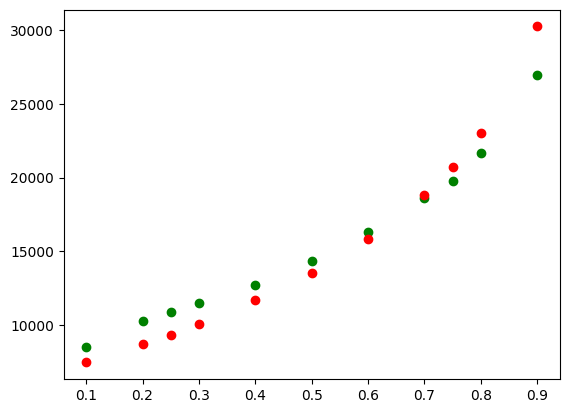

In [183]:
burnin=1000
post_mean_fix_repar_p2_r = np.array(Reunion_fix_repar_p2["chains"]["mean"][burnin:])
post_std_fix_repar_p2_r = np.array(Reunion_fix_repar_p2["chains"]["std"][burnin:])
loc = 6389.64
Y_p2 = np.array(Reunion_fix_repar_p2["X"][burnin+1:])

post_scale_fix_repar_p2_r = ((post_mean_fix_repar_p2_r-loc)*(post_std_fix_repar_p2_r**2+(post_mean_fix_repar_p2_r-loc)**2)/(post_std_fix_repar_p2_r**2-(post_mean_fix_repar_p2_r-loc)**2))
post_shape_fix_repar_p2_r = 2*post_std_fix_repar_p2_r**2/(post_std_fix_repar_p2_r**2-(post_mean_fix_repar_p2_r-loc)**2)

print("Fixed Reparametrized Pareto Type 2:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_p2_r),np.mean(post_shape_fix_repar_p2_r),np.mean(post_mean_fix_repar_p2_r),np.mean(post_std_fix_repar_p2_r)))

law_fix_repar_p2 = pareto2(loc=loc,scale=np.mean(post_scale_fix_repar_p2_r),shape=np.mean(post_shape_fix_repar_p2_r))

plt.hist(Reunion_fix_repar_p2["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_p2.ppf(0.01),law_fix_repar_p2.ppf(0.99), 100)
plt.plot(x,law_fix_repar_p2.pdf(x))

for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_reunion,color="green")
plt.scatter(P,law_fix_repar_p2.ppf(P),color="red")


## Comparison fixed location

In [192]:
Y_gp_r, Y_p2_r, Y_tln_r = Reunion_fix_repar_gp["X"][burnin+1:], Reunion_fix_repar_p2["X"][burnin+1:], Reunion_fix_repar_tln["X"][burnin+1:]

In [214]:
theta_tln_r = np.array([post_mean_fix_repar_tln_r,post_std_fix_repar_tln_r]).T
theta_gp_r = np.array([post_mean_fix_repar_gp_r,post_std_fix_repar_gp_r]).T
theta_p2_r = np.array([post_mean_fix_repar_p2_r,post_std_fix_repar_p2_r]).T

(6000.0, 50000.0)

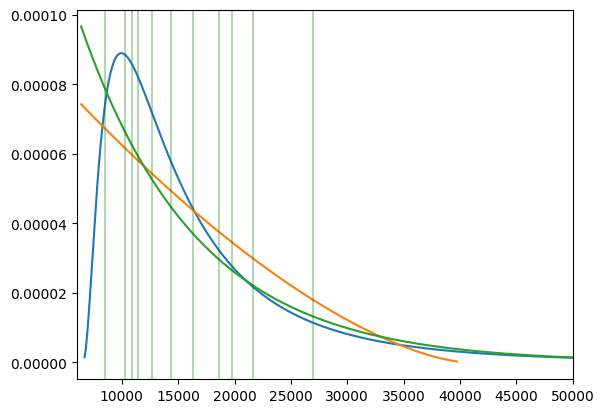

In [225]:
law_tln_r = lognorm(s=np.mean(post_shape_fix_repar_tln_r), scale=np.mean(np.exp(post_scale_fix_repar_tln_r)),loc=loc)
law_gp_r = genpareto(c=np.mean(post_shape_fix_repar_gp_r), scale=np.mean(post_scale_fix_repar_gp_r),loc=loc)
law_p2_r = pareto2(loc=loc,scale=np.mean(post_scale_fix_repar_p2_r),shape=np.mean(post_shape_fix_repar_p2_r))

x = np.linspace(law_tln_r.ppf(0.0001),law_tln_r.ppf(0.9999), 10000)
plt.plot(x,law_tln_r.pdf(x))
x = np.linspace(law_gp_r.ppf(0.0001),law_gp_r.ppf(0.9999), 10000)
plt.plot(x,law_gp_r.pdf(x))
x = np.linspace(law_p2_r.ppf(0.0001),law_p2_r.ppf(0.9999), 10000)
plt.plot(x,law_p2_r.pdf(x))

for q in Q_reunion:
    plt.axvline(q,color="green",alpha=.3)
plt.xlim(6000,50000)
    

In [210]:
Y_tln_r = np.array(Y_tln_r)

In [188]:
prop_tln = len(np.where((post_mean_fix_repar_tln_r-loc)>post_std_fix_repar_tln_r)[0])/len(post_mean_fix_repar_tln_r)
prop_gp = len(np.where((post_mean_fix_repar_gp_r-loc)>post_std_fix_repar_gp_r)[0])/len(post_mean_fix_repar_gp_r)
prop_p2 = len(np.where((post_mean_fix_repar_p2_r-loc)>post_std_fix_repar_p2_r)[0])/len(post_mean_fix_repar_p2_r)
print("PROPORTION (MEAN-LOC)>STD:\nTranslated LogNormal = {} ({})\nGeneralized Pareto = {} ({})\nPareto Type 2 = {} ({})".format(prop_tln,len(np.where((post_mean_fix_repar_tln_r-loc)>post_std_fix_repar_tln_r)[0]),prop_gp,len(np.where((post_mean_fix_repar_gp_r-loc)>post_std_fix_repar_gp_r)[0]),prop_p2,len(np.where((post_mean_fix_repar_p2_r-loc)>post_std_fix_repar_p2_r)[0])))

PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.02055 (411)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


## Bayes Factor

### TLN vs GP

In [194]:
l1_r = [lratio_tln_gp(Y,mean = mean,std = std,loc = loc) for Y,mean,std in tqdm(zip(Y_tln_r,post_mean_fix_repar_tln_r,post_std_fix_repar_tln_r))]
l2_r = [lratio_tln_gp(Y,mean = mean,std = std,loc = loc) for Y,mean,std in tqdm(zip(Y_gp_r,post_mean_fix_repar_gp_r,post_std_fix_repar_gp_r))]


20000it [00:22, 897.86it/s]
20000it [00:22, 884.93it/s]


In [196]:
np.where(np.isnan(l1_r)),np.where(np.isnan(l2_r))

((array([], dtype=int64),), (array([], dtype=int64),))

In [195]:
logBF_tln_gp_r = logBF_paper(l1_r,l2_r)
print("logBF Translated LogNormal/Generalized Pareto = ",logBF_tln_gp_r)

logBF Translated LogNormal/Generalized Pareto =  -106.05930048765852


In [197]:
logBF_gp_tln_r = logBF_paper(-np.array(l2_r),-np.array(l1_r))
print("logBF Generalized Pareto/Translated LogNormal = ",logBF_gp_tln_r)

logBF Generalized Pareto/Translated LogNormal =  106.05930048765852


In [199]:
BF_tln_gp_r= BF_paper(l1_r,l2_r)
print("BF = {}".format(BF_tln_gp_r))
print("logBF = {}".format(np.log(BF_tln_gp_r)))

163.55126020357017
BF = 8.690225454410349e-47
logBF = -106.05930048765852


In [201]:
BF_gp_tln_r = BF_paper(-np.array(l2_r),-np.array(l1_r))
print("BF = {}".format(BF_gp_tln_r))
print("logBF = {}".format(np.log(BF_gp_tln_r)))
      

730.7691974899883


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: Failed to converge after 10000 iterations, value is nan

### TLN vs P2

In [211]:
theta_tln2_r= theta_tln_r[np.where((post_mean_fix_repar_tln_r-loc)<post_std_fix_repar_tln_r)[0]]
Y_tln2_r = Y_tln_r[np.where((post_mean_fix_repar_tln_r-loc)<post_std_fix_repar_tln_r)[0]]
len(theta_tln2_r),len(Y_tln2_r)

(19589, 19589)

In [215]:
l1b_r = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln2_r,theta_tln2_r),total=len(Y_tln_r))]
l2b_r = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_p2_r,theta_p2_r),total=len(Y_p2_r))]

  0%|          | 0/20000 [00:00<?, ?it/s]

100%|██████████| 20000/20000 [00:11<00:00, 1773.60it/s]


In [216]:
np.where(np.isnan(l1b_r)),np.where(np.isnan(l2b_r))

((array([], dtype=int64),), (array([], dtype=int64),))

In [218]:
BF_tln_p2_r = BF_paper(l1b_r,l2b_r)
print("BF = {}".format(BF_tln_p2_r))
print("logBF = {}".format(np.log(BF_tln_p2_r)))
BF_p2_tln_r = BF_paper(-np.array(l2b_r),-np.array(l1b_r))
print("BF = {}".format(BF_p2_tln_r))
print("logBF = {}".format(np.log(BF_p2_tln_r)))
      

163.60118997760696
BF = 1.8192925457915548e+16
logBF = 37.43980920232215
229.00470816273042
BF = 5.4966421003220674e-17
logBF = -37.43980920232215


In [219]:
logBF_tln_p2_r = logBF_paper(l1b_r,l2b_r)
print("logBF Translated LogNormal/Pareto Type 2 = ",logBF_tln_p2_r)
logBF_p2_tln_r = logBF_paper(-np.array(l2b_r),-np.array(l1b_r))
print("logBF Pareto Type 2/Translated LogNormal = ",logBF_p2_tln_r)


logBF Translated LogNormal/Pareto Type 2 =  37.439809202322145
logBF Pareto Type 2/Translated LogNormal =  -37.43980920232215


In [34]:
print("Fixed Reparametrized Tranlated LogNormal:\nscale = {} shape = {}\nmean = {} std = {}\n\nFixed Reparametrized Generalized Pareto:\nscale = {} shape = {}\nmean = {} std = {}\n\nFixed Reparametrized Pareto Type 2:\nscale = {} shape = {}\nmean = {} std = {}\n".format(np.mean(post_scale_fix_repar_tln),np.mean(post_shape_fix_repar_tln),np.mean(np.exp(post_scale_fix_repar_tln)),np.mean(np.exp(post_scale_fix_repar_tln)),np.mean(post_scale_fix_repar_gp_r),np.mean(post_shape_fix_repar_gp_r),np.mean(post_mean_fix_repar_gp_r),np.mean(post_std_fix_repar_gp_r),np.mean(post_scale_fix_repar_p2_r),np.mean(post_shape_fix_repar_p2_r),np.mean(post_mean_fix_repar_p2_r),np.mean(post_std_fix_repar_p2_r)))

Fixed Reparametrized Tranlated LogNormal:
scale = 8.927078579020279 shape = 0.863600887529179
mean = 7534.682595438975 std = 7534.682595438975

Fixed Reparametrized Generalized Pareto:
scale = 13321.062064061753 shape = -0.3633905264979242
mean = 16225.37659029916 std = 7697.341807594867

Fixed Reparametrized Pareto Type 2:
scale = 27094269.64498501 shape = 2618.5838056472735
mean = 16811.15813534866 std = 10466.26146779007



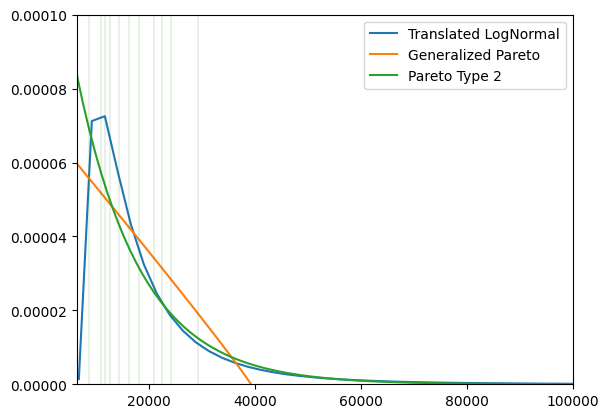

In [42]:
x=np.linspace(law_fix_repar_tnl.ppf(0.0001),law_fix_repar_tnl.ppf(0.9999), 100)
plt.plot(x,law_fix_repar_tnl.pdf(x),label="Translated LogNormal")

x = np.linspace(law_fix_repar_gp.ppf(0.0001),law_fix_repar_gp.ppf(1), 100)
plt.plot(x,law_fix_repar_gp.pdf(x),label="Generalized Pareto")

x = np.linspace(law_fix_repar_p2.ppf(0.0001),law_fix_repar_p2.ppf(0.9999), 100)
plt.plot(x,law_fix_repar_p2.pdf(x),label="Pareto Type 2")

for q in Q_pointe:
    plt.axvline(q,color="green",alpha=.1)
plt.legend()
plt.xlim(6300,100000)
plt.ylim(0,0.0001)
plt.show()

In [43]:
def change_p2(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)*(std**2+(mean-loc)**2)/(std**2-(mean-loc)**2),2*std**2/(std**2-(mean-loc)**2)
    return np.array([scale,shape]).T

def change_gp(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)/2+(mean-loc)**3/(2*std**2),1/2-(mean-loc)**2/(2*std**2)
    return np.array([scale,shape]).T


def change_tln(loc = 6389.64, mean = 1, std = 1):
    scale,shape = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    return np.array([scale,shape]).T


In [159]:
theta_gp = np.array([post_mean_fix_repar_gp_lp,post_std_fix_repar_gp_lp]).T
theta_tln = np.array([post_mean_fix_repar_tln_lp,post_std_fix_repar_tln_lp]).T
theta_p2 = np.array([post_mean_fix_repar_p2_lp,post_std_fix_repar_p2_lp]).T



print(theta_gp.shape,theta_tln.shape,theta_p2.shape)
print(Y_gp.shape,Y_tln.shape,Y_p2.shape)


(200000, 2) (200000, 2) (200000, 2)
(200000, 1321) (200000, 1321) (200000, 1321)


In [160]:
tln_into_tln = change_tln(mean = theta_tln[:,0],std = theta_tln[:,1])
tln_into_gp = change_gp(mean = theta_tln[:,0],std = theta_tln[:,1])
tln_into_p2 = change_p2(mean = theta_tln[:,0],std = theta_tln[:,1])

gp_into_gp = change_gp(mean = theta_gp[:,0],std = theta_gp[:,1])
gp_into_tln = change_tln(mean = theta_gp[:,0],std = theta_gp[:,1])
gp_into_p2 = change_p2(mean = theta_gp[:,0],std = theta_gp[:,1])

p2_into_p2 = change_p2(mean = theta_p2[:,0],std = theta_p2[:,1])
p2_into_tln = change_tln(mean = theta_p2[:,0],std = theta_p2[:,1])
p2_into_gp = change_gp(mean = theta_p2[:,0],std = theta_p2[:,1])


### TLN 

In [48]:
llike_tln_into_tln = np.array([np.sum(lognorm(s=tln_into_tln[i,1], scale=np.exp(tln_into_tln[i,0]),loc=loc).logpdf(Y_tln[i])) for i in tqdm(range(len(Y_tln)))])
print("ok")
llike_tln_into_gp = np.array([np.sum(genpareto(c=tln_into_gp[i,1], scale=tln_into_gp[i,0],loc=loc).logpdf(Y_tln[i])) for i in tqdm(range(len(Y_tln)))])
print("ok")
llike_tln_into_p2 = np.array([np.sum(pareto2(loc=loc,scale=tln_into_p2[i,0],shape=tln_into_p2[i,1]).logpdf(Y_tln[i])) for i in tqdm(range(len(Y_tln)))])


  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [01:42<00:00, 1960.67it/s]


ok


100%|██████████| 200000/200000 [01:39<00:00, 2002.03it/s]


ok


100%|██████████| 200000/200000 [00:04<00:00, 40685.48it/s]


In [184]:
i_nan_tln_into_gp = np.where(np.isnan(llike_tln_into_gp))[0]
i_nan_tln_into_tln = np.where(np.isnan(llike_tln_into_tln))[0]
i_nan_tln_into_p2 = np.where(np.isnan(llike_tln_into_p2))[0]

print("Number of NANs:\nLlike_tln(Y_tln|theta_tln) = {}\nLlike_gp(Y_tln|theta_tln) = {}\nLlike_p2(Y_tln|theta_tln) = {}\n".format(len(i_nan_tln_into_tln),len(i_nan_tln_into_gp),len(i_nan_tln_into_p2)))

Number of NANs:
Llike_tln(Y_tln|theta_tln) = 0
Llike_gp(Y_tln|theta_tln) = 0
Llike_p2(Y_tln|theta_tln) = 114



#### Check TLN -> GP

In [168]:
scale_tln_into_gp = tln_into_gp[:,0]
shape_tln_into_gp = tln_into_gp[:,1]


In [228]:
maxY_tln[np.where(shape_tln_into_gp<0)[0]]>loc-scale_tln_into_gp[np.where(shape_tln_into_gp<0)[0]]/shape_tln_into_gp[np.where(shape_tln_into_gp<0)[0]]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

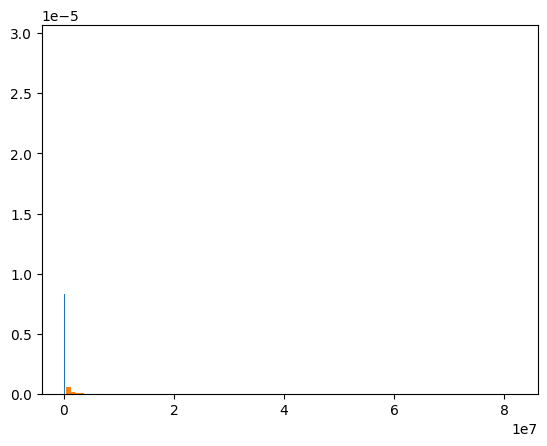

In [225]:
plt.hist(maxY_tln[np.where(shape_tln_into_gp<0)[0]],bins=100,density=True);
plt.hist(loc-scale_tln_into_gp[np.where(shape_tln_into_gp<0)[0]]/shape_tln_into_gp[np.where(shape_tln_into_gp<0)[0]],bins=100,density=True);

In [180]:
i_nan_tln_into_gp_verif = np.where(np.logical_and(shape_tln_into_gp<0,np.max(Y_tln,axis=1)>loc-scale_tln_into_gp/shape_tln_into_gp))[0]
(i_nan_tln_into_gp_verif==i_nan_tln_into_gp).all()

True

#### Check TLN -> P2 

In [181]:
mean_tln,std_tln =theta_tln.T

In [ ]:
scale_tln_into_p2 = tln_into_p2[:,0]
shape_tln_into_p2 = tln_into_p2[:,1]

In [188]:
i_nan_tln_into_p2_verif = np.where(std_tln**2<(mean_tln-loc)**2)[0]

(i_nan_tln_into_p2_verif==i_nan_tln_into_p2).all()

True

In [52]:
print("Means:\nLlike_tln(Y_tln|theta_tln) = {}\nLlike_gp(Y_tln|theta_tln) = {}\nLlike_p2(Y_tln|theta_tln) = {}\n".format(np.mean(llike_tln_into_tln),np.mean(llike_tln_into_gp),np.mean(llike_tln_into_p2)))

Means:
Llike_tln(Y_tln|theta_tln) = -13714.438308364346
Llike_gp(Y_tln|theta_tln) = -13794.613930944555
Llike_p2(Y_tln|theta_tln) = nan



In [ ]:
llike_tln_into_gp2 = llike_tln_into_gp[np.where(llike_tln_into_gp>-np.inf)]
#tln_into_gp2 = tln_into_gp[np.where(llike_tln_into_gp>-np.inf)]
llike_tln_into_gp2 = np.append(llike_tln_into_gp2,llike_tln_into_gp2[np.random.choice(len(llike_tln_into_gp2),len(llike_tln_into_tln)-len(llike_tln_into_gp2))],axis=0)
llike_tln_into_gp2.shape,len(llike_tln_into_gp2),len(llike_tln_into_tln)-len(llike_tln_into_gp2)

((200000,), 200000, 0)

In [53]:
i_inf_tln_into_gp = np.where(llike_tln_into_gp==-np.inf)[0]

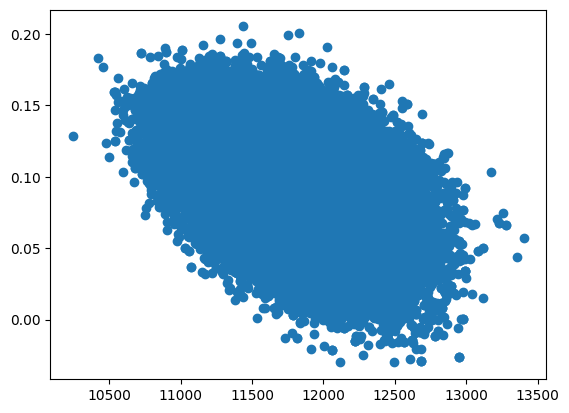

In [57]:
plt.scatter(tln_into_gp[:,0],tln_into_gp[:,1])
plt.scatter(tln_into_gp[i_inf_tln_into_gp,0],tln_into_gp[i_inf_tln_into_gp,1],color="red")

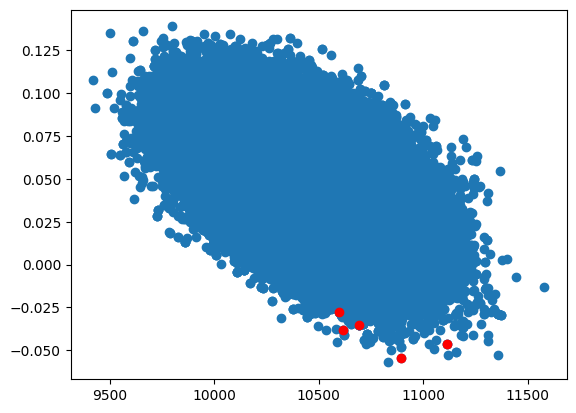

In [552]:
plt.scatter(tln_into_gp[:,0],tln_into_gp[:,1])
plt.scatter(tln_into_gp[i_inf_tln_into_gp,0],tln_into_gp[i_inf_tln_into_gp,1],color="red")


In [58]:
i_nan_tln_into_tln = np.where(np.isnan(llike_tln_into_tln))[0]
i_nan_tln_into_gp = np.where(np.isnan(llike_tln_into_gp))[0]
i_nan_tln_into_p2 = np.where(np.isnan(llike_tln_into_p2))[0]    

print("Number of NAN:\nTln into Tln = {}\nTln into GP = {}\nTln into P2 = {}".format(len(i_nan_tln_into_tln),len(i_nan_tln_into_gp),len(i_nan_tln_into_p2)))

Number of NAN:
Tln into Tln = 0
Tln into GP = 0
Tln into P2 = 114


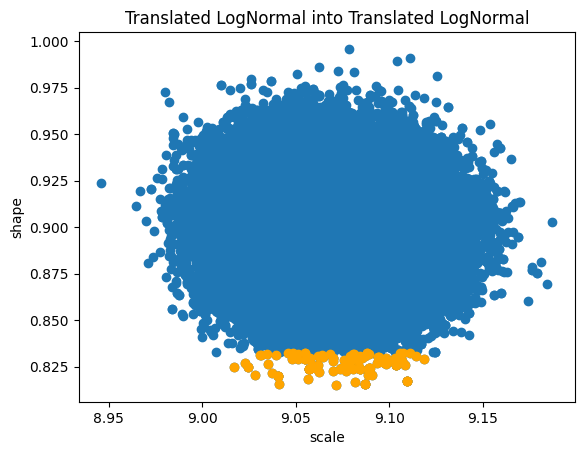

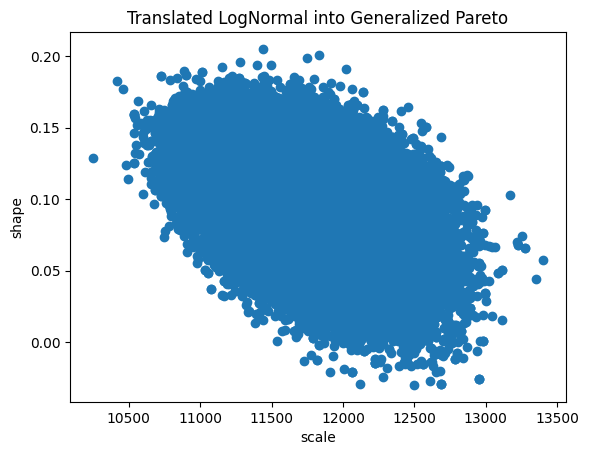

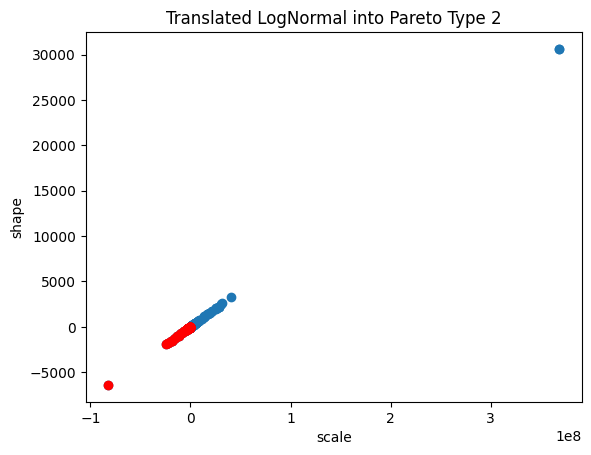

In [59]:
plt.scatter(tln_into_tln[:,0],tln_into_tln[:,1])
plt.scatter(tln_into_tln[i_nan_tln_into_tln,0],tln_into_tln[i_nan_tln_into_tln,1],color="red")
plt.scatter(tln_into_tln[i_nan_tln_into_p2,0],tln_into_tln[i_nan_tln_into_p2,1],color="orange")
plt.title("Translated LogNormal into Translated LogNormal")
plt.xlabel("scale")
plt.ylabel("shape")
plt.show()

plt.scatter(tln_into_gp[:,0],tln_into_gp[:,1],label="Translated LogNormal into Generalized Pareto")
plt.scatter(tln_into_gp[i_nan_tln_into_gp,0],tln_into_gp[i_nan_tln_into_gp,1],color="red")
plt.title("Translated LogNormal into Generalized Pareto")
plt.xlabel("scale")
plt.ylabel("shape")
plt.show()

plt.scatter(tln_into_p2[:,0],tln_into_p2[:,1],label="Translated LogNormal into Pareto Type 2")
plt.scatter(tln_into_p2[i_nan_tln_into_p2,0],tln_into_p2[i_nan_tln_into_p2,1],color="red")
plt.title("Translated LogNormal into Pareto Type 2")
plt.xlabel("scale")
plt.ylabel("shape")
plt.show()

In [158]:
mean,std = theta_tln.T
print(len(np.where((mean-loc)**2>std**2)[0]),len(np.where(np.isnan(llike_tln_into_p2))[0]))
(np.where((mean-loc)**2>std**2)[0]==np.where(np.isnan(llike_tln_into_p2))[0]).all()


114 114


True

In [153]:
mean,std = theta_tln[np.where(np.isnan(llike_tln_into_p2))[0]].T
std**2-(mean-loc)**2


array([-3125152.74518985, -3125152.74518985, -1652918.41485134,
       -3424929.78555246, -3424929.78555246,  -431527.17901453,
        -989529.70547375, -3483029.91324398,  -928483.25270045,
       -4833717.90849239, -7796661.45303544,  -541888.73235682,
       -3364579.98011798, -3364579.98011798, -1376481.42016017,
        -282221.43711054,   -51168.43282741, -2706898.63318318,
        -247267.76196185,  -169297.36570659, -1596037.07100442,
        -348027.87932551, -4081594.01084185,  -289508.36273193,
       -1164912.95930198,  -225338.52757305, -1546830.73911059,
       -1553989.59383151, -1255847.85478026,  -272939.01445726,
       -4451694.67436835, -2028463.62308639, -5120384.7584177 ,
       -3960783.08615768, -2872954.25598013, -1487069.05524951,
       -2344970.61529383, -2485961.50196341, -2485961.50196341,
       -7936960.81709138, -7936960.81709138, -7936960.81709138,
        -732621.98235795, -4232949.61526582, -4232949.61526582,
       -4265992.04512548, -1056895.88930

### GP

In [60]:
llike_gp_into_gp = np.array([np.sum(genpareto(c=gp_into_gp[i,1], scale=gp_into_gp[i,0],loc=loc).logpdf(Y_gp[i])) for i in tqdm(range(len(Y_gp)))])
print("ok")
llike_gp_into_tln = np.array([np.sum(lognorm(s=gp_into_tln[i,1], scale=np.exp(gp_into_tln[i,0]),loc=loc).logpdf(Y_gp[i])) for i in tqdm(range(len(Y_gp)))])
print("ok")
llike_gp_into_p2 = np.array([np.sum(pareto2(loc=loc,scale=gp_into_p2[i,0],shape=gp_into_p2[i,1]).logpdf(Y_gp[i])) for i in tqdm(range(len(Y_gp)))])


  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [01:52<00:00, 1783.66it/s]


ok


100%|██████████| 200000/200000 [01:33<00:00, 2147.35it/s]


ok


100%|██████████| 200000/200000 [00:04<00:00, 42603.80it/s]


In [61]:
print("Means:\nLlike_gp(Y_gp|theta_gp) = {}\nLlike_tln(Y_gp|theta_gp) = {}\nLlike_p2(Y_gp|theta_gp) = {}\n".format(np.mean(llike_gp_into_gp),np.mean(llike_gp_into_tln),np.mean(llike_gp_into_p2)))

Means:
Llike_gp(Y_gp|theta_gp) = -13494.077318189662
Llike_tln(Y_gp|theta_gp) = -14240.702115846701
Llike_p2(Y_gp|theta_gp) = nan



In [62]:
i_nan_gp_into_gp = np.where(np.isnan(llike_gp_into_gp))[0]
i_nan_gp_into_tln = np.where(np.isnan(llike_gp_into_tln))[0]
i_nan_gp_into_p2 = np.where(np.isnan(llike_gp_into_p2))[0]

print("Number of NAN :\nGP into GP = {} GP into TLN = {} GP into P2 = {}".format(len(i_nan_gp_into_gp),len(i_nan_gp_into_tln),len(i_nan_gp_into_p2)))  

Number of NAN :
GP into GP = 0 GP into TLN = 0 GP into P2 = 200000


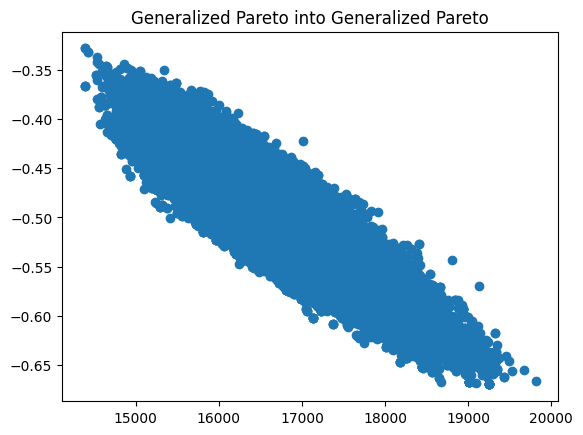

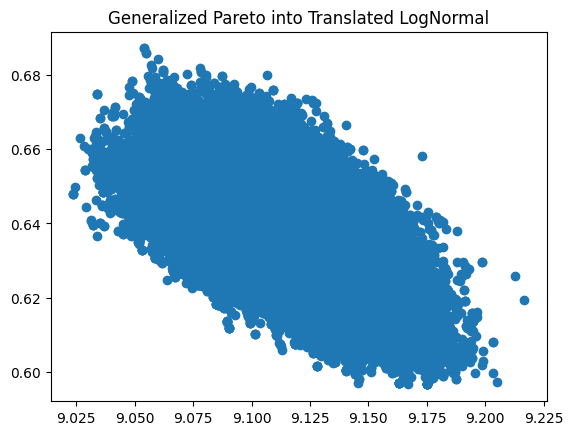

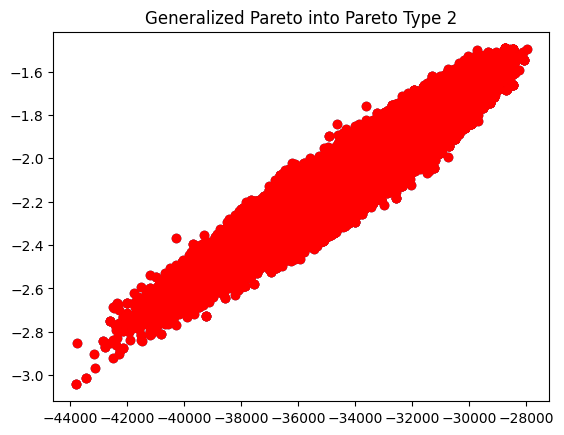

In [63]:

plt.scatter(gp_into_gp[:,0],gp_into_gp[:,1],label="Generalized Pareto into Generalized Pareto")
plt.scatter(gp_into_gp[i_nan_gp_into_gp,0],gp_into_gp[i_nan_gp_into_gp,1],color="red")
plt.title("Generalized Pareto into Generalized Pareto")
plt.show()

plt.scatter(gp_into_tln[:,0],gp_into_tln[:,1],label="Generalized Pareto into Translated LogNormal")
plt.scatter(gp_into_tln[i_nan_gp_into_tln,0],gp_into_tln[i_nan_gp_into_tln,1],color="red")
plt.title("Generalized Pareto into Translated LogNormal")
plt.show()

plt.scatter(gp_into_p2[:,0],gp_into_p2[:,1],label="Generalized Pareto into Pareto Type 2")
plt.scatter(gp_into_p2[i_nan_gp_into_p2,0],gp_into_p2[i_nan_gp_into_p2,1],color="red")
plt.title("Generalized Pareto into Pareto Type 2")
plt.show()


### P2 

In [64]:
llike_p2_into_p2 = np.array([np.sum(pareto2(loc=loc,scale=p2_into_p2[i,0],shape=p2_into_p2[i,1]).logpdf(Y_p2[i])) for i in tqdm(range(len(Y_p2)))])
print("ok")
llike_p2_into_tln = np.array([np.sum(lognorm(s=p2_into_tln[i,1], scale=np.exp(p2_into_tln[i,0]),loc=loc).logpdf(Y_p2[i])) for i in tqdm(range(len(Y_p2)))])
print("ok")
llike_p2_into_gp = np.array([np.sum(genpareto(c=p2_into_gp[i,1], scale=p2_into_gp[i,0],loc=loc).logpdf(Y_p2[i])) for i in tqdm(range(len(Y_p2)))])

  0%|          | 0/200000 [00:00<?, ?it/s]

100%|██████████| 200000/200000 [00:12<00:00, 16097.01it/s]


ok


100%|██████████| 200000/200000 [01:33<00:00, 2148.47it/s]


ok


100%|██████████| 200000/200000 [01:39<00:00, 2016.85it/s]


In [65]:
print("Means:\nLlike_p2(Y_p2|theta_p2) = {}\nLlike_tln(Y_p2|theta_p2) = {}\nLlike_gp(Y_p2|theta_p2) = {}\n".format(np.mean(llike_p2_into_p2),np.mean(llike_p2_into_tln),np.mean(llike_p2_into_gp)))

Means:
Llike_p2(Y_p2|theta_p2) = -13732.134358288502
Llike_tln(Y_p2|theta_p2) = -13948.112374541599
Llike_gp(Y_p2|theta_p2) = -13732.134358288502



In [66]:
i_nan_p2_into_p2 = np.where(np.isnan(llike_p2_into_p2))[0]
i_nan_p2_into_tln = np.where(np.isnan(llike_p2_into_tln))[0]
i_nan_p2_into_gp = np.where(np.isnan(llike_p2_into_gp))[0]

print("Number of NAN :\nP2 into P2 = {} P2 into TLN = {} P2 into GP = {}".format(len(i_nan_p2_into_p2),len(i_nan_p2_into_tln),len(i_nan_p2_into_gp)))

Number of NAN :
P2 into P2 = 0 P2 into TLN = 0 P2 into GP = 0


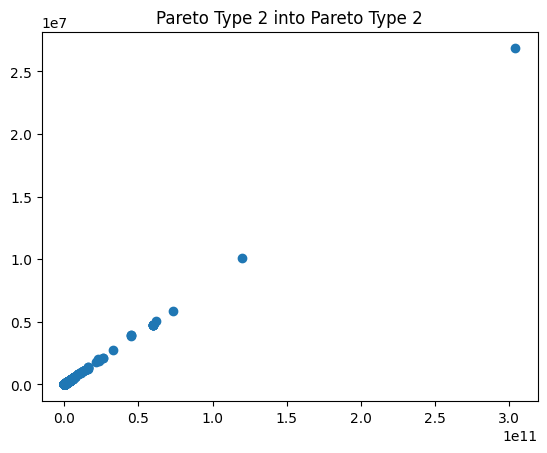

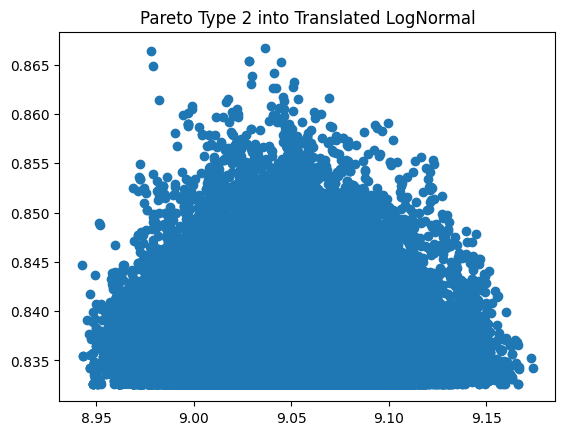

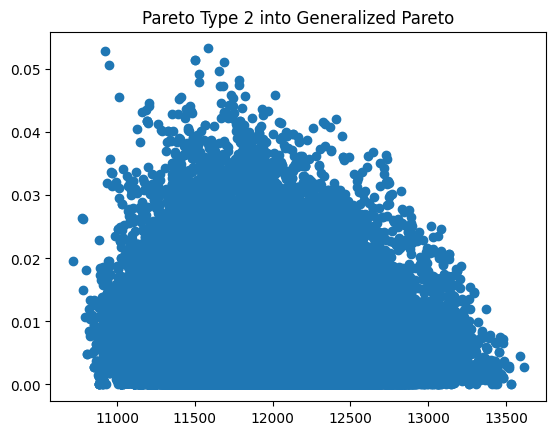

In [67]:
plt.scatter(p2_into_p2[:,0],p2_into_p2[:,1],label="Pareto Type 2 into Pareto Type 2")
plt.scatter(p2_into_p2[i_nan_p2_into_p2,0],p2_into_p2[i_nan_p2_into_p2,1],color="red")
plt.title("Pareto Type 2 into Pareto Type 2")
plt.show()

plt.scatter(p2_into_tln[:,0],p2_into_tln[:,1],label="Pareto Type 2 into Translated LogNormal")
plt.scatter(p2_into_tln[i_nan_p2_into_tln,0],p2_into_tln[i_nan_p2_into_tln,1],color="red")
plt.title("Pareto Type 2 into Translated LogNormal")
plt.show()

plt.scatter(p2_into_gp[:,0],p2_into_gp[:,1],label="Pareto Type 2 into Generalized Pareto")
plt.scatter(p2_into_gp[i_nan_p2_into_gp,0],p2_into_gp[i_nan_p2_into_gp,1],color="red")
plt.title("Pareto Type 2 into Generalized Pareto")
plt.show()

PARETO TYPE 2: mean = 16811.15813534866 std = 10466.26146779007
P2 into P2: scale = 27094269.64498501 shape = 2618.5838056472735
OK


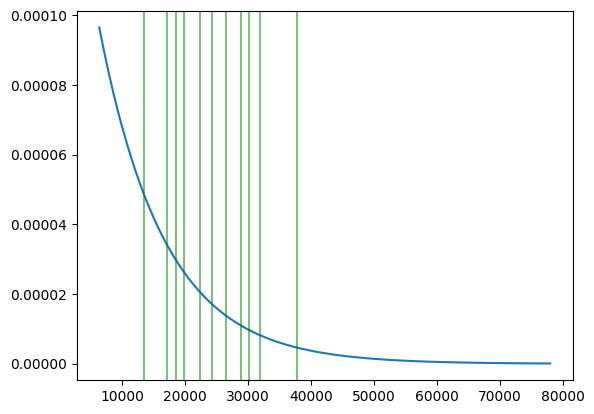

P2 into GP : scale = 10377.341569843902 shape = 0.004230710956961757
OK


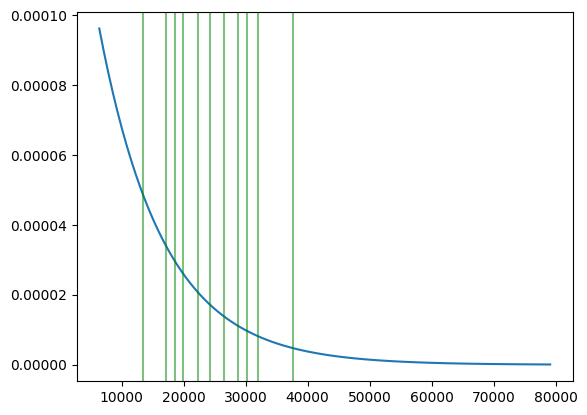

P2 into TLN : scale = 8.902639909343995 shape = 0.8351200174223075

OK


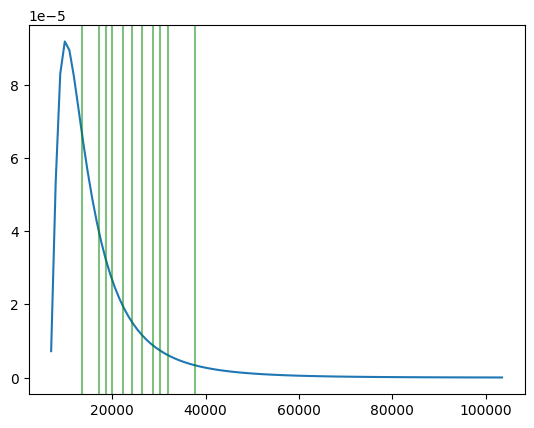

GENERALIZED PARETO: mean = 16060.172889409116 std = 7244.554478875518
GP into GP : scale = 13461.382791169788 shape = -0.39188170463657107
OK


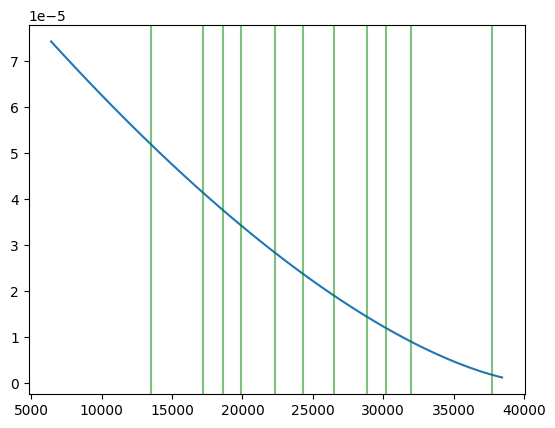

GP into P2 : scale = -34548.02275425701 shape = -2.5732590518376317
ATTENTION ! Shape > 0


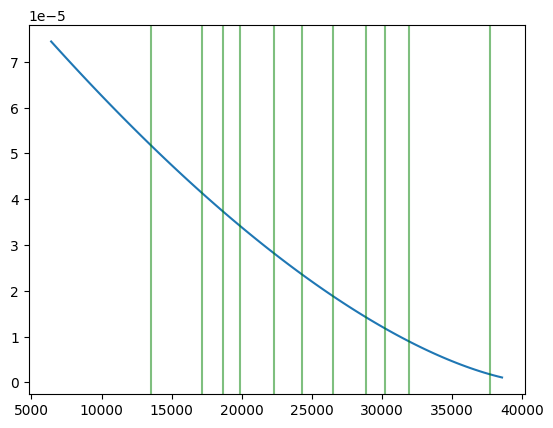

GP into TLN : scale = 8.953913893326588 shape = 0.6674059339616716

OK


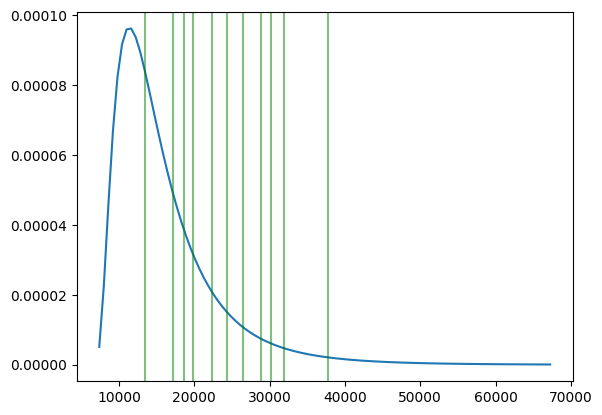

TRANSLATED LOGNORMAL: mean = 17332.02812150488 std = 11526.150655816167
TLN into TLN : scale = 8.927078579020279 shape = 0.863600887529179
OK


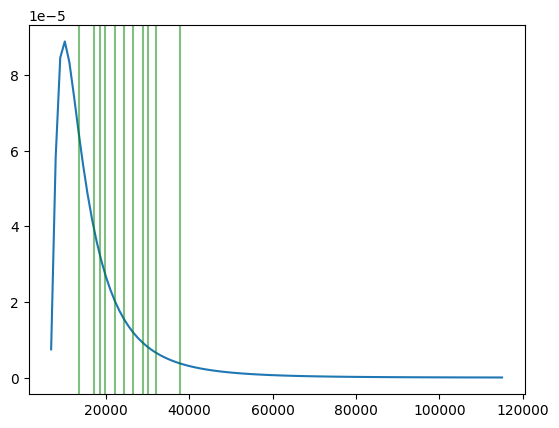

TLN into GP : scale = 10412.773439135208 shape = 0.048073292172690824


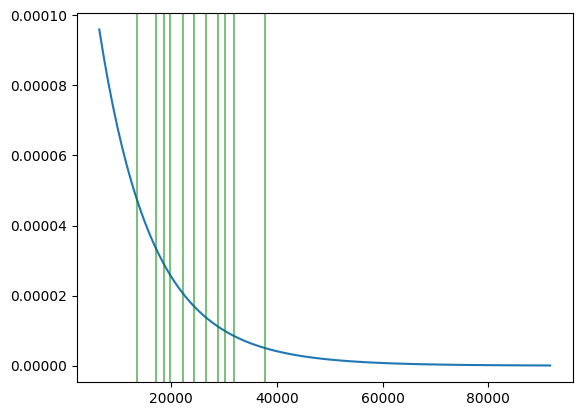

TLN into P2 : scale = 975770.1530070195 shape = 90.69876716974606


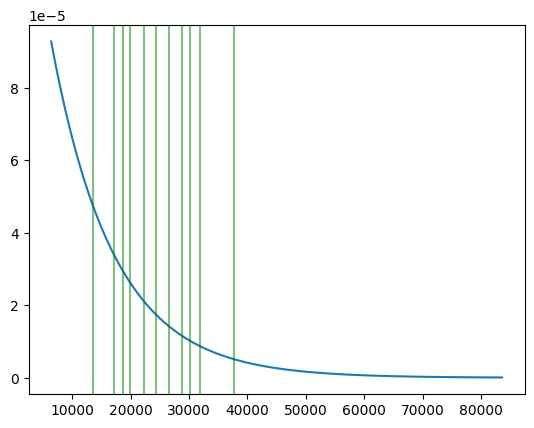

In [167]:
loc = 6389.64
print("PARETO TYPE 2: mean = {} std = {}".format(np.mean(post_mean_fix_repar_p2_r),np.mean(post_std_fix_repar_p2_r)))
print("P2 into P2: scale = {} shape = {}".format(np.mean(p2_into_p2[0]),np.mean(p2_into_p2[1])))
print("OK")
law_p2_p2 = pareto2(loc=loc,scale=np.mean(p2_into_p2[0]),shape=np.mean(p2_into_p2[1]))
x = np.linspace(law_p2_p2.ppf(.001),law_p2_p2.ppf(.999),100)
plt.plot(x,law_p2_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("P2 into GP : scale = {} shape = {}".format(np.mean(p2_into_gp[0]),np.mean(p2_into_gp[1])))
print("OK")
law_p2_gp = genpareto(c=np.mean(p2_into_gp[1]), scale=np.mean(p2_into_gp[0]),loc=loc)
x = np.linspace(law_p2_gp.ppf(.001),law_p2_gp.ppf(.999),100)
plt.plot(x,law_p2_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("P2 into TLN : scale = {} shape = {}\n".format(np.mean(p2_into_tln[0]),np.mean(p2_into_tln[1])))
print("OK")
law_p2_tln = lognorm(s=np.mean(p2_into_tln[1]), scale=np.exp(np.mean(p2_into_tln[0])),loc=loc)
x = np.linspace(law_p2_tln.ppf(.001),law_p2_tln.ppf(.999),100)
plt.plot(x,law_p2_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("GENERALIZED PARETO: mean = {} std = {}".format(np.mean(post_mean_fix_repar_gp_r),np.mean(post_std_fix_repar_gp_r)))
print("GP into GP : scale = {} shape = {}".format(np.mean(gp_into_gp[0]),np.mean(gp_into_gp[1])))
print("OK")
law_gp_gp = genpareto(c=np.mean(gp_into_gp[1]), scale=np.mean(gp_into_gp[0]),loc=loc)
x = np.linspace(law_gp_gp.ppf(.001),law_gp_gp.ppf(.999),100)
plt.plot(x,law_gp_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("GP into P2 : scale = {} shape = {}".format(np.mean(gp_into_p2[0]),np.mean(gp_into_p2[1])))
print("ATTENTION ! Shape > 0")
law_gp_p2 = pareto2(loc=loc,scale=np.mean(gp_into_p2[0]),shape=np.mean(gp_into_p2[1]))
x = np.linspace(law_gp_p2.ppf(.001),law_gp_p2.ppf(.999),100)
plt.plot(x,law_gp_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("GP into TLN : scale = {} shape = {}\n".format(np.mean(gp_into_tln[0]),np.mean(gp_into_tln[1])))
print("OK")
law_gp_tln = lognorm(s=np.mean(gp_into_tln[1]), scale=np.exp(np.mean(gp_into_tln[0])),loc=loc)
x = np.linspace(law_gp_tln.ppf(.001),law_gp_tln.ppf(.999),100)
plt.plot(x,law_gp_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()
print("TRANSLATED LOGNORMAL: mean = {} std = {}".format(np.mean(post_mean_fix_repar_tln_r),np.mean(post_std_fix_repar_tln_r)))
print("TLN into TLN : scale = {} shape = {}".format(np.mean(tln_into_tln[0]),np.mean(tln_into_tln[1])))
print("OK")
law_tln_tln = lognorm(s=np.mean(tln_into_tln[1]), scale=np.exp(np.mean(tln_into_tln[0])),loc=loc)
x = np.linspace(law_tln_tln.ppf(.001),law_tln_tln.ppf(.999),100)
plt.plot(x,law_tln_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()
print("TLN into GP : scale = {} shape = {}".format(np.mean(tln_into_gp[0]),np.mean(tln_into_gp[1])))
law_tln_gp = genpareto(c=np.mean(tln_into_gp[1]), scale=np.mean(tln_into_gp[0]),loc=loc)
x = np.linspace(law_tln_gp.ppf(.001),law_tln_gp.ppf(.999),100)
plt.plot(x,law_tln_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("TLN into P2 : scale = {} shape = {}".format(np.mean(tln_into_p2[0]),np.mean(tln_into_p2[1])))
law_tln_p2 = pareto2(loc=loc,scale=np.mean(tln_into_p2[0]),shape=np.mean(tln_into_p2[1]))
x = np.linspace(law_tln_p2.ppf(.001),law_tln_p2.ppf(.999),100)
plt.plot(x,law_tln_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()



# Inference La pointe

## Fixed Translated LN

In [21]:
from RobustGibbsObject.Model import FixedReparametrizedTranslatedLogNormalModel
from RobustGibbsObject.Distribution import Gamma,Normal

In [23]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_tln = FixedReparametrizedTranslatedLogNormalModel(mean,std)

Pointe_fix_repar_tln = fix_repar_tln.Gibbs_Quantile(51000,N_pointe,Q_pointe,P,std_prop_dict={"mean":400,"std":500},std_prop_quantile=.01,List_X=True)

Init...
Init done! {'mean': 25000, 'std': 10000}


  0%|          | 0/51000 [00:00<?, ?it/s]

100%|██████████| 51000/51000 [02:57<00:00, 287.35it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 46.85% std = 59.37% 


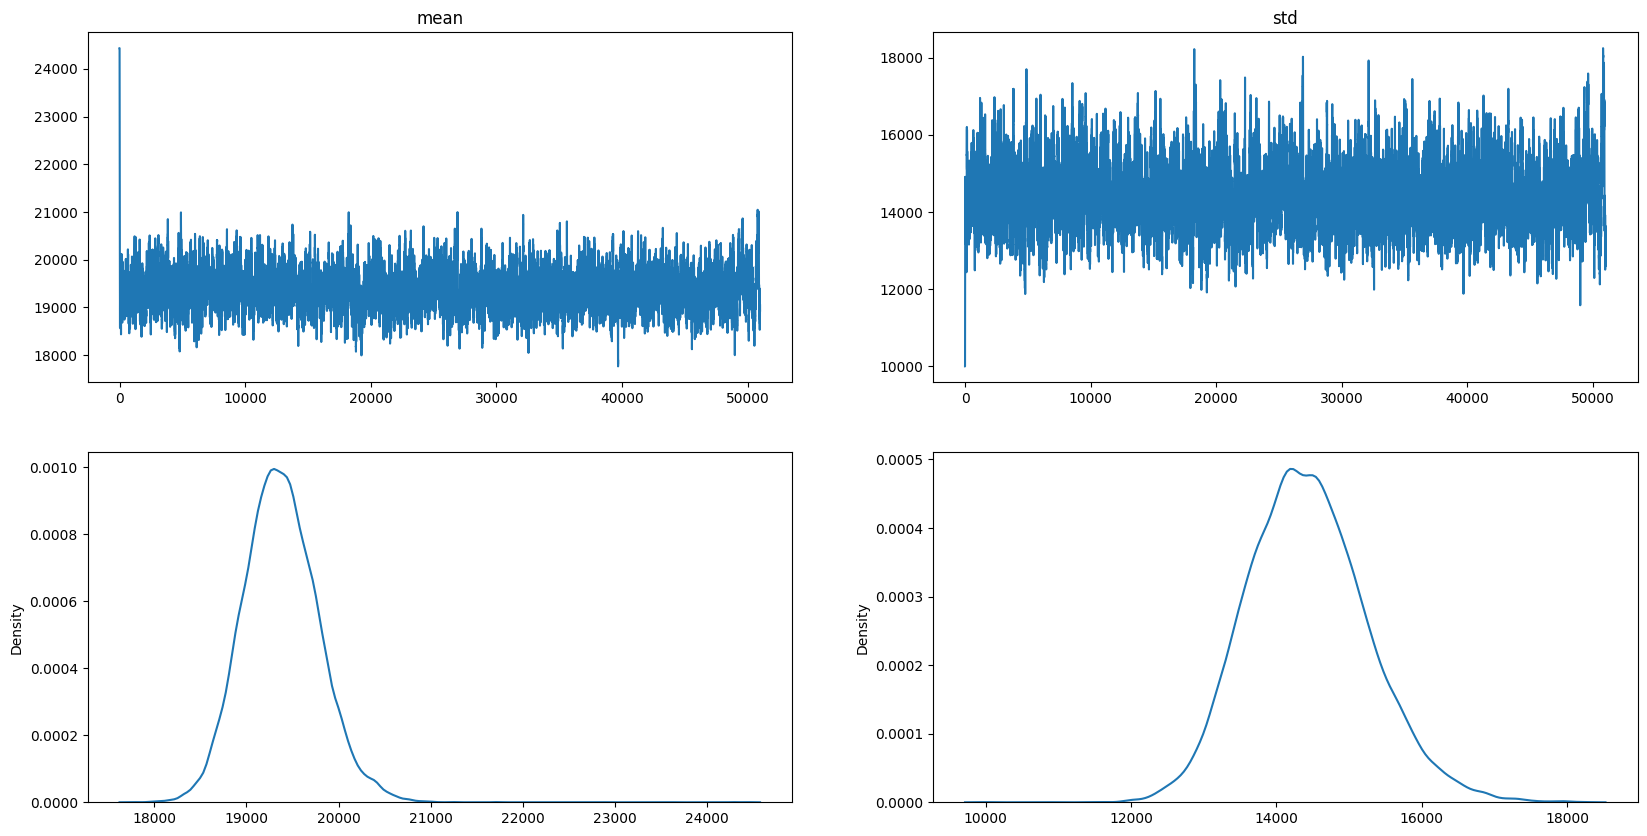

In [24]:
display(Pointe_fix_repar_tln,burnin=0)

In [83]:
mu_X = np.mean(post_mean_fix_repar_tln_lp)
sigma_X = np.mean(post_std_fix_repar_tln_lp)

(mu_X-loc)**2<sigma_X**2

True

Fixed Reparametrized Translated LogNormal:
loc = 6389.64 scale = 9.069476485944124 shape = 0.896134631437811
mean = 19376.5781135499 std = 14432.183081876972


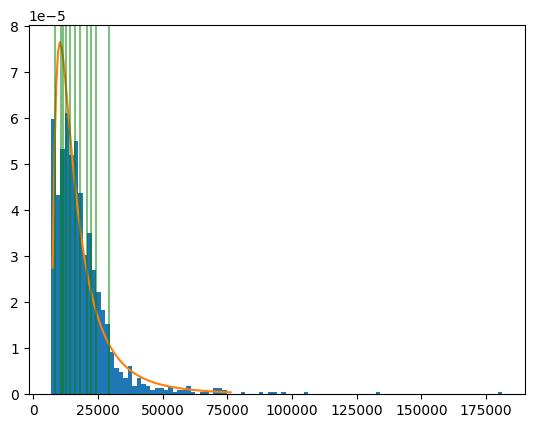

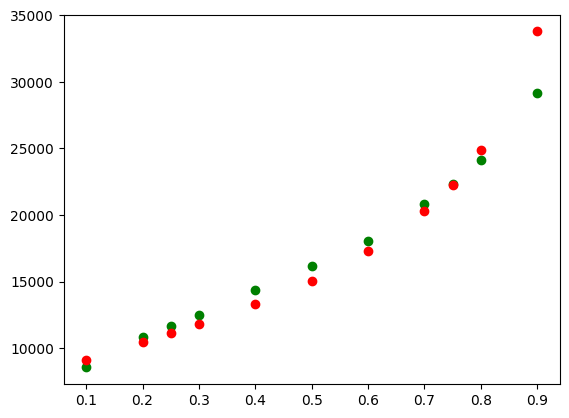

In [25]:
loc = 6389.64
burnin = 1000
post_mean_fix_repar_tln_lp= np.array(Pointe_fix_repar_tln["chains"]["mean"][burnin:])
post_std_fix_repar_tln_lp = np.array(Pointe_fix_repar_tln["chains"]["std"][burnin:])    

Y_tln = np.array(Pointe_fix_repar_tln["X"][burnin+1:])
post_scale_fix_repar_tln_lp = np.log((post_mean_fix_repar_tln_lp-loc)**2/np.sqrt((post_mean_fix_repar_tln_lp-loc)**2+(post_std_fix_repar_tln_lp)**2))
post_shape_fix_repar_tln_lp = np.sqrt(np.log(1+np.power(post_std_fix_repar_tln_lp,2)/np.power(post_mean_fix_repar_tln_lp-loc,2)))

law_fix_repar_tnl = lognorm(s=np.mean(post_shape_fix_repar_tln_lp), scale=np.mean(np.exp(post_scale_fix_repar_tln_lp)),loc=loc)
print("Fixed Reparametrized Translated LogNormal:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_tln_lp),np.mean(post_shape_fix_repar_tln_lp),np.mean(post_mean_fix_repar_tln_lp),np.mean(post_std_fix_repar_tln_lp)))
plt.hist(Pointe_fix_repar_tln["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_tnl.ppf(0.01),law_fix_repar_tnl.ppf(0.99), 100)
plt.plot(x,law_fix_repar_tnl.pdf(x))

for q in Q_pointe:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_pointe,color="green")
plt.scatter(P,law_fix_repar_tnl.ppf(P),color="red")



## Fixed Translated GP

In [26]:
from RobustGibbsObject.Model import FixedReparametrizedGeneralizedParetoModel

In [27]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_gp = FixedReparametrizedGeneralizedParetoModel(mean,std)

Pointe_fix_repar_gp = fix_repar_gp.Gibbs_Quantile(51000,N_pointe,Q_pointe,P,std_prop_dict={"mean":300,"std":100},std_prop_quantile=.01,List_X=True)

Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


  0%|          | 0/51000 [00:00<?, ?it/s]/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:77: RuntimeWarning: divide by zero encountered in true_divide
  Std_Kernel = std_prop * np.sqrt(Var_K) / (1 - G[np.where(G > 0)])
/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:87: RuntimeWarning: invalid value encountered in double_scalars
  Q_tot_star.append((Q_val[i] - Q_sim_star[j] * (1 - G[i])) / G[i])
  0%|          | 6/51000 [00:00<14:36, 58.20it/s]

100%|██████████| 51000/51000 [03:29<00:00, 243.38it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 32.32% std = 38.91% 


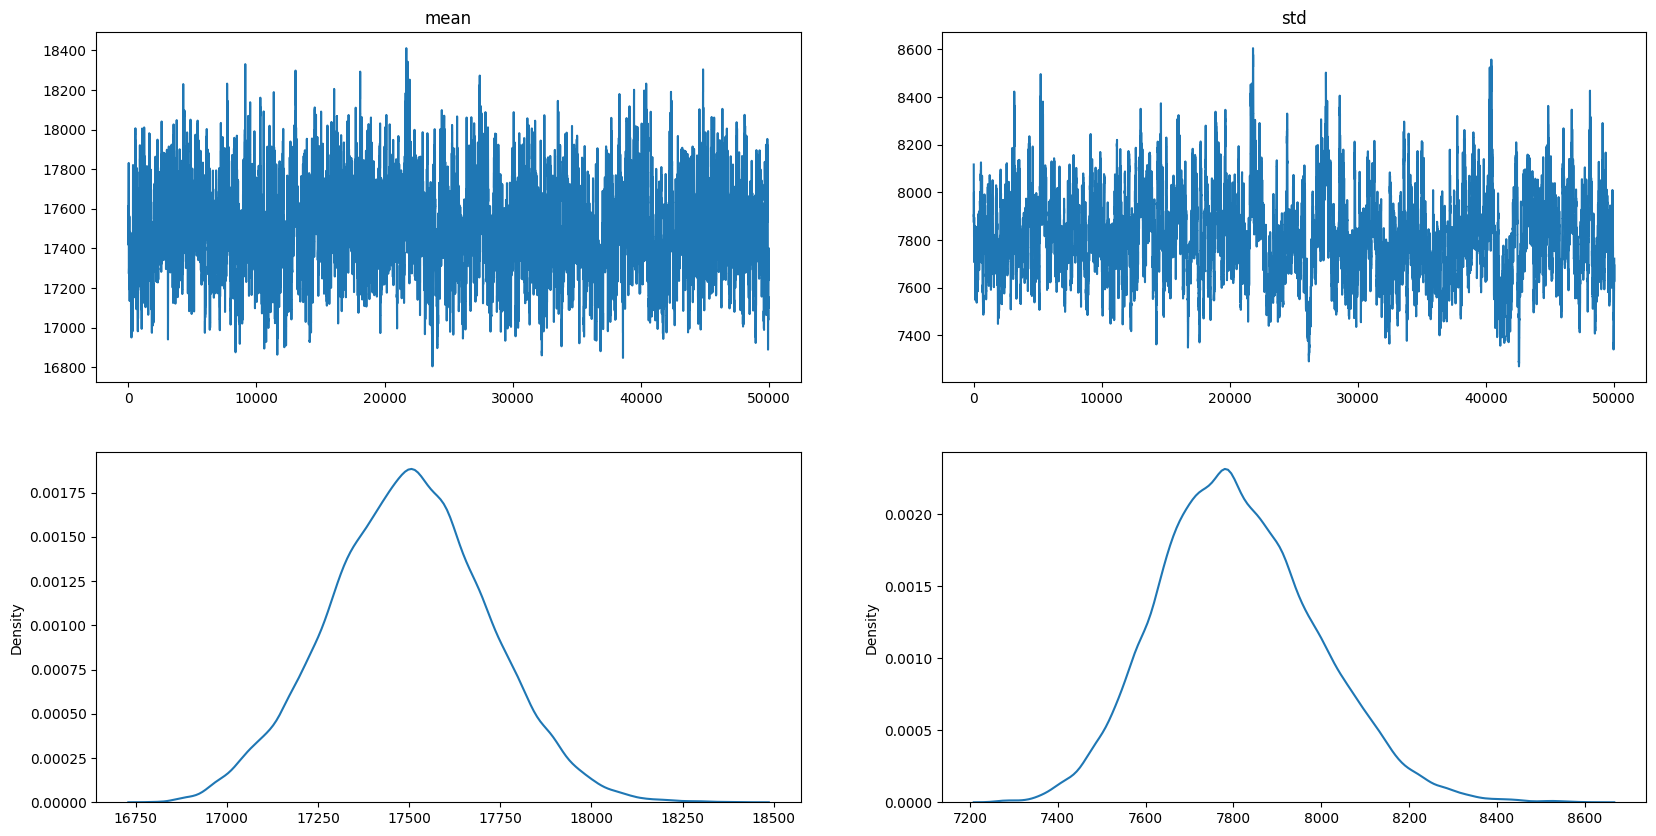

In [28]:
display(Pointe_fix_repar_gp,burnin=1000)

Fixed Reparametrized Generalized Pareto:
loc = 6389.64 scale = 16804.19577351998 shape = -0.5125004273036193
mean = 17497.34990520391 std = 7809.924868110856


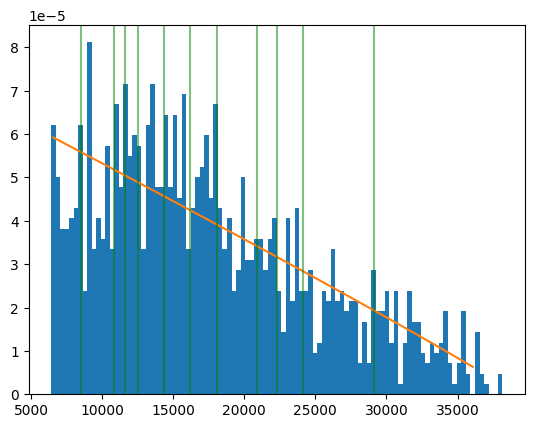

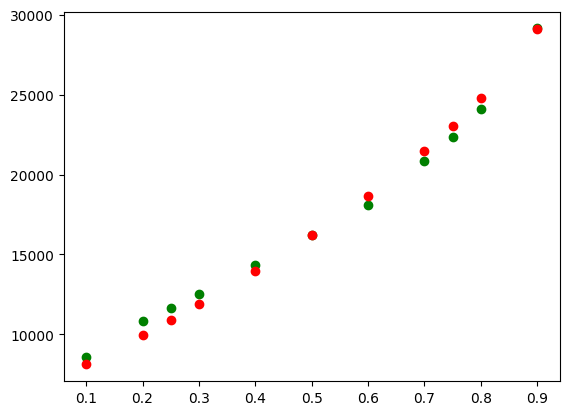

In [29]:
loc= 6389.64
burnin=1000
post_mean_fix_repar_gp_lp = np.array(Pointe_fix_repar_gp["chains"]["mean"][burnin:])
post_std_fix_repar_gp_lp = np.array(Pointe_fix_repar_gp["chains"]["std"][burnin:])
Y_gp = np.array(Pointe_fix_repar_gp["X"][burnin+1:])
post_scale_fix_repar_gp_lp = (post_mean_fix_repar_gp_lp-loc)/2+(post_mean_fix_repar_gp_lp-loc)**3/(2*post_std_fix_repar_gp_lp**2)
post_shape_fix_repar_gp_lp = 1/2-(post_mean_fix_repar_gp_lp-loc)**2/(2*post_std_fix_repar_gp_lp**2)

law_fix_repar_gp = genpareto(c=np.mean(post_shape_fix_repar_gp_lp), scale=np.mean(post_scale_fix_repar_gp_lp),loc=loc)
print("Fixed Reparametrized Generalized Pareto:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_gp_lp),np.mean(post_shape_fix_repar_gp_lp),np.mean(post_mean_fix_repar_gp_lp),np.mean(post_std_fix_repar_gp_lp)))
plt.hist(Pointe_fix_repar_gp["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_gp.ppf(0.01),law_fix_repar_gp.ppf(0.99), 100)
plt.plot(x,law_fix_repar_gp.pdf(x))

for q in Q_pointe:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_pointe,color="green")
plt.scatter(P,law_fix_repar_gp.ppf(P),color="red")



In [30]:
mu_X = np.mean(post_mean_fix_repar_gp_lp)
sigma_X = np.mean(post_std_fix_repar_gp_lp)
(mu_X-loc)**2<sigma_X**2

False

## Fixed Translated P2

In [31]:
from RobustGibbsObject.Model import FixedReparametrizedParetoType2Model
from RobustGibbsObject.Distribution import Gamma,Normal

In [33]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_p2 = FixedReparametrizedParetoType2Model(mean,std)

Pointe_fix_repar_p2 = fix_repar_p2.Gibbs_Quantile(51000,N_pointe,Q_pointe,P,std_prop_dict={"mean":70,"std":70},std_prop_quantile=.01,List_X=True)

Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 51000/51000 [00:36<00:00, 1415.59it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 49.07% std = 49.37% 


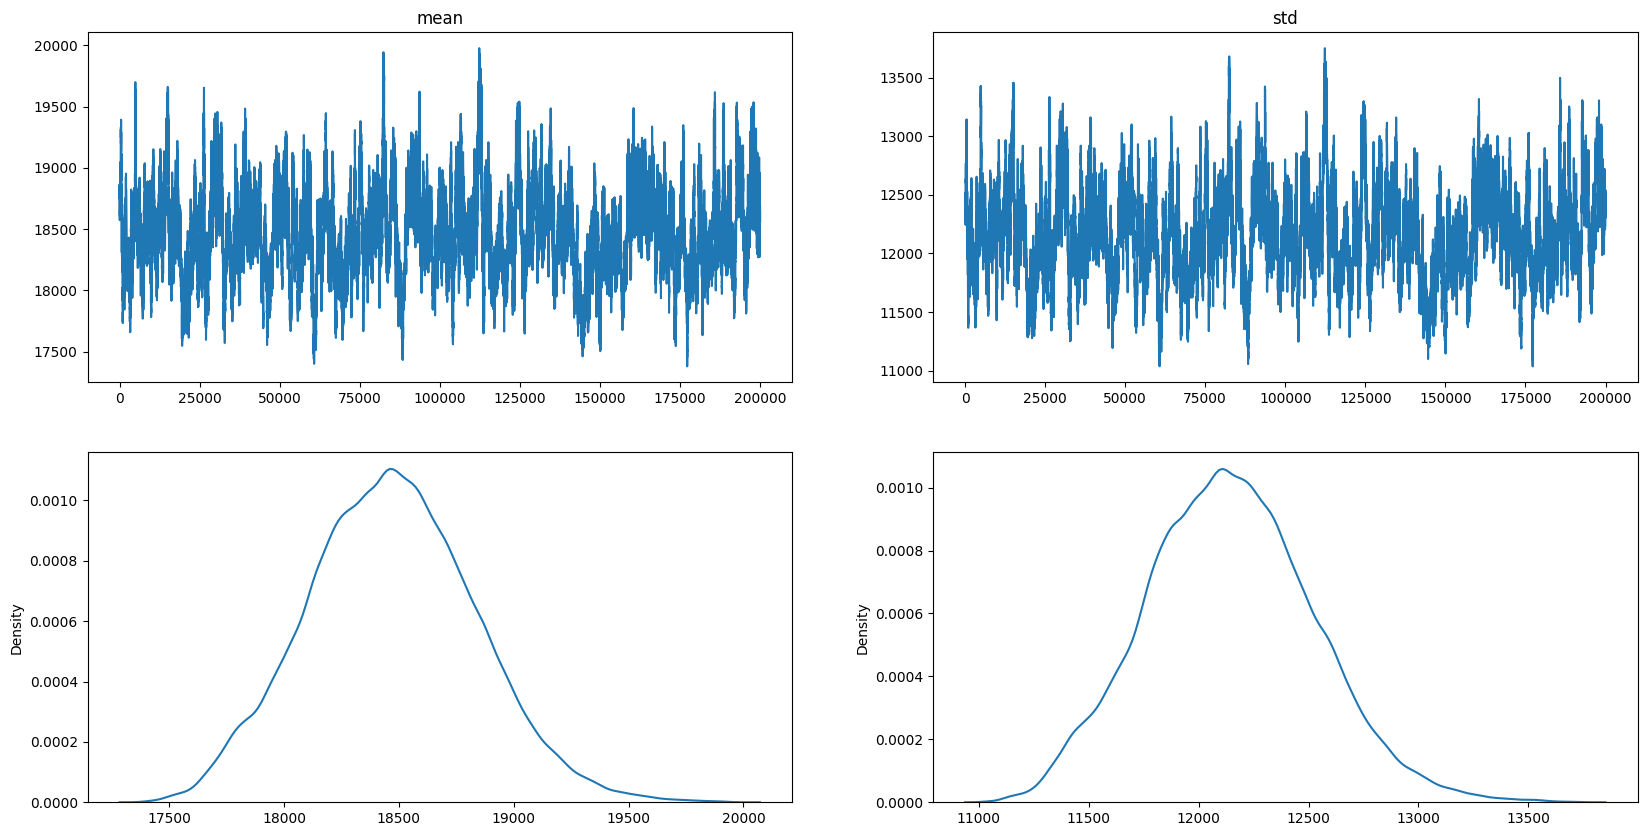

In [ ]:
display(Pointe_fix_repar_p2,burnin=1000)

In [34]:
burnin=1000
post_mean_fix_repar_p2_lp = np.array(Pointe_fix_repar_p2["chains"]["mean"][burnin:])
post_std_fix_repar_p2_lp = np.array(Pointe_fix_repar_p2["chains"]["std"][burnin:])
Y_p2 = np.array(Pointe_fix_repar_p2["X"][burnin+1:])

post_scale_fix_repar_p2_lp = (post_mean_fix_repar_p2_lp-loc)*(post_std_fix_repar_p2_lp**2+(post_mean_fix_repar_p2_lp-loc)**2)/(post_std_fix_repar_p2_lp**2-(post_mean_fix_repar_p2_lp-loc)**2)

post_shape_fix_repar_p2_lp = 2*post_std_fix_repar_p2_lp**2/(post_std_fix_repar_p2_lp**2-(post_mean_fix_repar_p2_lp-loc)**2)

law_fix_repar_p2 = pareto2(loc=loc,scale=np.mean(post_scale_fix_repar_p2_lp),shape=np.mean(post_shape_fix_repar_p2_lp))

print("Fixed Reparametrized Pareto Type 2:\nloc = {} scale = {} shape = {}\nmean = {} std = {}".format(loc,np.mean(post_scale_fix_repar_p2_lp),np.mean(post_shape_fix_repar_p2_lp),np.mean(post_mean_fix_repar_p2_lp),np.mean(post_std_fix_repar_p2_lp)))

plt.hist(Pointe_fix_repar_p2["X"][-1],bins=100,density=True);
x=np.linspace(law_fix_repar_p2.ppf(0.01),law_fix_repar_p2.ppf(0.99), 100)
plt.plot(x,law_fix_repar_p2.pdf(x))

for q in Q_pointe:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

plt.scatter(P,Q_pointe,color="green")
plt.scatter(P,law_fix_repar_p2.ppf(P),color="red")


NameError: name 'pareto2' is not defined

In [88]:
mu_X = np.mean(post_mean_fix_repar_p2_lp)
sigma_X = np.mean(post_std_fix_repar_p2_lp)

(mu_X-loc)**2<sigma_X**2

True

## Fit entre les distributions:

In [35]:
prop_tln = len(np.where((post_mean_fix_repar_tln_lp-loc)>post_std_fix_repar_tln_lp)[0])/len(post_mean_fix_repar_tln_lp)
prop_gp = len(np.where((post_mean_fix_repar_gp_lp-loc)>post_std_fix_repar_gp_lp)[0])/len(post_mean_fix_repar_gp_lp)
prop_p2 = len(np.where((post_mean_fix_repar_p2_lp-loc)>post_std_fix_repar_p2_lp)[0])/len(post_mean_fix_repar_p2_lp)
print("PROPORTION (MEAN-LOC)>STD:\nTranslated LogNormal = {} ({})\nGeneralized Pareto = {} ({})\nPareto Type 2 = {} ({})".format(prop_tln,len(np.where((post_mean_fix_repar_tln_lp-loc)>post_std_fix_repar_tln_lp)[0]),prop_gp,len(np.where((post_mean_fix_repar_gp_lp-loc)>post_std_fix_repar_gp_lp)[0]),prop_p2,len(np.where((post_mean_fix_repar_p2_lp-loc)>post_std_fix_repar_p2_lp)[0])))

PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.00038 (19)
Generalized Pareto = 1.0 (50000)
Pareto Type 2 = 0.0 (0)


In [36]:
theta_tln_lp = np.array([post_mean_fix_repar_tln_lp,post_std_fix_repar_tln_lp]).T
theta_gp_lp = np.array([post_mean_fix_repar_gp_lp,post_std_fix_repar_gp_lp]).T
theta_p2_lp = np.array([post_mean_fix_repar_p2_lp,post_std_fix_repar_p2_lp]).T

Y_p2_lp = np.array(Pointe_fix_repar_p2["X"][burnin+1:])
Y_tln_lp = np.array(Pointe_fix_repar_tln["X"][burnin+1:])
Y_gp_lp = np.array(Pointe_fix_repar_gp["X"][burnin+1:])


In [37]:
theta_tln_tln_lp = np.array(change_tln(mean = theta_tln_lp[:,0],std = theta_tln_lp[:,1])).T
theta_tln_gp_lp = np.array(change_tln(mean = theta_gp_lp[:,0],std = theta_gp_lp[:,1])).T
theta_tln_p2_lp = np.array(change_tln(mean = theta_p2_lp[:,0],std = theta_p2_lp[:,1])).T

theta_gp_gp_lp = np.array(change_gp(mean = theta_gp_lp[:,0],std = theta_gp_lp[:,1])).T
theta_gp_tln_lp = np.array(change_gp(mean = theta_tln_lp[:,0],std = theta_tln_lp[:,1])).T
theta_gp_p2_lp = np.array(change_gp(mean = theta_p2_lp[:,0],std = theta_p2_lp[:,1])).T

theta_p2_tln_lp = np.array(change_p2(mean = theta_tln_lp[:,0],std = theta_tln_lp[:,1])).T
theta_p2_gp_lp = np.array(change_p2(mean = theta_gp_lp[:,0],std = theta_gp_lp[:,1])).T
theta_p2_p2_lp = np.array(change_p2(mean = theta_p2_lp[:,0],std = theta_p2_lp[:,1])).T


In [93]:
print("TLN: mean = {} std = {}\nGP: mean = {} std = {}\nP2: mean = {} std = {}".format(np.mean(theta_tln_lp,axis=0)[0],np.mean(theta_tln_lp,axis=0)[1],np.mean(theta_gp_lp,axis=0)[0],np.mean(theta_gp_lp,axis=0)[1],np.mean(theta_p2_lp,axis=0)[0],np.mean(theta_p2_lp,axis=0)[1]))

TLN: mean = 19379.20032001047 std = 14439.486564986391
GP: mean = 17496.869724538377 std = 7813.18921863258
P2: mean = 18468.51043720526 std = 12144.421198662736


In [98]:
theta_gp_gp_lp.shape

(2, 200000)

In [99]:
print("TRANSLATED LOG NORMAL:\nFrom TLN: scale = {} shape {}\nFrom GP: scale = {} shape = {}\nFrom P2: scale = {} shape = {}".format(np.mean(theta_tln_tln_lp,axis=1)[0],np.mean(theta_tln_tln_lp,axis=1)[1],np.mean(theta_tln_gp_lp,axis=1)[0],np.mean(theta_tln_gp_lp,axis=1)[1],np.mean(theta_tln_p2_lp,axis=1)[0],np.mean(theta_tln_p2_lp,axis=1)[1]))

TRANSLATED LOG NORMAL:
In TLN: scale = 9.06951287571902 shape 0.8963333561936814
In GP: scale = 9.114091780187604 shape = 0.6340541820756515
In P2: scale = 9.049477586350193 shape = 0.8357899549830456


In [100]:
print("GENERALIZED PARETO:\nFrom GP: scale = {} shape = {}\nFrom TLN: scale = {} shape = {}\nFrom P2: scale = {} shape = {}".format(np.mean(theta_gp_gp_lp,axis=1)[0],np.mean(theta_gp_gp_lp,axis=1)[1],np.mean(theta_gp_tln_lp,axis=1)[0],np.mean(theta_gp_tln_lp,axis=1)[1],np.mean(theta_gp_p2_lp,axis=1)[0],np.mean(theta_gp_p2_lp,axis=1)[1]))

GENERALIZED PARETO:
In GP: scale = 16792.9228255913 shape = -0.5115966411773115
In TLN: scale = 11768.183371099527 shape = 0.0935459307236468
In P2: scale = 12014.378858847174 shape = 0.00532143497611054


In [101]:
print("PARETO TYPE II:\nFrom P2: scale = {} shape = {}\nFrom TLN: scale = {} shape = {}\nFrom GP: scale = {} shape = {}".format(np.mean(theta_p2_p2_lp,axis=1)[0],np.mean(theta_p2_p2_lp,axis=1)[1],np.mean(theta_p2_tln_lp,axis=1)[0],np.mean(theta_p2_tln_lp,axis=1)[1],np.mean(theta_p2_gp_lp,axis=1)[0],np.mean(theta_p2_gp_lp,axis=1)[1]))

PARETO TYPE II:
In P2: scale = 36897136.518503994 shape = 3081.624984447184
In TLN: scale = 146140.0993102694 shape = 12.354449537244893
In GP: scale = -32967.50650607738 shape = -1.9692389772865873


## Bayes Factor

### TLN vs GP

In [29]:
lratio_num = - np.array([lratio_tln_gp(Y_gp[i],mean=post_mean_fix_repar_gp_lp[i],std=post_std_fix_repar_gp_lp[i]) for i in tqdm(range(len(Y_gp)))])
lratio_den = np.array([lratio_tln_gp(Y_tln[i],mean=post_mean_fix_repar_tln_lp[i],std=post_std_fix_repar_tln_lp[i]) for i in tqdm(range(len(Y_tln)))])


100%|██████████| 200000/200000 [03:15<00:00, 1021.77it/s]


In [69]:
lratio_num2 = - lratio_den
lratio_den2 = - lratio_num

In [38]:
l1 = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln_lp,theta_tln_lp),total=len(Y_tln_lp))])
l2 = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_gp_lp,theta_gp_lp),total=len(Y_gp_lp))])

  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:56<00:00, 887.56it/s]


In [39]:
BF_tln_gp = BF_paper(l1,l2)
print("BF = {}".format(BF_tln_gp))
print("logBF = {}".format(np.log(BF_tln_gp)))

80.43717450115061
BF = 3.5227594550247904e-72
logBF = -164.52688207699208


In [40]:
BF_gp_tln = BF_paper(-l2,-l1)
print("BF = {}".format(BF_gp_tln))
print("logBF = {}".format(np.log(BF_gp_tln)))
      

741.7727284513398


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


RuntimeError: Failed to converge after 1000 iterations, value is nan

In [41]:
logBF_tln_gp = logBF_paper(l1,l2)
print("logBF = {}".format(logBF_tln_gp))

logBF = -164.52688207699208


In [42]:
logBF_gp_tln = logBF_paper(-l2,-l1)
print("logBF = {}".format(logBF_gp_tln))


logBF = 164.5268820769921


### TLN vs P2

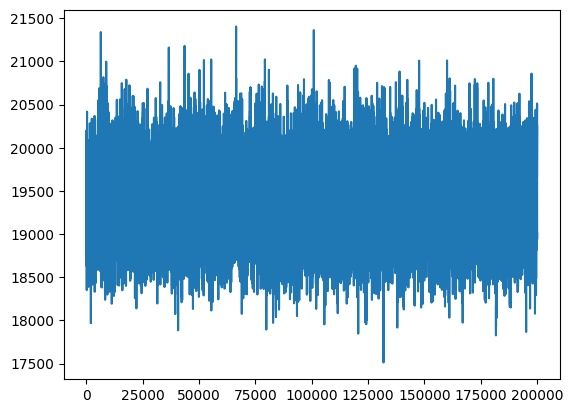

In [130]:
plt.plot(theta_tln[:,0])

Text(0, 0.5, 'Std')

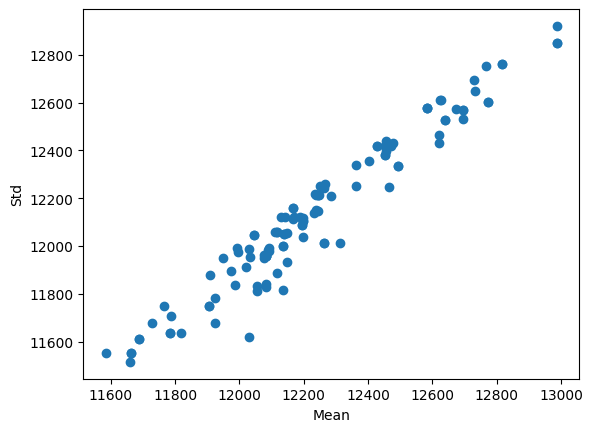

In [132]:
np.where((theta_tln[:,0]-loc)**2>theta_tln[:,1]**2)
test = theta_tln[np.where((theta_tln[:,0]-loc)**2>theta_tln[:,1]**2)]

plt.scatter(test[:,0]-loc,test[:,1],alpha=1)
plt.xlabel("Mean")
plt.ylabel("Std")

In [45]:
theta_tln2_lp = theta_tln_lp[np.where((theta_tln_lp[:,0]-loc)**2<theta_tln_lp[:,1]**2)]
Y_tln2_lp = Y_tln_lp[np.where((theta_tln_lp[:,0]-loc)**2<theta_tln_lp[:,1]**2)]

In [48]:
l1b = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln2_lp,theta_tln2_lp),total=len(Y_tln_lp))]
l2b = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_p2_lp,theta_p2_lp),total=len(Y_p2_lp))]

100%|██████████| 50000/50000 [00:26<00:00, 1864.52it/s]


In [122]:
np.where(np.isnan(l1b)),np.where(np.isnan(l2b))

((array([], dtype=int64),), (array([], dtype=int64),))

In [49]:
BF_tln_p2 = BF_paper(l1b,l2b)
print("BF = {}".format(BF_tln_p2))
print("logBF = {}".format(np.log(BF_tln_p2)))
BF_p2_tln = BF_paper(-np.array(l2b),-np.array(l1b))
print("BF = {}".format(BF_p2_tln))
print("logBF = {}".format(np.log(BF_p2_tln)))
      

80.43926333669594
BF = 0.00032087826247638516
logBF = -8.04444875138754
212.79160939639667
BF = 3116.44669315547
logBF = 8.044448751387543


In [ ]:
logBF_tln_p2 = logBF_paper(l1b,l2b)
print("logBF = {}".format(logBF_tln_p2))
logBF_p2_tln = logBF_paper(-np.array(l2b) ,-np.array(l1b))
print("logBF = {}".format(logBF_p2_tln))


logBF = -1.758374100119435
logBF = 1.7583741001194373


In [102]:
def llike_pareto2(y, par):
    loc = 6389.64
    mean, std = par
    scale,shape = (mean-loc)*(std**2+(mean-loc)**2)/(std**2-(mean-loc)**2),2*std**2/(std**2-(mean-loc)**2)
    
    return np.sum(pareto2(loc=loc, scale=scale, shape=shape).logpdf(y))

In [103]:
def llike_genpareto(y,par):
    loc = 6389.64
    mean, std = par
    scale,shape = (mean-loc)/2+(mean-loc)**3/(2*std**2),1/2-(mean-loc)**2/(2*std**2)
    return np.sum(genpareto(loc=loc,scale=scale,c=shape).logpdf(y))

In [104]:
def llike_lognormal(y, par):
    loc = 6389.64
    mean, std = par
    scale,shape = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    return np.sum(lognorm(s=shape, scale=np.exp(scale), loc=loc).logpdf(y))


In [105]:
def change_p2(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)*(std**2+(mean-loc)**2)/(std**2-(mean-loc)**2),2*std**2/(std**2-(mean-loc)**2)
    return scale,shape

def change_gp(loc=6389.64,mean=1,std=1):
    scale,shape = (mean-loc)/2+(mean-loc)**3/(2*std**2),1/2-(mean-loc)**2/(2*std**2)
    return scale,shape

def change_tln(loc = 6389.64, mean = 1, std = 1):
    scale,shape = np.log((mean-loc)**2/np.sqrt((mean-loc)**2+std**2)),np.sqrt(np.log(1+std**2/(mean-loc)**2))
    return scale,shape

In [ ]:
theta_gp = np.array([post_mean_fix_repar_gp_r,post_std_fix_repar_gp_r]).T
theta_tln = np.array([post_mean_fix_repar_tln_r,post_std_fix_repar_tln_r]).T
theta_p2 = np.array([post_mean_fix_repar_p2_r,post_std_fix_repar_p2_r]).T



print(theta_gp.shape,theta_tln.shape,theta_p2.shape)
print(Y_gp.shape,Y_tln.shape,Y_p2.shape)


(5000, 2) (49000, 2) (100000, 2)
(5001, 4661) (49001, 4661) (0,)


In [76]:
tln_into_tln = change_tln(mean = theta_tln[:,0],std = theta_tln[:,1])
tln_into_gp = change_gp(mean = theta_tln[:,0],std = theta_tln[:,1])
tln_into_p2 = change_p2(mean = theta_tln[:,0],std = theta_tln[:,1])

gp_into_gp = change_gp(mean = theta_gp[:,0],std = theta_gp[:,1])
gp_into_tln = change_tln(mean = theta_gp[:,0],std = theta_gp[:,1])
gp_into_p2 = change_p2(mean = theta_gp[:,0],std = theta_gp[:,1])

p2_into_p2 = change_p2(mean = theta_p2[:,0],std = theta_p2[:,1])
p2_into_tln = change_tln(mean = theta_p2[:,0],std = theta_p2[:,1])
p2_into_gp = change_gp(mean = theta_p2[:,0],std = theta_p2[:,1])


In [ ]:
loc = 6389.64
print("P2 into P2: scale = {} shape = {}".format(np.mean(p2_into_p2[0]),np.mean(p2_into_p2[1])))
print("OK")
law_p2_p2 = pareto2(loc=loc,scale=np.mean(p2_into_p2[0]),shape=np.mean(p2_into_p2[1]))
x = np.linspace(law_p2_p2.ppf(.001),law_p2_p2.ppf(.999),100)
plt.plot(x,law_p2_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("P2 into GP : scale = {} shape = {}".format(np.mean(p2_into_gp[0]),np.mean(p2_into_gp[1])))
print("OK")
law_p2_gp = genpareto(c=np.mean(p2_into_gp[1]), scale=np.mean(p2_into_gp[0]),loc=loc)
x = np.linspace(law_p2_gp.ppf(.001),law_p2_gp.ppf(.999),100)
plt.plot(x,law_p2_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("P2 into TLN : scale = {} shape = {}\n".format(np.mean(p2_into_tln[0]),np.mean(p2_into_tln[1])))
print("OK")
law_p2_tln = lognorm(s=np.mean(p2_into_tln[1]), scale=np.exp(np.mean(p2_into_tln[0])),loc=loc)
x = np.linspace(law_p2_tln.ppf(.001),law_p2_tln.ppf(.999),100)
plt.plot(x,law_p2_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()


print("GP into GP : scale = {} shape = {}".format(np.mean(gp_into_gp[0]),np.mean(gp_into_gp[1])))
print("OK")
law_gp_gp = genpareto(c=np.mean(gp_into_gp[1]), scale=np.mean(gp_into_gp[0]),loc=loc)
x = np.linspace(law_gp_gp.ppf(.001),law_gp_gp.ppf(.999),100)
plt.plot(x,law_gp_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("GP into P2 : scale = {} shape = {}".format(np.mean(gp_into_p2[0]),np.mean(gp_into_p2[1])))
print("ATTENTION ! Shape > 0")
law_gp_p2 = pareto2(loc=loc,scale=np.mean(gp_into_p2[0]),shape=np.mean(gp_into_p2[1]))
x = np.linspace(law_gp_p2.ppf(.001),law_gp_p2.ppf(.999),100)
plt.plot(x,law_gp_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("GP into TLN : scale = {} shape = {}\n".format(np.mean(gp_into_tln[0]),np.mean(gp_into_tln[1])))
print("OK")
law_gp_tln = lognorm(s=np.mean(gp_into_tln[1]), scale=np.exp(np.mean(gp_into_tln[0])),loc=loc)
x = np.linspace(law_gp_tln.ppf(.001),law_gp_tln.ppf(.999),100)
plt.plot(x,law_gp_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("TLN into TLN : scale = {} shape = {}".format(np.mean(tln_into_tln[0]),np.mean(tln_into_tln[1])))
print("OK")
law_tln_tln = lognorm(s=np.mean(tln_into_tln[1]), scale=np.exp(np.mean(tln_into_tln[0])),loc=loc)
x = np.linspace(law_tln_tln.ppf(.001),law_tln_tln.ppf(.999),100)
plt.plot(x,law_tln_tln.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()
print("TLN into GP : scale = {} shape = {}".format(np.mean(tln_into_gp[0]),np.mean(tln_into_gp[1])))
law_tln_gp = genpareto(c=np.mean(tln_into_gp[1]), scale=np.mean(tln_into_gp[0]),loc=loc)
x = np.linspace(law_tln_gp.ppf(.001),law_tln_gp.ppf(.999),100)
plt.plot(x,law_tln_gp.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()

print("TLN into P2 : scale = {} shape = {}".format(np.mean(tln_into_p2[0]),np.mean(tln_into_p2[1])))
print("ATTENTION ! Scale > 0, Shape > 0")
law_tln_p2 = pareto2(loc=loc,scale=np.mean(tln_into_p2[0]),shape=np.mean(tln_into_p2[1]))
x = np.linspace(law_tln_p2.ppf(.001),law_tln_p2.ppf(.999),100)
plt.plot(x,law_tln_p2.pdf(x))
for q in Q_contes:
    plt.axvline(q,color="green",alpha=.5)
plt.show()



# Plot Weibull La pointe

In [248]:
loc = Gamma(10000,10)
scale = Gamma(1000,10)
shape = Gamma(10,10)

trans_weibull = TranslatedWeibullModel(loc=loc,scale=scale,shape=shape)

P_list = np.array([[3,7],[2,5,8],[1,4,6,9],[0,3,5,7,10],[0,1,3,4,5,6,7,9,10],[0,1,2,3,4,5,6,7,8,9,10]])
MCMC_list = []
for p in P_list:
    
    MCMC_list.append(trans_weibull.Gibbs_Quantile(201000,N_pointe,Q_pointe[p],P[p],std_prop_dict={"loc":100,"scale":300,"shape":.06},std_prop_quantile=0.01,verbose=True,List_X=True))


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  import sys


Init...
Init done! {'loc': 4140.0, 'scale': 13295.260234561814, 'shape': 1.5}


100%|██████████| 201000/201000 [13:25<00:00, 249.54it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : loc = 29.59% scale = 65.66% shape = 45.47% 
Init...
Init done! {'loc': 7070.0, 'scale': 13250.840401075026, 'shape': 1.5}


100%|██████████| 201000/201000 [12:43<00:00, 263.11it/s]


Acceptation rates MH : loc = 34.90% scale = 65.18% shape = 46.89% 
Init...
Init done! {'loc': 7290.0, 'scale': 13237.710754838843, 'shape': 1.5}


100%|██████████| 201000/201000 [12:45<00:00, 262.44it/s]


Acceptation rates MH : loc = 38.98% scale = 64.90% shape = 47.83% 
Init...
Init done! {'loc': 4600.0, 'scale': 13540.298112142344, 'shape': 1.5}


100%|██████████| 201000/201000 [13:27<00:00, 248.90it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : loc = 53.74% scale = 65.03% shape = 51.20% 
Init...
Init done! {'loc': 6280.0, 'scale': 13540.298112142344, 'shape': 1.5}


100%|██████████| 201000/201000 [13:26<00:00, 249.18it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : loc = 54.92% scale = 64.82% shape = 51.42% 
Init...
Init done! {'loc': 6280.0, 'scale': 13540.298112142344, 'shape': 1.5}


100%|██████████| 201000/201000 [13:28<00:00, 248.72it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : loc = 54.98% scale = 64.94% shape = 51.34% 


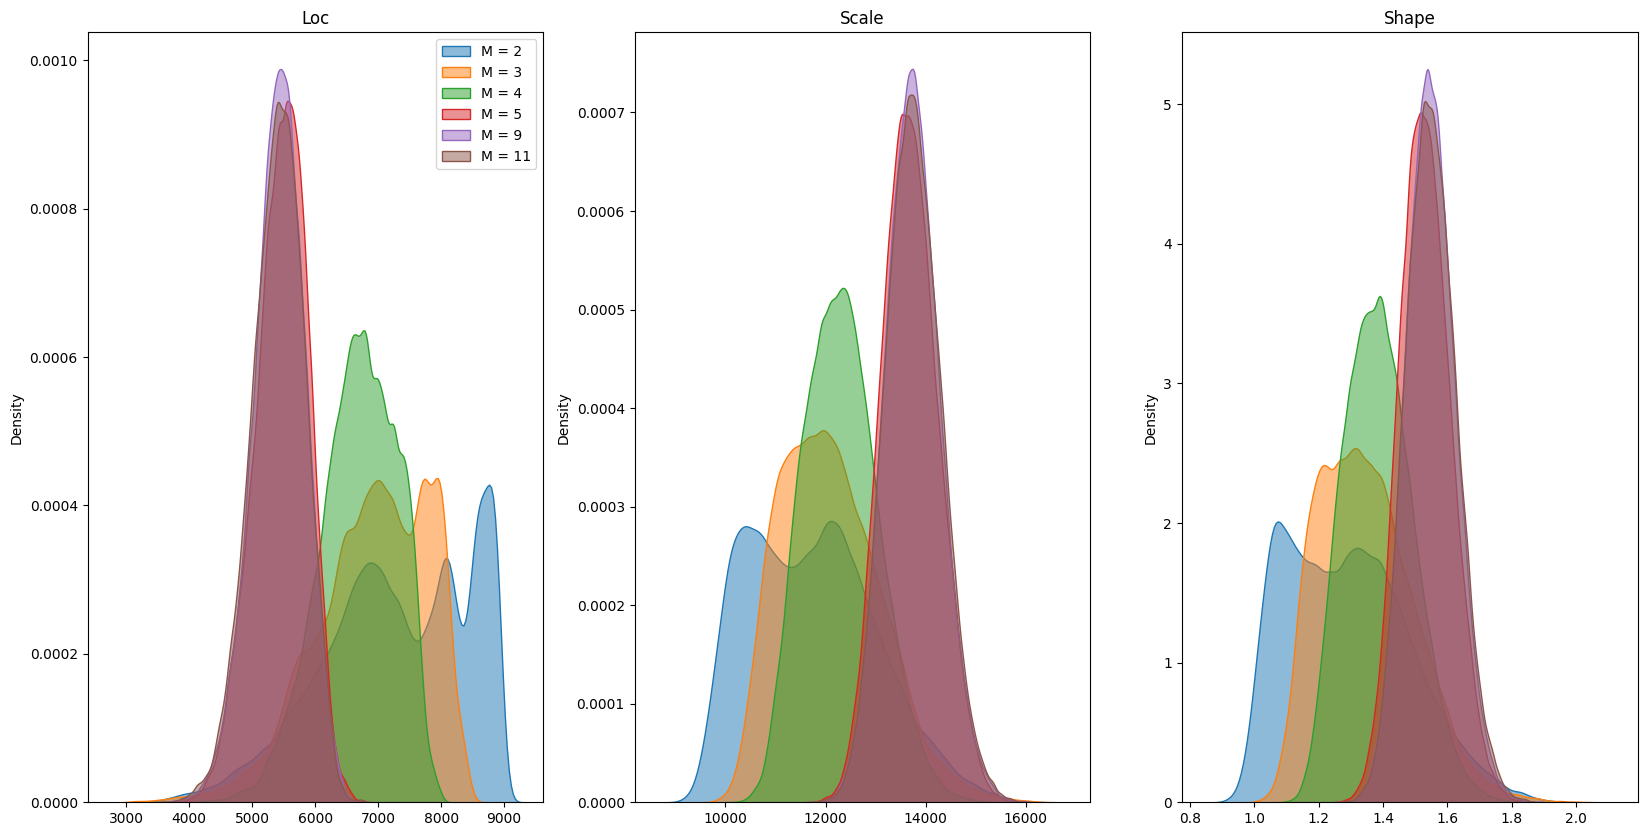

Hello


In [252]:
print("Hello")

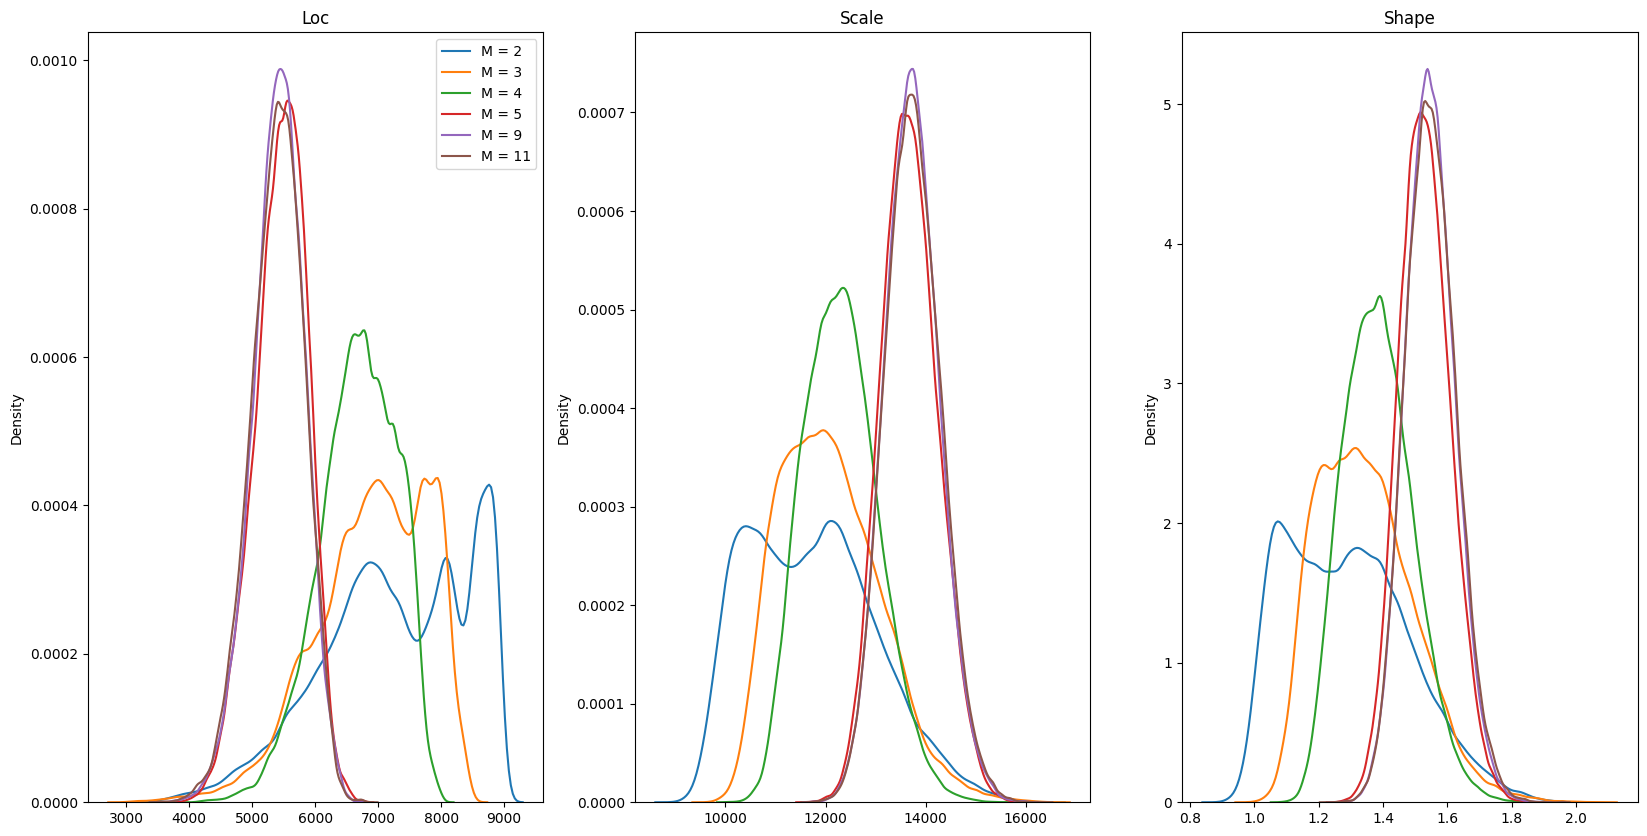

In [ ]:
f,ax = plt.subplots(1,3,figsize=(20,10))
burnin = 1000
for i,MCMC in enumerate(MCMC_list):
    sns.kdeplot(MCMC["chains"]["loc"][burnin:],ax=ax[0],label = "M = {}".format(len(P_list[i])),fill=True,alpha=.5)
    sns.kdeplot(MCMC["chains"]["scale"][burnin:],ax=ax[1],label = "M = {}".format(len(P_list[i])),fill=True,alpha=.5)
    sns.kdeplot(MCMC["chains"]["shape"][burnin:],ax=ax[2],label = "M = {}".format(len(P_list[i])),fill=True,alpha=.5)
ax[0].set_title("Loc")
ax[1].set_title("Scale")
ax[2].set_title("Shape")
ax[0].legend()
plt.show()

    

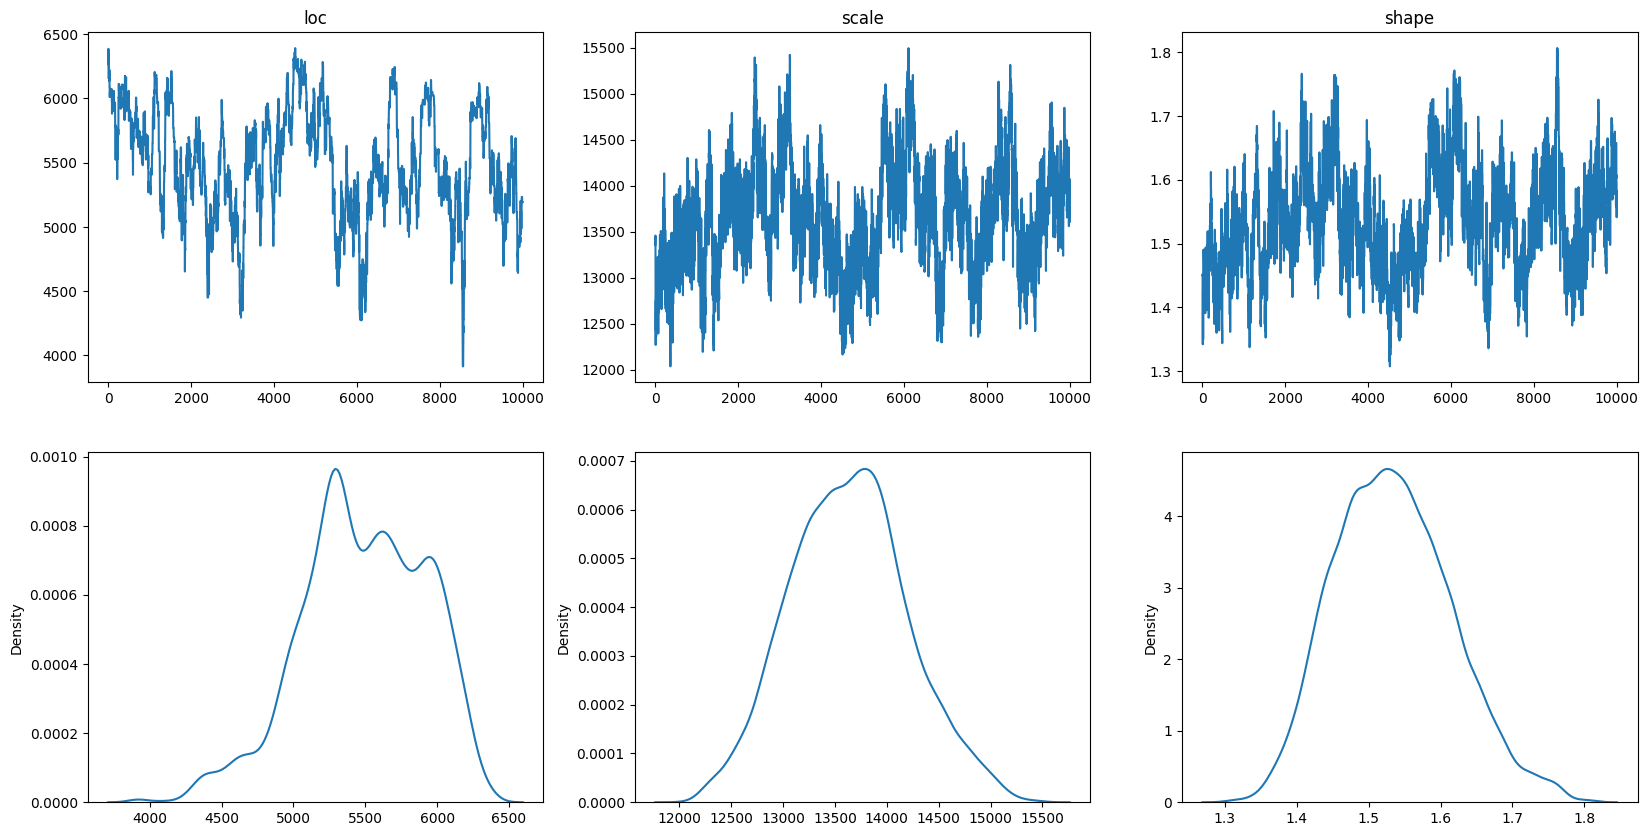

In [227]:
display(Lapointe_tw,burnin=0)

# Model Choice quand M change


In [50]:
mean = Gamma(1000,25, name="mean")
std = Gamma(1000,10, name="std")

fix_repar_gp = FixedReparametrizedGeneralizedParetoModel(mean,std)
fix_repar_tln = FixedReparametrizedTranslatedLogNormalModel(mean,std)
fix_repar_p2 = FixedReparametrizedParetoType2Model(mean,std)

P_list = [[3,7],[2,5,8],[1,4,6,9],[0,3,5,7,10],[0,1,3,4,5,6,7,9,10],[0,1,2,3,4,5,6,7,8,9,10]]
TLN_list, GP_list, P2_list = [],[],[]
T = 21000
for p in P_list: 
    fix_repar_gp = FixedReparametrizedGeneralizedParetoModel(mean,std)
    fix_repar_tln = FixedReparametrizedTranslatedLogNormalModel(mean,std)
    fix_repar_p2 = FixedReparametrizedParetoType2Model(mean,std)
    TLN_list.append(fix_repar_tln.Gibbs_Quantile(T,N_pointe,Q_pointe[p],P[p],std_prop_dict={"mean":400,"std":500},std_prop_quantile=.01,List_X=True))
    GP_list.append(fix_repar_gp.Gibbs_Quantile(T,N_pointe,Q_pointe[p],P[p],std_prop_dict={"mean":300,"std":100},std_prop_quantile=.01,List_X=True))
    P2_list.append(fix_repar_p2.Gibbs_Quantile(T,N_pointe,Q_pointe[p],P[p],std_prop_dict={"mean":70,"std":70},std_prop_quantile=.01,List_X=True))

Init...
Init done! {'mean': 25000, 'std': 10000}


/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:77: RuntimeWarning: divide by zero encountered in true_divide
  Std_Kernel = std_prop * np.sqrt(Var_K) / (1 - G[np.where(G > 0)])
/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Model.py:87: RuntimeWarning: invalid value encountered in double_scalars
  Q_tot_star.append((Q_val[i] - Q_sim_star[j] * (1 - G[i])) / G[i])
100%|██████████| 21000/21000 [01:09<00:00, 304.26it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 45.57% std = 55.73% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:19<00:00, 263.50it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 18.29% std = 17.77% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


/Users/luciano/Documents/Insufficient-Gibbs-Sampling/figures/RobustGibbsObject/Distribution.py:521: RuntimeWarning: invalid value encountered in log
  return np.where(x>=self.loc,np.log(self.shape)-np.log(self.scale)-(self.shape+1)*np.log(1+(x-self.loc)/self.scale),-np.inf)
100%|██████████| 21000/21000 [00:12<00:00, 1640.52it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 73.04% std = 74.17% 
Init...
Init done! {'mean': 25000, 'std': 10000}


100%|██████████| 21000/21000 [01:06<00:00, 315.50it/s]


Acceptation rates MH : mean = 45.38% std = 55.84% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:14<00:00, 283.35it/s]


Acceptation rates MH : mean = 18.30% std = 18.49% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 21000/21000 [00:12<00:00, 1703.06it/s]


Acceptation rates MH : mean = 68.33% std = 68.95% 
Init...
Init done! {'mean': 25000, 'std': 10000}


100%|██████████| 21000/21000 [01:10<00:00, 298.54it/s]


Acceptation rates MH : mean = 45.36% std = 54.73% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:11<00:00, 292.35it/s]


Acceptation rates MH : mean = 21.64% std = 23.23% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 21000/21000 [00:10<00:00, 1920.32it/s]


Acceptation rates MH : mean = 60.95% std = 61.59% 
Init...
Init done! {'mean': 25000, 'std': 10000}


100%|██████████| 21000/21000 [01:11<00:00, 294.69it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 46.86% std = 60.41% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:17<00:00, 269.40it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 32.63% std = 39.07% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 21000/21000 [00:12<00:00, 1628.39it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 51.12% std = 51.61% 
Init...
Init done! {'mean': 25000, 'std': 10000}


100%|██████████| 21000/21000 [01:09<00:00, 302.46it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 46.40% std = 59.89% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:16<00:00, 272.76it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 33.48% std = 40.43% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 21000/21000 [00:13<00:00, 1533.31it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 52.51% std = 51.65% 
Init...
Init done! {'mean': 25000, 'std': 10000}


100%|██████████| 21000/21000 [01:11<00:00, 293.79it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 46.10% std = 59.76% 
Init...
{'mean': 25000, 'std': 20000}
Init done! {'mean': 25000, 'std': 20000}


100%|██████████| 21000/21000 [01:19<00:00, 263.18it/s]


Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 32.98% std = 40.00% 
Init...
17000 11000
{'mean': 17000, 'std': 11000}
Init done! {'mean': 17000, 'std': 11000}


100%|██████████| 21000/21000 [00:13<00:00, 1575.80it/s]

Acceptance rate of Q 0 = 0.00%
Acceptation rates MH : mean = 47.38% std = 49.64% 


In [ ]:
def lratio_tln_gp(y,mean,std,loc):
    

In [51]:
TLN_GP = []
loc = 6389.64
TLN_P2 = []
L1,L2 = [],[]
L1b,L2b = [],[]
for i,p in enumerate(P_list):
    Y_gp = np.array(GP_list[i]["X"][1000:])
    Y_tln = np.array(TLN_list[i]["X"][1000:])
    Y_p2 = np.array(P2_list[i]["X"][1000:])
    
    theta_gp = np.array([GP_list[i]["chains"]["mean"][1000:],GP_list[i]["chains"]["std"][1000:]]).T
    theta_tln = np.array([TLN_list[i]["chains"]["mean"][1000:],TLN_list[i]["chains"]["std"][1000:]]).T
    theta_p2 = np.array([P2_list[i]["chains"]["mean"][1000:],P2_list[i]["chains"]["std"][1000:]]).T
    prop_tln = len(np.where((theta_tln[:,0]-loc)>theta_tln[:,1])[0])/len(theta_tln)
    prop_gp = len(np.where((theta_gp[:,0]-loc)>theta_gp[:,1])[0])/len(theta_gp)
    prop_p2 = len(np.where((theta_p2[:,0]-loc)>theta_p2[:,1])[0])/len(theta_p2)
    
    print("PROPORTION (MEAN-LOC)>STD:\nTranslated LogNormal = {} ({})\nGeneralized Pareto = {} ({})\nPareto Type 2 = {} ({})".format(prop_tln,len(np.where((theta_tln[:,0]-loc)>theta_tln[:,1])[0]),prop_gp,len(np.where((theta_gp[:,0]-loc)>theta_gp[:,1])[0]),prop_p2,len(np.where((theta_p2[:,0]-loc)>theta_p2[:,1])[0])))
    l1 = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln,theta_tln),total=len(Y_tln))])
    l2 = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_gp,theta_gp),total=len(Y_gp))])
    
    L1.append(l1)
    L2.append(l2)
    
    if np.isnan(l1).any() or np.isnan(l2).any():
        lbf1 = None
    else:
        lbf1 = logBF_paper(l1,l2)
    print("LogBF TLN into GP = {}".format(lbf1))
    TLN_GP.append(lbf1)
    
    # l1b = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln,theta_tln),total=len(Y_tln))]
    # l2b = [lratio_tln_p2(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_p2,theta_p2),total=len(Y_p2))]
    
    # L1b.append(l1b)
    # L2b.append(l2b)
    
    # if np.isnan(l1b).any() or np.isnan(l2b).any():
    #     lbf2 = None
    # else:
    #     lbf2 = logBF_paper(l1b,l2b)
    # print("LogBF TLN into P2 = {}".format(lbf2))
    

PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.66745 (13349)
Generalized Pareto = 0.9872 (19744)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:20<00:00, 968.26it/s]


LogBF TLN into GP = 127.75668174771232
PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.62145 (12429)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:20<00:00, 967.76it/s]


LogBF TLN into GP = 125.4331586009844
PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.7228 (14456)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:20<00:00, 963.43it/s]


LogBF TLN into GP = 125.78128374055888
PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.00025 (5)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:21<00:00, 926.69it/s]


LogBF TLN into GP = 65.07419644489221
PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.0003 (6)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:23<00:00, 865.02it/s]


LogBF TLN into GP = 67.97574135163049
PROPORTION (MEAN-LOC)>STD:
Translated LogNormal = 0.00085 (17)
Generalized Pareto = 1.0 (20000)
Pareto Type 2 = 0.0 (0)


100%|█████████▉| 20000/20001 [00:21<00:00, 945.09it/s]


LogBF TLN into GP = 67.9803804427881


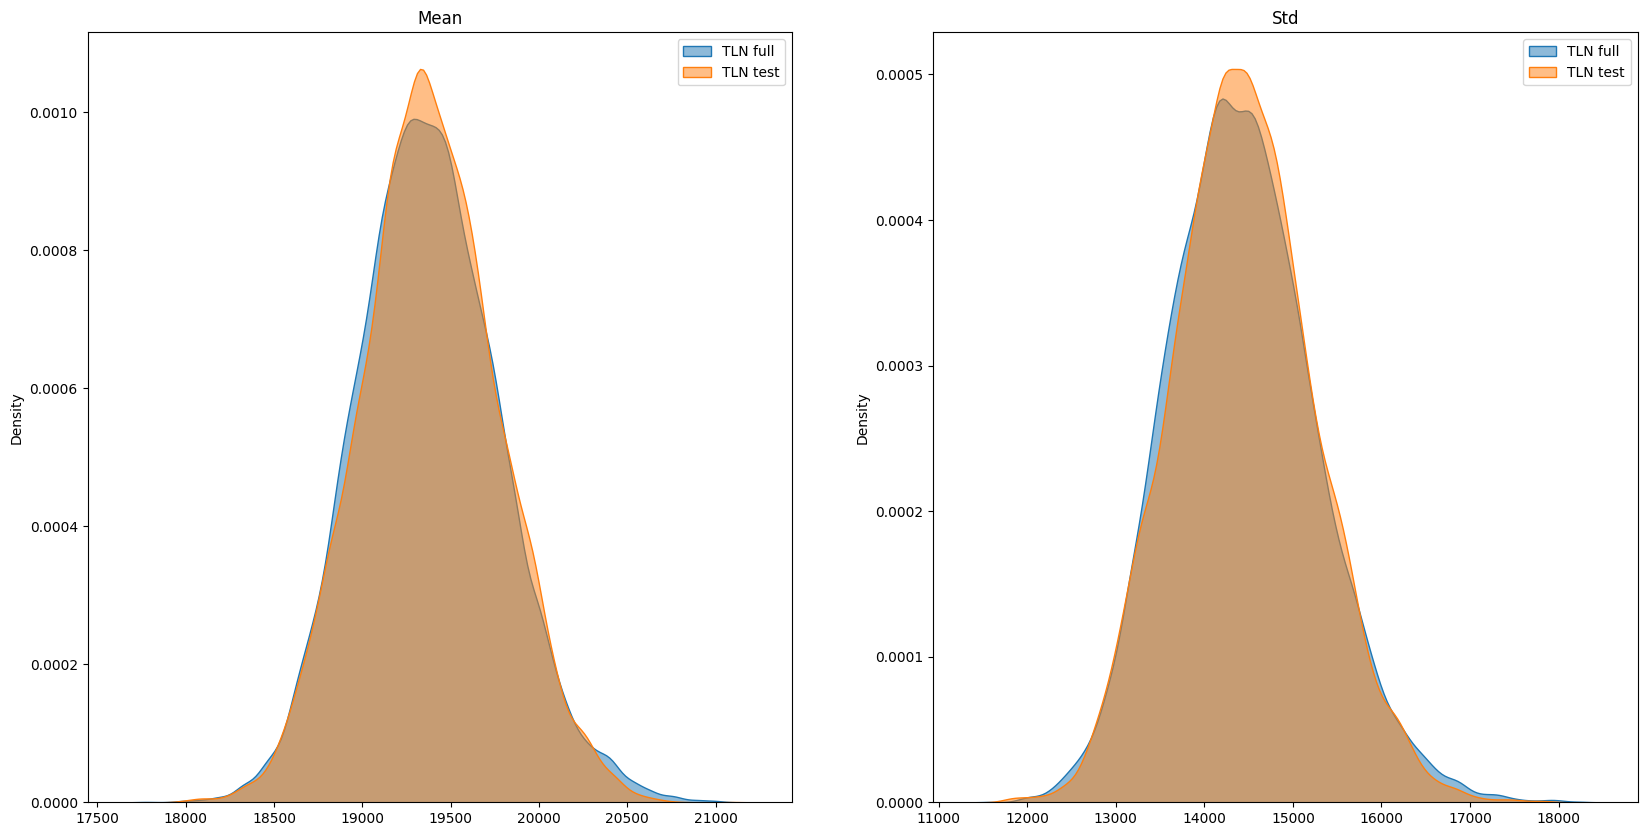

In [52]:
theta_tln_test =np.array([TLN_list[-1]["chains"]["mean"][1000:],TLN_list[-1]["chains"]["std"][1000:]]).T
Y_tln_test = np.array(TLN_list[-1]["X"][1000:])
f,ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(theta_tln_lp[:,0],ax=ax[0],label = "TLN full",fill=True,alpha=.5)
sns.kdeplot(theta_tln_test[:,0],ax=ax[0],label = "TLN test",fill=True,alpha=.5)
sns.kdeplot(theta_tln_lp[:,1],ax=ax[1],label = "TLN full",fill=True,alpha=.5)
sns.kdeplot(theta_tln_test[:,1],ax=ax[1],label = "TLN test",fill=True,alpha=.5)
ax[0].set_title("Mean")
ax[1].set_title("Std")
ax[0].legend()
ax[1].legend()
plt.show()

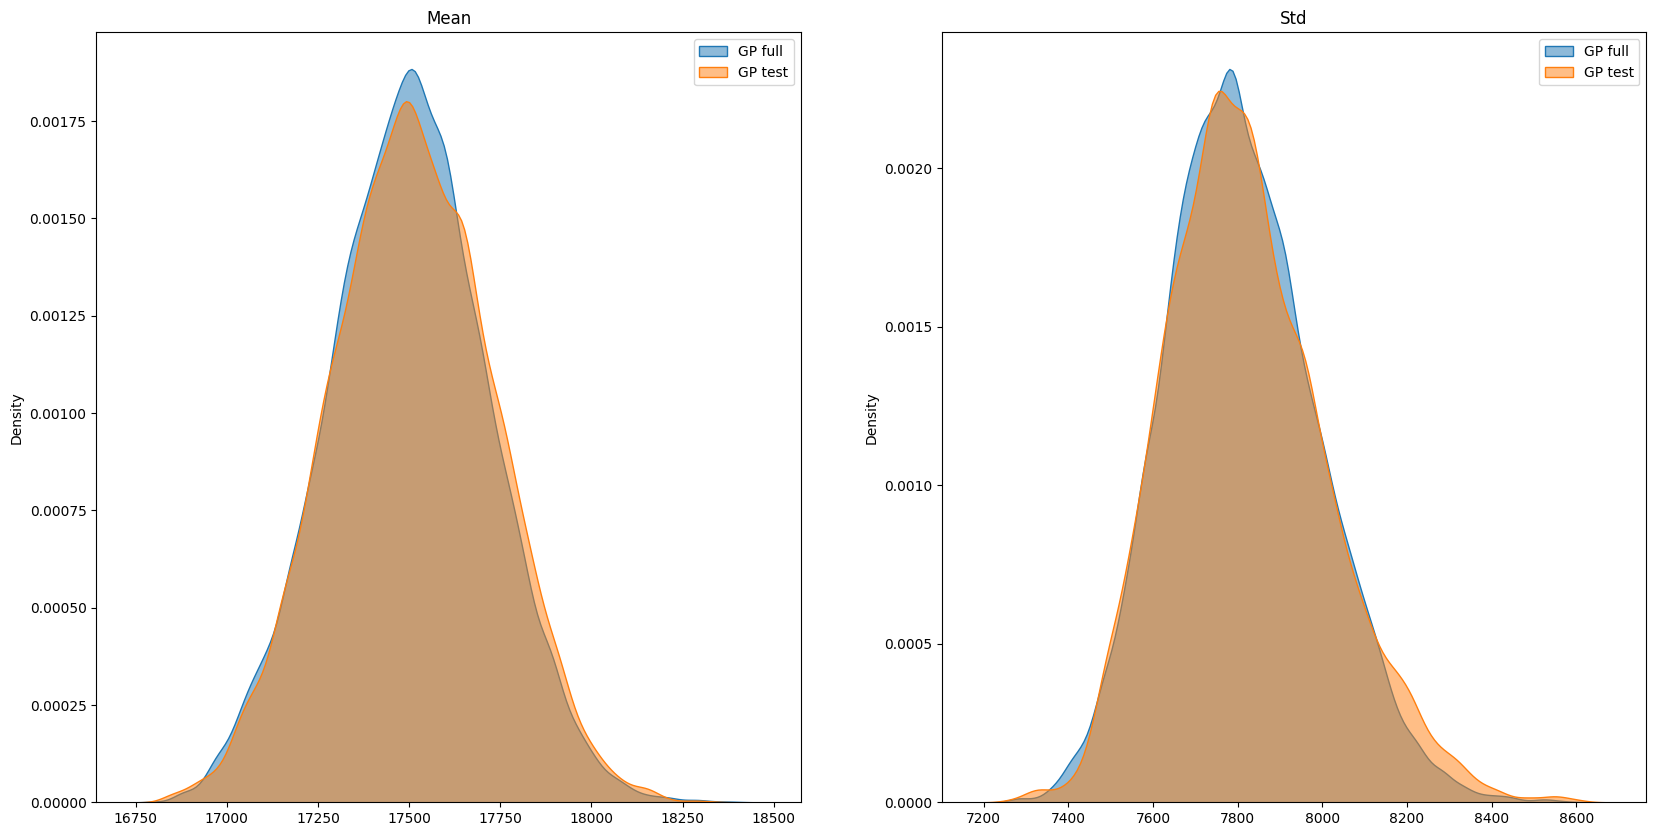

In [56]:
theta_gp_test =np.array([GP_list[-1]["chains"]["mean"][1000:],GP_list[-1]["chains"]["std"][1000:]]).T   
Y_gp_test = np.array(GP_list[-1]["X"][1000:])
f,ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(theta_gp_lp[:,0],ax=ax[0],label = "GP full",fill=True,alpha=.5)
sns.kdeplot(theta_gp_test[:,0],ax=ax[0],label = "GP test",fill=True,alpha=.5)
sns.kdeplot(theta_gp_lp[:,1],ax=ax[1],label = "GP full",fill=True,alpha=.5)
sns.kdeplot(theta_gp_test[:,1],ax=ax[1],label = "GP test",fill=True,alpha=.5)
ax[0].set_title("Mean")
ax[1].set_title("Std")
ax[0].legend()
ax[1].legend()

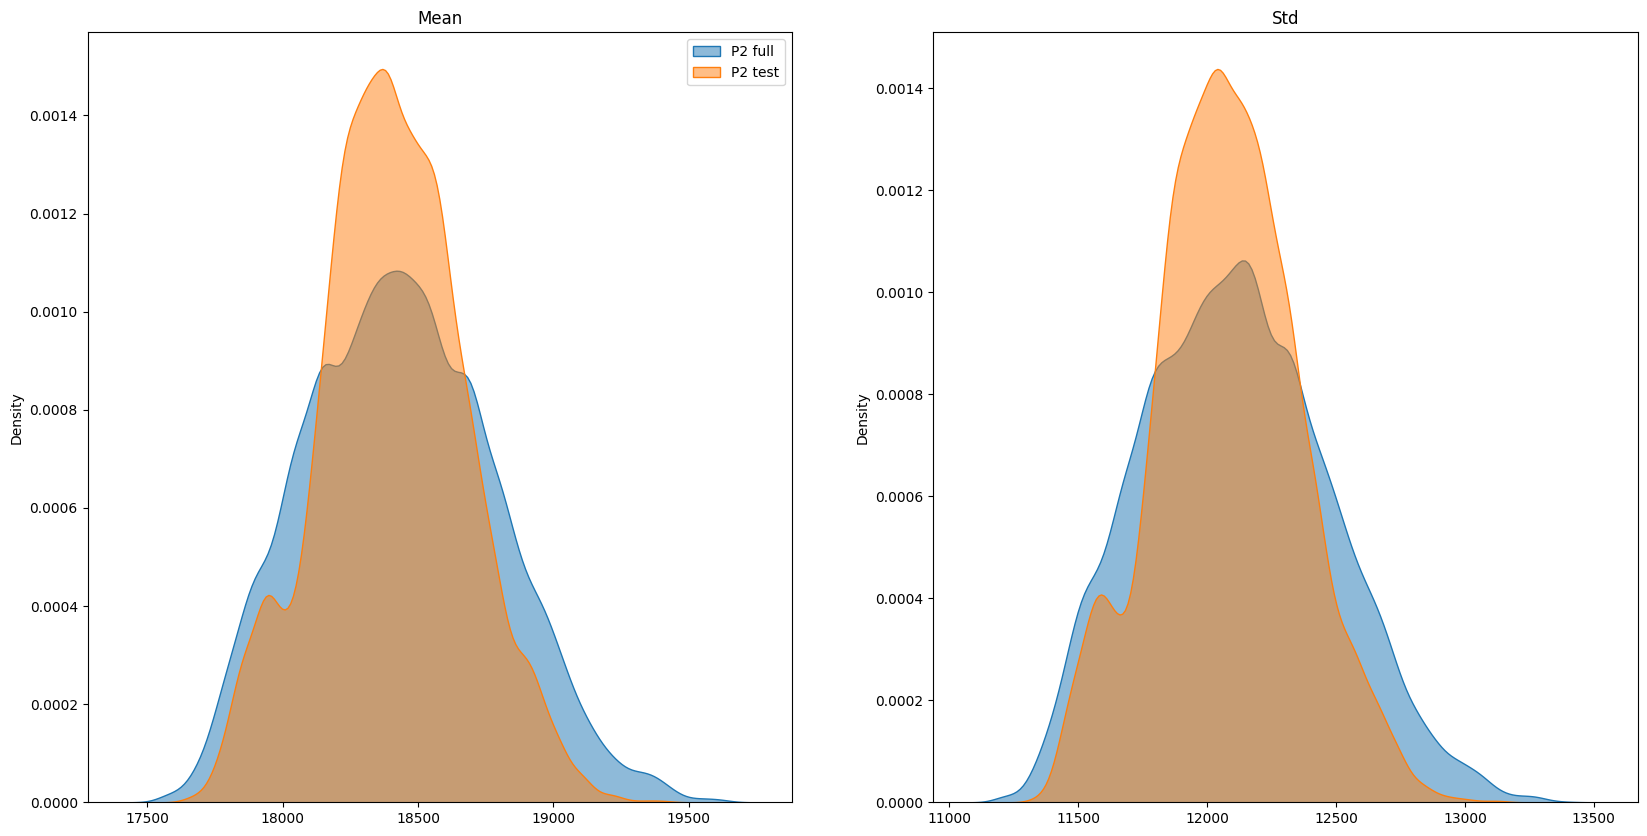

In [54]:
theta_p2_test =np.array([P2_list[-1]["chains"]["mean"][1000:],P2_list[-1]["chains"]["std"][1000:]]).T
f,ax = plt.subplots(1,2,figsize=(20,10))
sns.kdeplot(theta_p2_lp[:,0],ax=ax[0],label = "P2 full",fill=True,alpha=.5)
sns.kdeplot(theta_p2_test[:,0],ax=ax[0],label = "P2 test",fill=True,alpha=.5)
sns.kdeplot(theta_p2_lp[:,1],ax=ax[1],label = "P2 full",fill=True,alpha=.5)
sns.kdeplot(theta_p2_test[:,1],ax=ax[1],label = "P2 test",fill=True,alpha=.5)
ax[0].set_title("Mean")
ax[1].set_title("Std")
ax[0].legend()


In [133]:
l1_test = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln_test,theta_tln_test),total=len(Y_tln_test))])
l2_test = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_gp_test,theta_gp_test),total=len(Y_gp_test))])

logBF_tln_gp_test = logBF_paper(l1_test,l2_test)
print("logBF = {}".format(logBF_tln_gp_test))








































100%|█████████▉| 20000/20001 [00:20<00:00, 979.84it/s] 






























































































































































































100%|█████████▉| 20000/20001 [00:19<00:00, 1030.65it/s]


logBF = 67.98038044278823


In [135]:
len(np.where(np.isinf(l2_test))[0]),len(np.where(np.isinf(l1_test))[0])


(1413, 0)

In [136]:
theta_tln_gp_test = change_tln(mean = theta_gp_test[:,0],std = theta_gp_test[:,1])
print(theta_tln_gp_test.shape)
llike_tln = np.array([np.sum(lognorm(s=post[1], scale=np.exp(post[0]), loc=loc).logpdf(y)) for y,post in tqdm(zip(Y_gp_test,theta_tln_gp_test),total=len(Y_gp_test))])

(20000, 2)
































































































100%|█████████▉| 20000/20001 [00:09<00:00, 2070.66it/s]


In [137]:
theta_gp_gp_test = change_gp(mean = theta_gp_test[:,0],std = theta_gp_test[:,1])
llike_gp = np.array([np.sum(genpareto(c=post[1], scale=post[0],loc=loc).logpdf(y)) for y,post in tqdm(zip(Y_gp_test,theta_gp_test),total=len(Y_gp_test))])





























 58%|█████▊    | 11541/20001 [07:17<05:20, 26.38it/s]  












































































100%|█████████▉| 20000/20001 [00:10<00:00, 1854.47it/s]


In [138]:
len(np.where(np.isinf(llike_tln)==True)[0]),len(np.where(np.isinf(llike_gp)==True)[0])

(0, 0)

In [ ]:
len(Y_gp_test)-1)

In [142]:
theta_tln_gp_test = change_tln(mean = theta_gp_test[:,0],std = theta_gp_test[:,1])
theta_gp_gp_test = change_gp(mean = theta_gp_test[:,0],std = theta_gp_test[:,1])
l2_test_test = np.array([np.sum(lognorm(s=theta_tln_gp_test[i,1], scale=np.exp(theta_tln_gp_test[i,0]), loc=loc).logpdf(Y_gp_test[i])-genpareto(c=theta_gp_gp_test[i,1], scale=theta_gp_gp_test[i,0],loc=loc).logpdf(Y_gp_test[i])) for i in tqdm(range(len(Y_gp_test)-1))])





































































































































































































































































































































































































100%|██████████| 20000/20000 [00:19<00:00, 1006.85it/s]


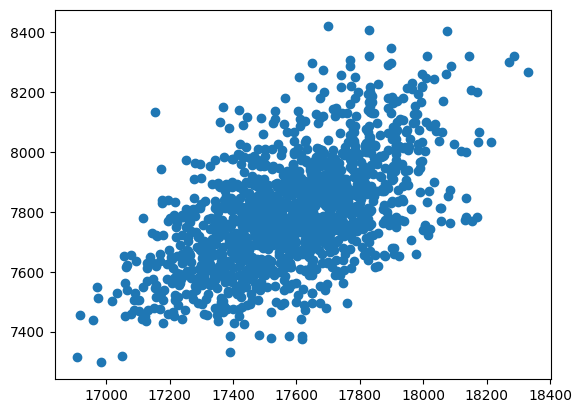

In [154]:
x,y = theta_gp_test[np.where(np.isinf(l2_test_test))[0]].T
plt.scatter(x,y)

In [100]:
np.where(np.isnan(l1_test)),np.where(np.isnan(l2_test)),np.where(np.isinf(l1_test)),np.where(np.isinf(l2_test))

((array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([], dtype=int64),),
 (array([    3,     8,    25, ..., 19937, 19942, 19983]),))

In [148]:
i_inf = np.where(np.isinf(l2_test))[0]

In [149]:
max_Y_gp_test = np.max(Y_gp_test,axis=1)[1:]
scale_gp_test,shape_gp_test = change_gp(mean = theta_gp_test[:,0],std = theta_gp_test[:,1]).T
np.where(max_Y_gp_test>loc-scale_gp_test/shape_gp_test)

(array([], dtype=int64),)

In [150]:
mean,std = theta_tln_test.T[0],theta_tln_test.T[1]
i_std = np.where((mean-loc)**2>std**2)[0]
i_inf = np.where(np.isinf(l2_test))[0]

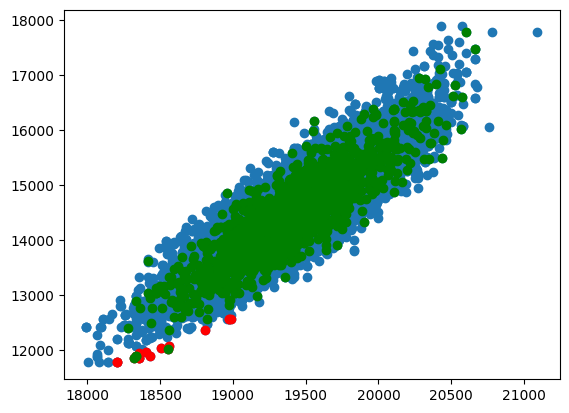

In [151]:
plt.scatter(mean,std)
plt.scatter(mean[i_std],std[i_std],color="red")
plt.scatter(mean[i_inf],std[i_inf],color="green")

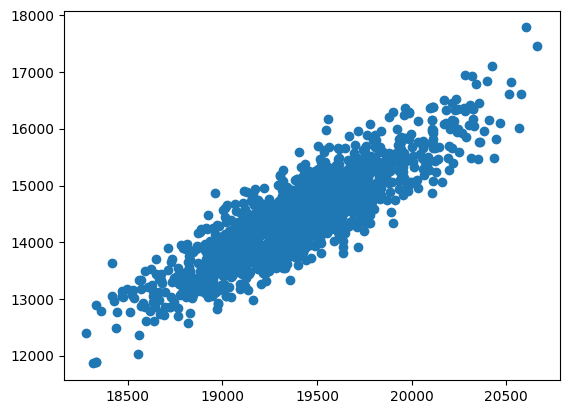

In [78]:
x,y=theta_tln_test[np.where(np.isinf(l2_test))].T
plt.scatter(x,y)

In [73]:
np.isinf(l1_test).any(),np.isinf(l2_test).any()

(False, True)

In [72]:
print("l1_lp: min = {} max = {} mean = {} std = {}".format(np.min(l1_lp),np.max(l1_lp),np.mean(l1_lp),np.std(l1_lp)))
print("l2_lp: min = {} max = {} mean = {} std = {}".format(np.min(l2_lp),np.max(l2_lp),np.mean(l2_lp),np.std(l2_lp)))

print("l1_test: min = {} max = {} mean = {} std = {}".format(np.min(l1_test),np.max(l1_test),np.mean(l1_test),np.std(l1_test)))
print("l2_test: min = {} max = {} mean = {} std = {}".format(np.min(l2_test),np.max(l2_test),np.mean(l2_test),np.std(l2_test)))

l1_lp: min = 46.23093864241949 max = 107.08838334513983 mean = 80.16019954220684 std = 7.39577889822831
l2_lp: min = -1320.709443793811 max = -374.41255754565987 mean = -748.7838957690543 std = 108.1563882073535
l1_test: min = 42.77831353761985 max = 107.09425381172645 mean = 80.25128317598679 std = 7.842574440451659
l2_test: min = -1344.982495369883 max = inf mean = inf std = nan


/Users/luciano/opt/anaconda3/envs/permABC/lib/python3.7/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [60]:
l1_lp = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_tln_lp,theta_tln_lp),total=len(Y_tln_lp))])
l2_lp = np.array([lratio_tln_gp(y,mean = post[0],std = post[1]) for y,post in tqdm(zip(Y_gp_lp,theta_gp_lp),total=len(Y_gp_lp))])


100%|██████████| 50000/50000 [00:53<00:00, 935.90it/s]


In [61]:
logBF_tln_gp_lp = logBF_paper(l1_lp,l2_lp)
print("logBF = {}".format(logBF_tln_gp_lp))

logBF = -164.52688207699208


In [70]:
index = np.random.choice(len(Y_tln_lp),20000,replace=False)
l1_lp_test = l1_lp[index]
l2_lp_test = l2_lp[index]
logBF_tln_gp_test = logBF_paper(l1_lp_test,l2_lp_test)
print("logBF = {}".format(logBF_tln_gp_test))

logBF = -163.76806240843877


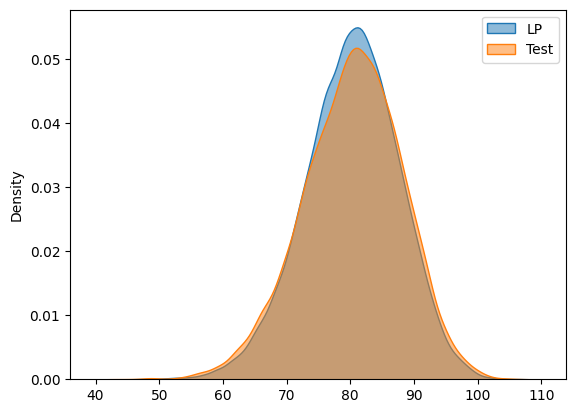

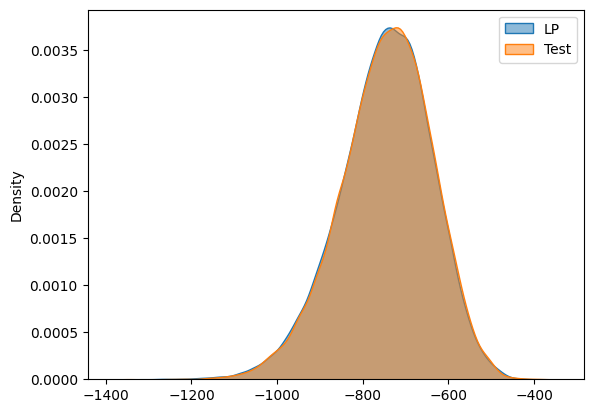

In [66]:
sns.kdeplot(l1_lp,fill=True,alpha=.5,label = "LP")
sns.kdeplot(l1_test,fill=True,alpha=.5,label = "Test")
plt.legend()
plt.show()
sns.kdeplot(l2_lp,fill=True,alpha=.5,label = "LP")
sns.kdeplot(l2_test,fill=True,alpha=.5,label = "Test")
plt.legend()
plt.show()


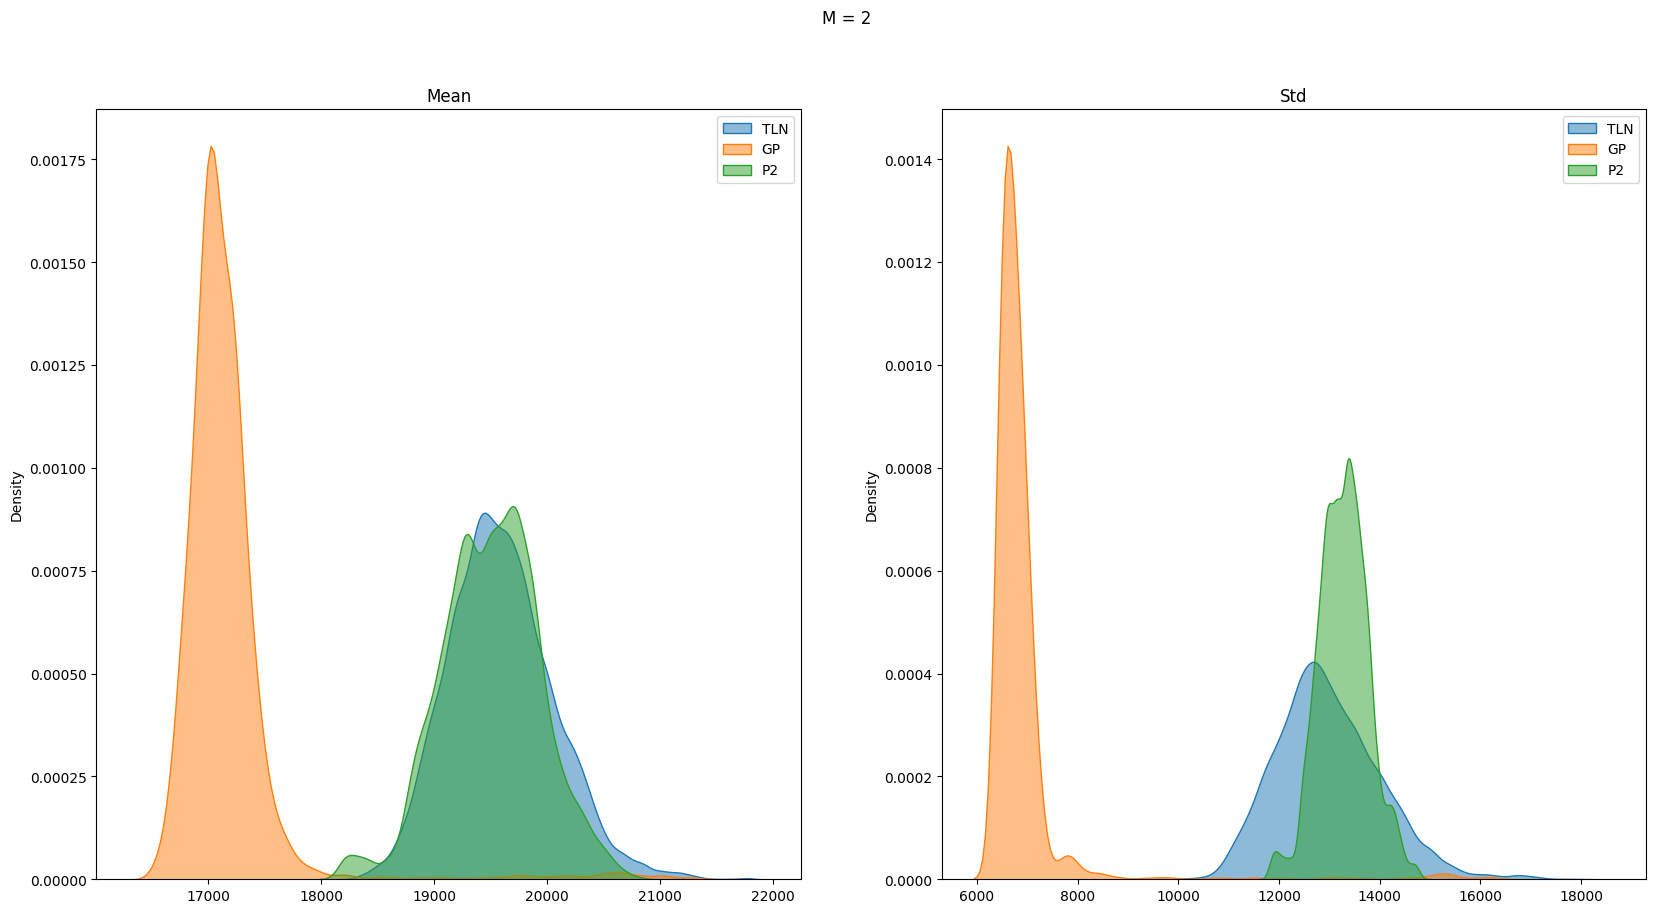

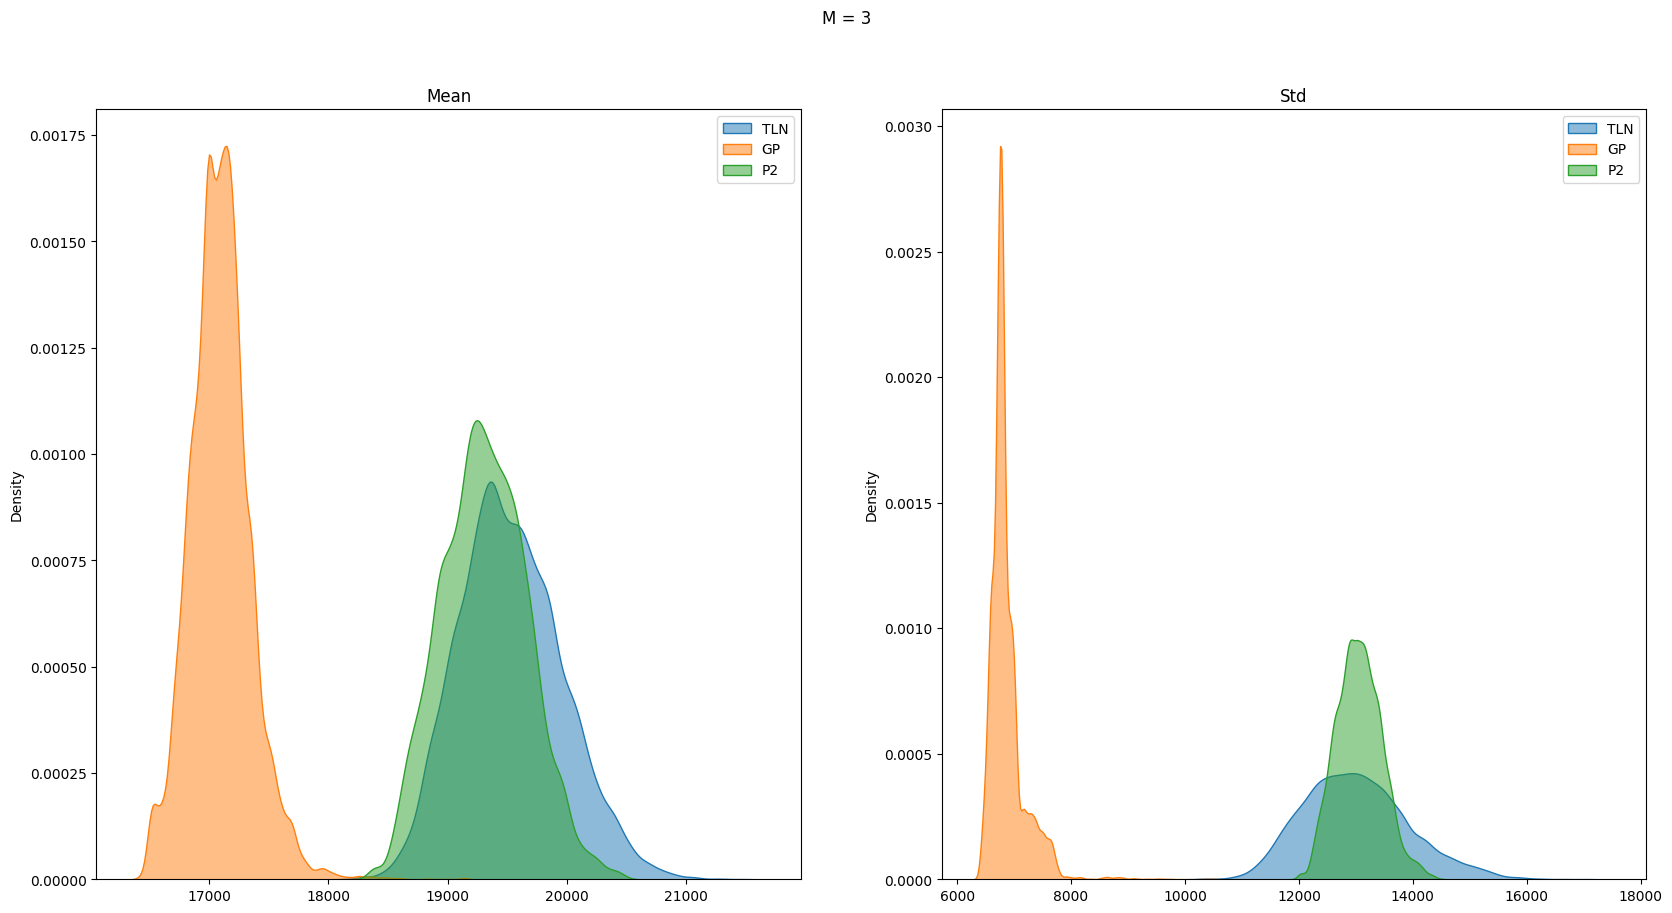

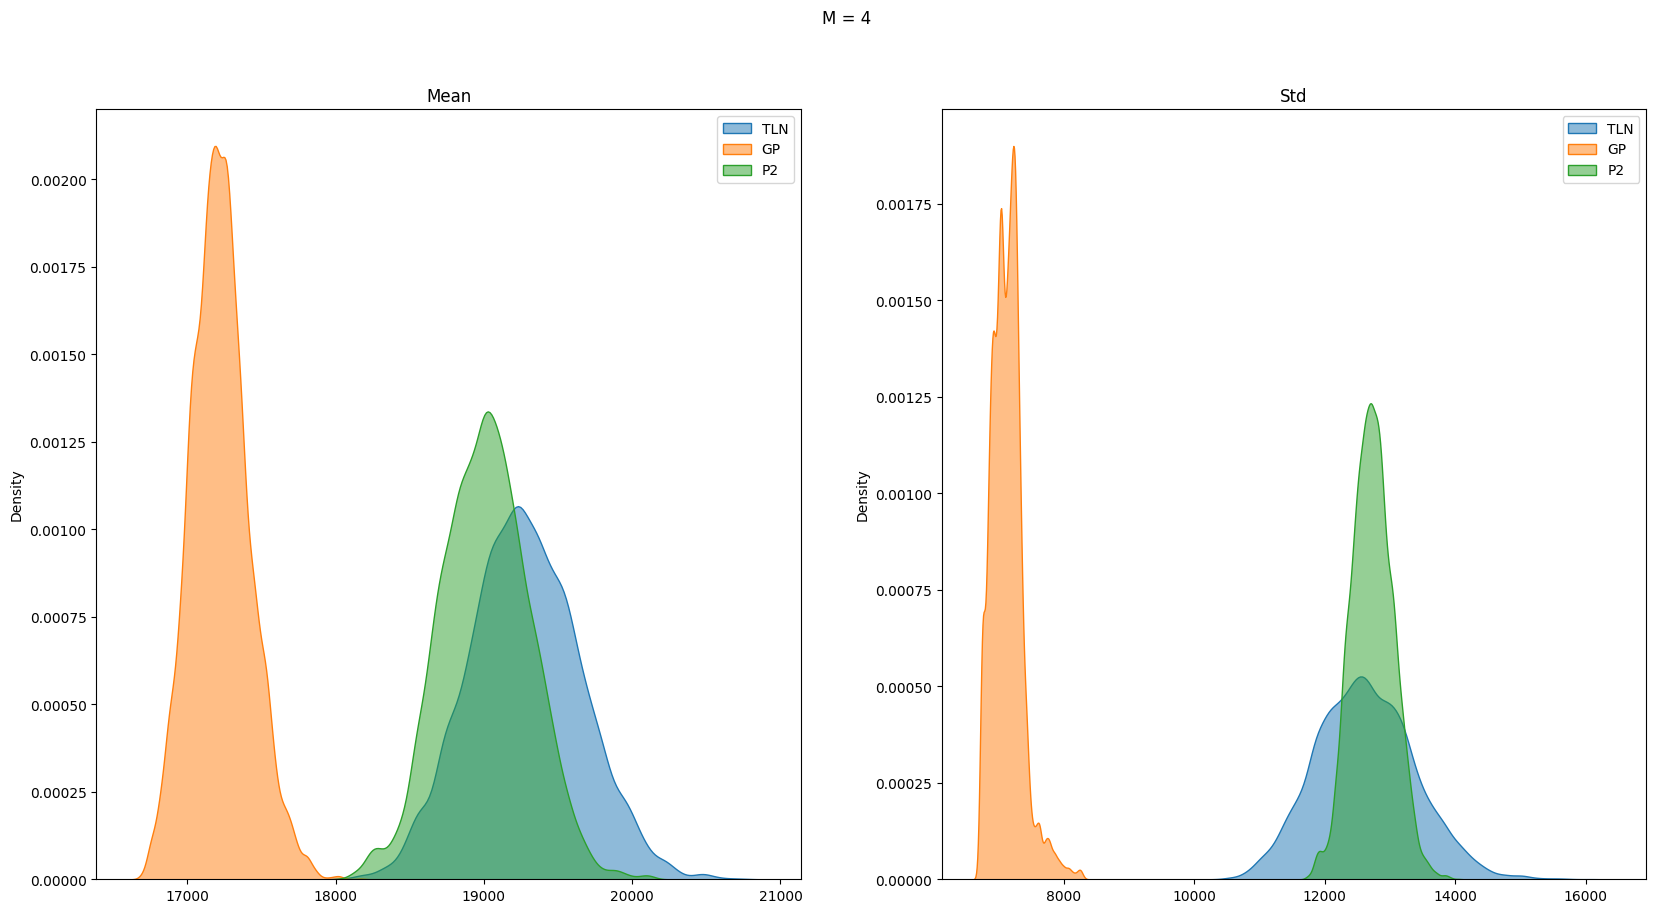

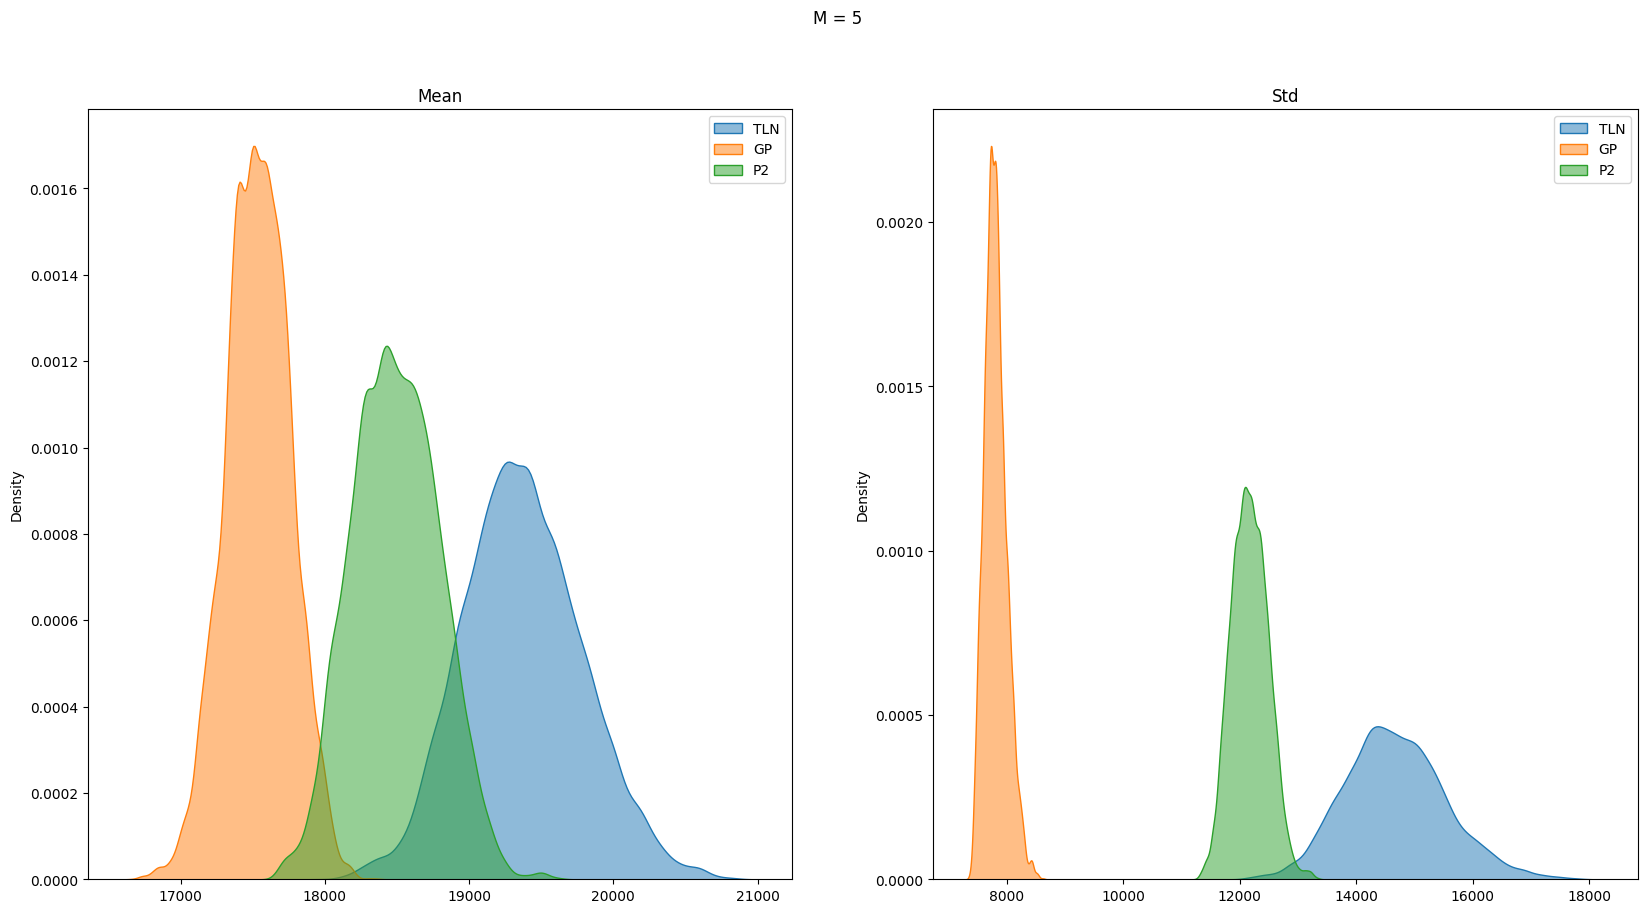

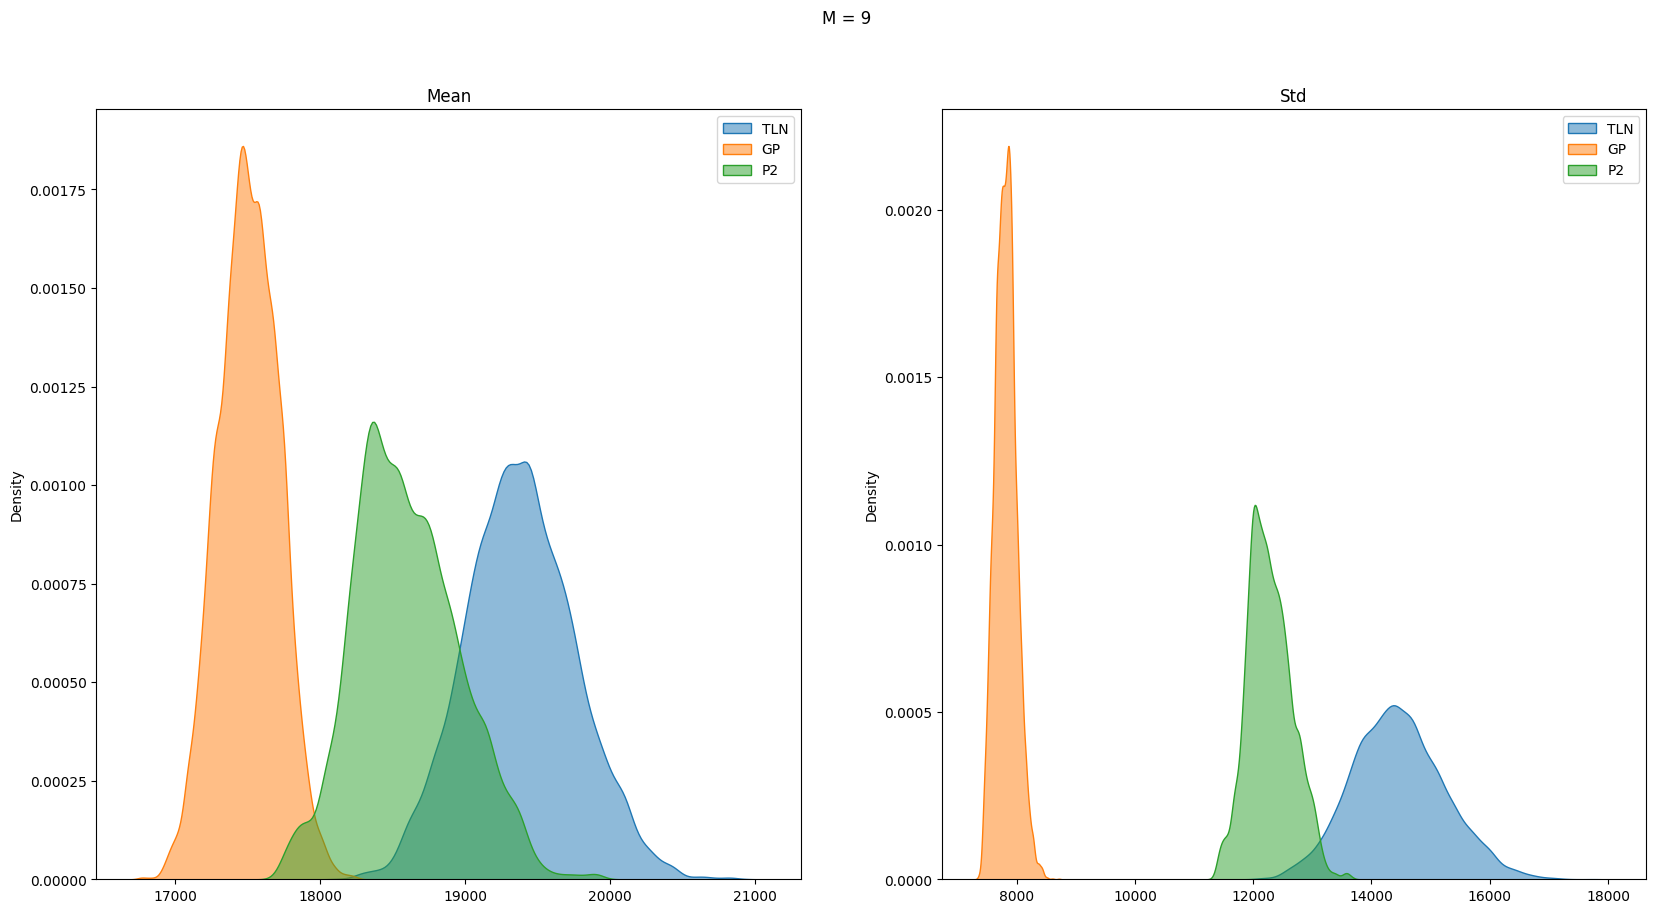

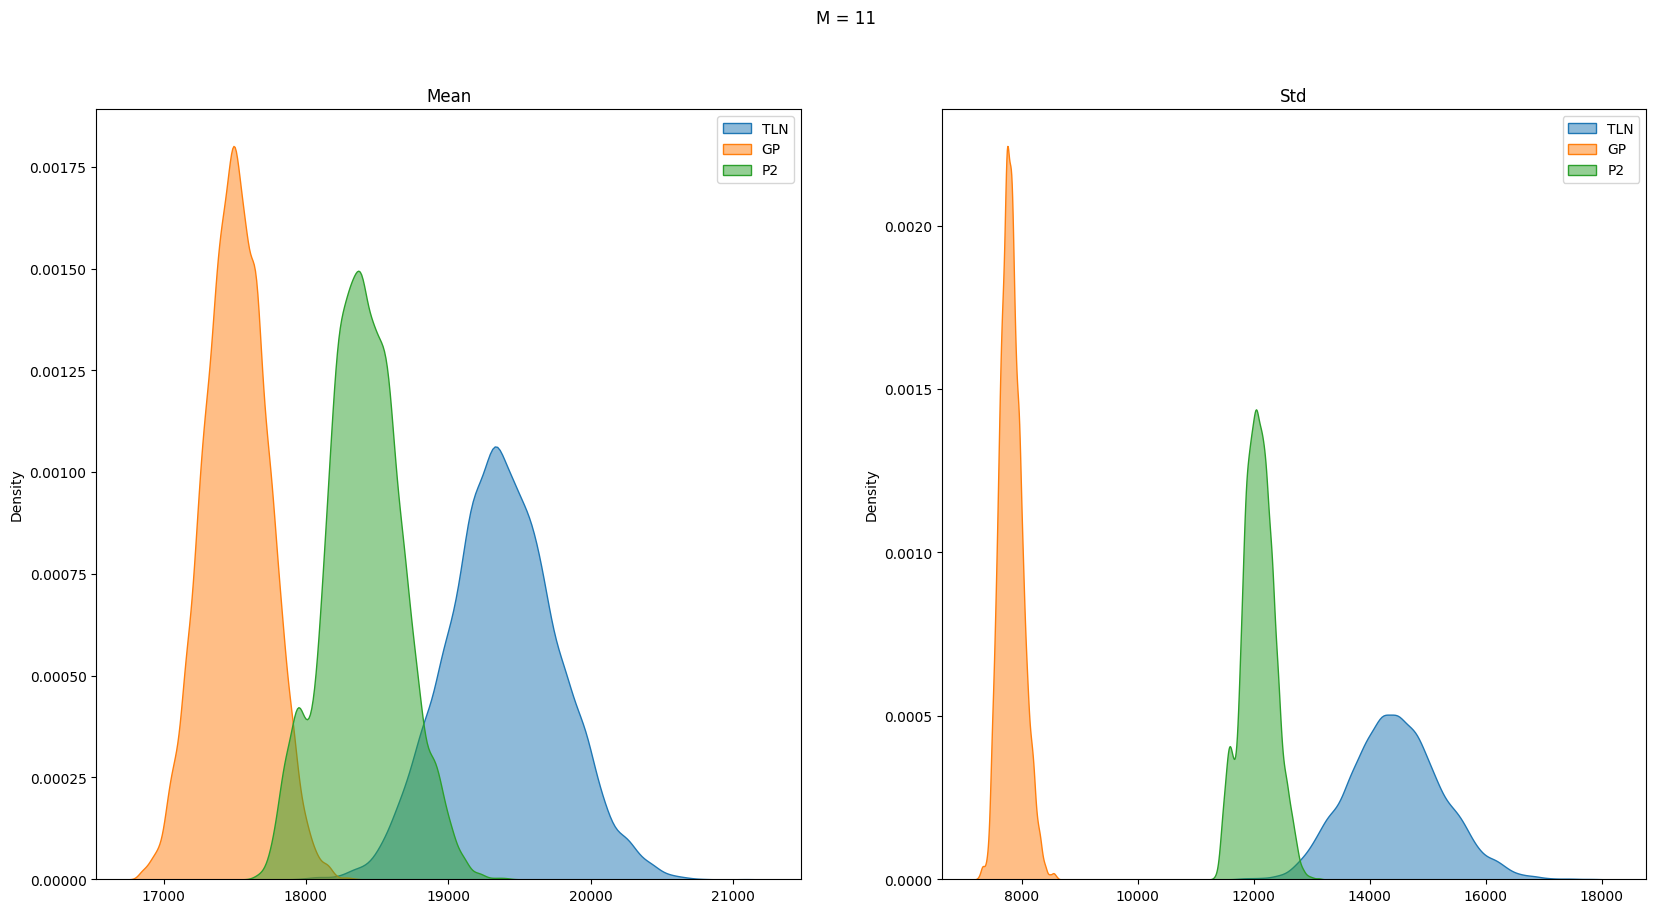

In [55]:
TLN_GP = []
loc = 6389.64
TLN_P2 = []

for i,p in enumerate(P_list):
    Y_gp = np.array(GP_list[i]["X"][1000:])
    Y_tln = np.array(TLN_list[i]["X"][1000:])
    Y_p2 = np.array(P2_list[i]["X"][1000:])
    
    theta_gp = np.array([GP_list[i]["chains"]["mean"][1000:],GP_list[i]["chains"]["std"][1000:]]).T
    theta_tln = np.array([TLN_list[i]["chains"]["mean"][1000:],TLN_list[i]["chains"]["std"][1000:]]).T
    theta_p2 = np.array([P2_list[i]["chains"]["mean"][1000:],P2_list[i]["chains"]["std"][1000:]]).T
    
    f,ax = plt.subplots(1,2,figsize=(20,10))
    sns.kdeplot(theta_tln[:,0],ax=ax[0],fill=True,alpha=.5,label="TLN")
    sns.kdeplot(theta_gp[:,0],ax=ax[0],fill=True,alpha=.5,label="GP")
    sns.kdeplot(theta_p2[:,0],ax=ax[0],fill=True,alpha=.5,label="P2")
    ax[0].set_title("Mean")
    ax[0].legend()
    sns.kdeplot(theta_tln[:,1],ax=ax[1],fill=True,alpha=.5,label="TLN")
    sns.kdeplot(theta_gp[:,1],ax=ax[1],fill=True,alpha=.5,label="GP")
    sns.kdeplot(theta_p2[:,1],ax=ax[1],fill=True,alpha=.5,label="P2")
    ax[1].set_title("Std")
    ax[1].legend()
    f.suptitle("M = {}".format(len(p)))
    plt.show()
    